# Testing PINNs on thermal diffusion problems
PINNs are neural networks made to approximate solutions of PDE systems. In a few words, they leverage experimental data and physical equation to efficiently approximate the solution of PDE systems in a continuous manner. On a physician perspective PINNs can be viewed as postulating the form of the solution of a PDE and then try to find the parameters that would allow to fit to the solution and boundary conditions.


The aim of PINNs is to approximate physical equations and leverage experimental data. Let $f(x,t)$ be a neural network. $f$ is trained to minimize a loss on a dataset of measurements $\{u(x_i,t_i)\}_{i \in [n]}$ (with, ideally, boundary conditions in it)
\begin{equation}
\text{MSE}_u= \frac{1}{n} \sum_{i=1}^n \|f(x_i,t_i) - u(x_i,t_i)\|^2 \tag{1}
\end{equation}

On the other hand the physical system is bound to follow certain rules in the form of Partial Derivative Equation. Generally the can be written in the form of a differential operator $\mathcal{N}$
\begin{equation}
\frac{\partial u}{\partial t}+ \mathcal{N}[u]=0 \tag{2}
\end{equation}
For instance for the heat equation:
\begin{equation*}
\mathcal{N}[u]= - D(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2})
\end{equation*}

In order to infuse the neural network with physical knowledge we add to the statistical error a physical error, that is to say on a set of collocation points $\{(x_k,t_k)\}_{k\in[N]}$ that are usually different from the measurement points and that can change thoughout the training procedure we compute a physical error:
\begin{equation}
\text{MSE}_{\phi}=\frac{1}{N} \sum_{k=1}^N \| \frac{\partial f}{\partial t}|_{(x_k,t_k)} + \mathcal{N}[f]|_{(x_k,t_k)} \|^2 \tag{3}
\end{equation}

Thus the final error to be optimized is 
\begin{equation*}
\text{MSE}= \text{MSE}_u + \text{MSE}_{\phi}
\end{equation*}

Partial derivative can then be computed leveraging automatic differentiation implemented in numerous deep learning libraries such as tensorflow, pytorch, jax


In [1]:

import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math

class PINN(nn.Module):
    def __init__(self, input_size):
        """
        Simple 5 layer neural network
        """
        super(PINN,self).__init__()
        self.linear1 = nn.Linear(input_size, 500)
        self.linear2 = nn.Linear(500,500)
        self.linear3 = nn.Linear(500,500)
        self.linear4 = nn.Linear(500,500)
        self.linear5 = nn.Linear(500,1)
        self.nonlin = nn.Sigmoid() #Non Linearity is chosen to be sigmoid since we differenciate twice

    def forward(self,x):
        return self.nonlin(self.linear5(self.nonlin(self.linear4(self.nonlin(self.linear3(self.nonlin(self.linear2(self.nonlin(self.linear1(x))))))))))


Our illustrating case will be the following one: heat diffusion in a homogeneous bar where the bar is at temperature 1 on the right side and temperature 0 on the other (this case can be made from arbitrary temperature thanks to an appropriate scaling)

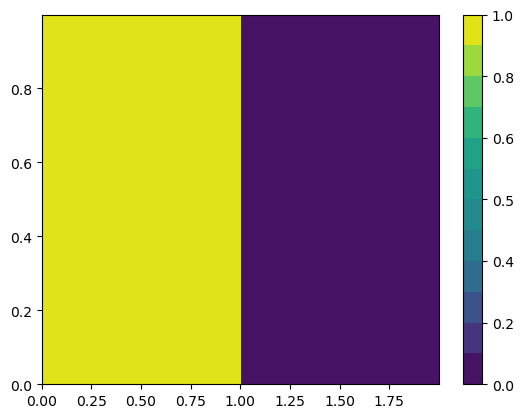

<Figure size 640x480 with 0 Axes>

In [2]:
def plot_case():
    xs,ys,zs = np.meshgrid(np.arange(0,2,0.001),np.arange(0,1,0.001),[0])
    zs[xs<1]=1.
    plt.contourf(xs.squeeze(),ys.squeeze(),zs.squeeze(),levels=[0.,0.1,0.2,0.3,0.4,0.45,0.50,0.55,0.6,0.7,0.8,0.9,1.])
    plt.colorbar()
    plt.show()
    plt.clf()
plot_case()

First we define the boundary loss $\text{MSE}_u$, we devised that it would have 3 components (other choices can be made, for instance in case of measurements):
* The initial conditions as displayed in the chart above: $\forall (x,y) \in \Omega,T(x,y,t=0)=T_0(x,y)$
* The border condition of a null thermal flux: $\forall (x,y) \in \partial\Omega, \vec{\nabla}_{(x,y)}T.\vec{n}(x,y)=0$ where $\vec{n}(x,y)$ is the normal vector to the boundary
* The final condition as a homogeneous state:  $\forall (x,y) \in \Omega,T(x,y,t=\infty)=T_f$


In [3]:
def boundary_loss(model,N,device=None,dtype=None):
   # State is composed of x,y and t 
   # Sampling randomly initial state, thus for t=0:   
   values_init = torch.rand(N,3)*np.array([2.,1.,0.])
   label_init = torch.zeros(N,1)
   label_init[values_init[:,[0]]<1]=1. # left side temperature =1 when x<0
       
   #setting to device and dtype
   values_init=values_init.to(device=device,dtype=dtype)
   label_init = label_init.to(device=device,dtype=dtype)
   
   #Error initial condition
   loss_init = torch.mean((model(values_init)-label_init)**2)
   
   #Sampling final  thus for t=1
   values_end = torch.rand(N,3)*torch.tensor([2.,1.,0.,])
   values_end[:,2]=torch.ones_like(values_end[:,2]) # setting t=1
   label_end = torch.ones(N,1)*0.5 #uniform temperature at the end
  
   #setting to device and dtype
   values_end=values_end.to(device=device,dtype=dtype)
   label_end = label_end.to(device=device,dtype=dtype)

   #Error end condition
   loss_end = torch.mean((model(values_end)-label_end)**2)
   
   #Sampling the border of the rectangle (perimeter 2+1+2+1=6)
   values_limit=torch.rand(N)*6
    
   #Initializing the border at random positions and time
   values_border = torch.zeros(N,3)
   
   #first edge: x=random(0,2), y=0
   values_border[:,0][values_limit<2]=values_limit[values_limit<2]
   values_border[:,1][values_limit<2]=0. # explicit is better than implicit
   #second edge: x=2, y=random(0,1) 
   values_border[:,1][(2<values_limit)*(values_limit<3)]=values_limit[(2<values_limit)*(values_limit<3)] - 2.
   values_border[:,0][(2<values_limit)*(values_limit<3)]=2.
   #third edge: x=random(0,2), y=1
   values_border[:,0][(3<values_limit)*(values_limit<5)]=values_limit[(3<values_limit)*(values_limit<5)]-3.
   values_border[:,1][(3<values_limit)*(values_limit<5)]=1.
   
   #fourth edge: x=0, y=random(0,1)
   values_border[:,1][5<values_limit]=values_limit[5<values_limit]-5.
   values_border[:,0][5<values_limit]=0 #explicit is better than implicit

   # at random times
   values_border[:,2]= torch.rand(values_border.shape[0])
   #setting to device and dtype
   values_border=values_border.to(device=device,dtype=dtype)
   values_border.requires_grad=True

   # Computing grads with autodifferentiation
   u = model(values_border)
   ux = autograd.grad(u,values_border,create_graph=True,grad_outputs=torch.ones_like(u),allow_unused = True,retain_graph=True)[0]
   
   #first edge: u_y = 0
   grads_border= torch.sum(ux[:,1][values_limit<2]**2)
   #first edge: u_x = 0
   grads_border += torch.sum(ux[:,0][(2<values_limit)*(values_limit<3)]**2)
   #first edge: u_y = 0
   grads_border+= torch.sum(ux[:,1][(3<values_limit)*(values_limit<5)]**2)
   #first edge: u_x = 0
   grads_border+= torch.sum(ux[:,0][5<values_limit]**2)
   #averaging
   grads_border/=N

   # Aggregating losses
   loss_boundary_condition=loss_end + loss_init + grads_border
   return loss_boundary_condition

Now we need to implement the physical loss in order to enforce the dynamics (equation (3))
The real time evolving from 0 to $\infty$ we determined (by studying real dynamics) that the final state is reached closely at $t=800$ thus the time for the neural network will be $t'=t/800$ for it to be between 0 and 1. 
For the physical loss, the time derivatives are computed with respect to $t$ not $t'$

In [4]:
def physical_loss(model,N,device=None,dtype=None):
    # on random space points
    space = torch.rand(N,2)*torch.tensor([2.,1.])
    space = space.to(device=device,dtype=dtype)
    space.requires_grad=True
    
    # reparametrization of the time (the real time evolves from 0 to 800 (almost final state), and the time for the neural net evolves from 0 to 1)
    time = torch.rand(N,1)*600
    time = time.to(device=device,dtype=dtype)
    time.requires_grad=True
    # reparametrization
    t_s =time/600
    # concatenante space and reparametrized time (=real time / 800)
    u = model(torch.cat((space,t_s),axis=1))
    
    # Computing derivatives
    # in real time
    ut =  autograd.grad(u,time,create_graph=True,grad_outputs=torch.ones_like(u),allow_unused = True,retain_graph=True)[0]
    # first order in space
    ux = autograd.grad(u,space,create_graph=True,grad_outputs=torch.ones_like(u),allow_unused = True,retain_graph=True)[0]
    # second order in space
    uxx = autograd.grad(ux,space,create_graph=True,grad_outputs=torch.ones_like(ux),allow_unused = True,retain_graph=True)[0]
    # heat diffusion equation with diffusion coefficient D=0.001
    philoss = (ut[:,0] - 0.001*(uxx[:,0]+uxx[:,1]))**2
    return torch.sum(philoss)

All remains to code the training loop

In [5]:
def train(model,boundary_loss,physical_loss,epochs=10000,lr=0.001):

    
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, epochs//3, gamma=0.1)
    # Parameters (chosen arbitrarily)
    N_boundary=20000
    N_phi = 10000
   

    # logs
    log_freq=500
    logs=[]
    
    for epoch in range(epochs):
        loss =  boundary_loss(model,N_boundary,device=device,dtype=dtype)+physical_loss(model,N_phi,device=device,dtype=dtype)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        logs.append(loss.item())
        if (epoch+1)%log_freq==0:
            print("Epoch {},".format(epoch), "Loss: ",np.mean(logs))
            logs=[]
    return model

We add some utilities functions so as to plot the solution at a given timestep given the model

In [6]:
def plot_timestep(model,t,device=None,dtype=None):
    #building grid of points
    xs,ys,ts = np.meshgrid(np.arange(0,2,0.002),np.arange(0,1,0.002),[t])
    
    #computing solution for the given time step
    with torch.no_grad():
        X_grid= torch.tensor(np.stack([xs,ys,ts],axis=-1)).to(device=device,dtype=dtype)
        Z_pt = torch.clamp(model(X_grid).squeeze(),0,1)
        Z_mesh = Z_pt.cpu().numpy()
    #plot contours
    plt.contourf(xs.squeeze(),ys.squeeze(),Z_mesh,levels=np.linspace(0.,1.,100))
    plt.colorbar()
    plt.show()
    plt.clf()

Performing the training and plotting results

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    dtype = torch.float
    # Model and optimization 
    model = PINN(3)
    model.to(device=device,dtype=dtype)
    model.train()
    model.load_state_dict(torch.load("model_simple_initial_condition.pt",map_location=device))
    model = train(model,boundary_loss,physical_loss,epochs=1000,lr=0.00001)
    torch.save(model.state_dict(),"model_simple_initial_condition_finetuned.pt")
else:
    model = PINN(3)
    model.load_state_dict(torch.load("model_simple_initial_condition.pt",map_location=torch.device('cpu')))

Epoch 499, Loss:  0.007592518615536391
Epoch 999, Loss:  0.007553316185250878


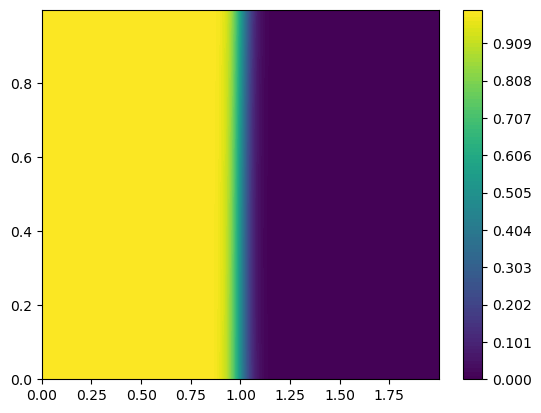

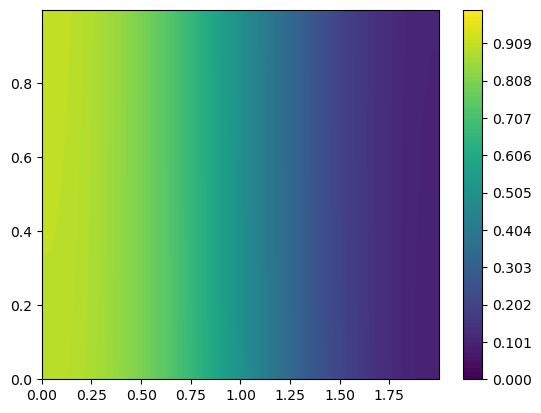

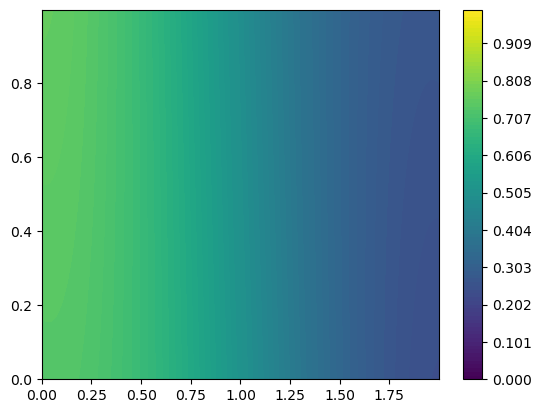

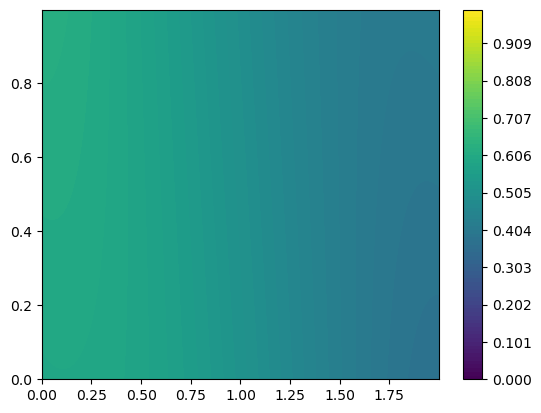

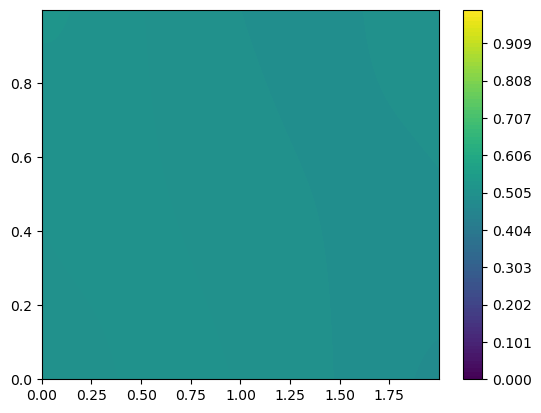

<Figure size 640x480 with 0 Axes>

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dtype = torch.float
for timestep in np.linspace(0,600,5,endpoint=True):
        plot_timestep(model,timestep/600,device=device,dtype=dtype)

For the sake of comparison we provide the solution by using Fourier decompositions

In [9]:

def initial_condition(x):
    """
    Function that return the initial state, will be used for computing fourier coefficients
    """
    results = torch.zeros_like(x[...,0])
    results[x[...,0]<1]=1.0
    return results

def solution(order,u_zero,sampling,nb_evaluations=1,device=None,dtype=None):
    """
    Parameters:
        order: (int) order of the Fourier decomposition to be computed
        u_zero: callable that takes any tensor (*,2) and returns the initial condition at the given points
        sampling: number of sampling for computing the fourier transform (integral) using MC
    Function runs efficiently on GPU but is very memory consumming
    This function is general for any initial condition u_zero
    Return: 
        solution (callable) that gives temperature at coordinates (x,y,t): takes any tensor (*,3) and returns (*,1) tensor
    """
    #building coeff grid
    grid = np.stack(np.meshgrid(range(order),range(order)),axis=-1)
    grid=torch.tensor(grid,device=device,dtype=dtype)
    coeffs = torch.zeros(order,order,device=device,dtype=dtype)
    for _ in range(nb_evaluations):
        #sampling
        values=torch.rand(sampling,order,order,2,device=device,dtype=dtype)*torch.tensor([2.,1.],device=device,dtype=dtype)
        #computing initial conditions
        evaluations= u_zero(values)
        # computing fourier coefficients
        coefs = 4*torch.mean(evaluations*torch.cos(math.pi*values[...,0]*grid[...,0]/2)*torch.cos(math.pi*values[...,1]*grid[...,1]),dim=0)
        coefs[0,:]=coefs[0,:]/2
        coefs[:,0]=coefs[:,0]/2
        coeffs += coefs/nb_evaluations
    #building inference function
    def sol(input):
        fft_inv = torch.cos(math.pi*input[...,0].unsqueeze(-1).unsqueeze(-1)*grid[...,0]/2)*torch.cos(math.pi*input[...,1].unsqueeze(-1).unsqueeze(-1)*grid[...,1])
        fft_inv = coeffs*fft_inv
        fft_inv = fft_inv*torch.exp(-input[...,2].unsqueeze(-1).unsqueeze(-1)*(grid[...,0]**2*math.pi**2/4+grid[...,1]**2*math.pi**2)*0.001)
        return torch.sum(fft_inv,dim=(-1,-2))
    # returning inference function
    return sol

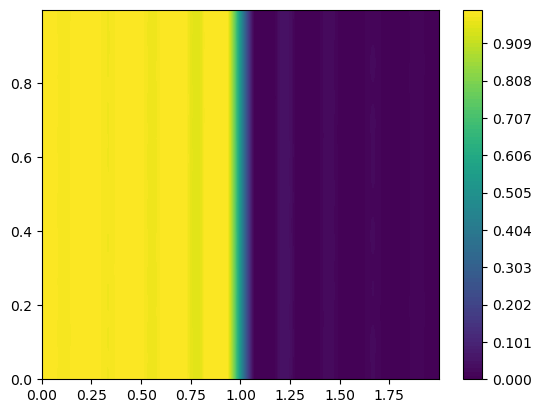

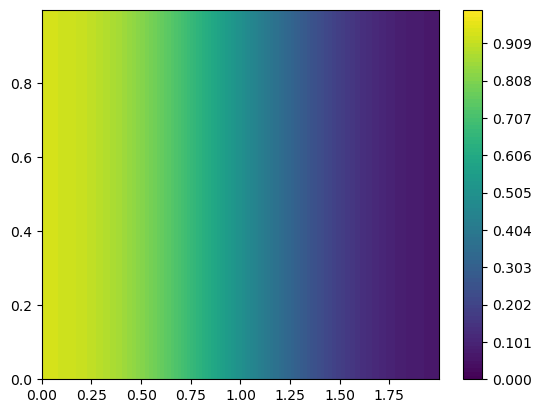

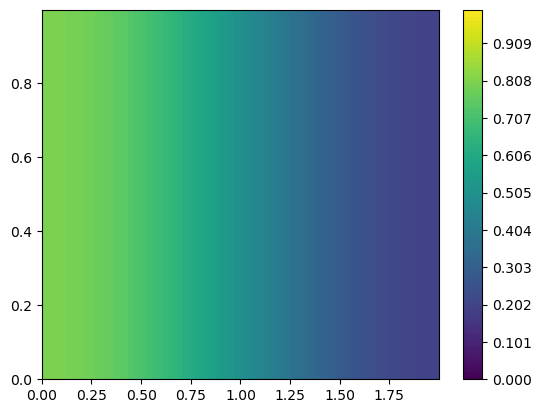

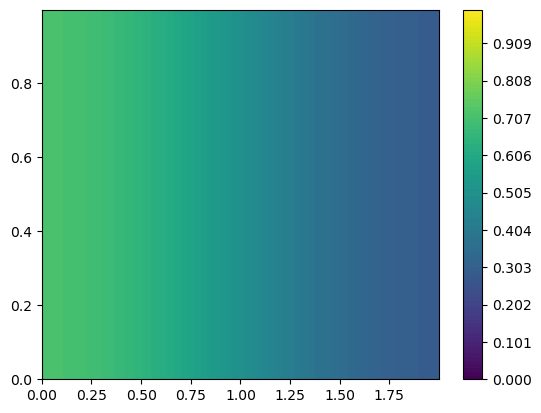

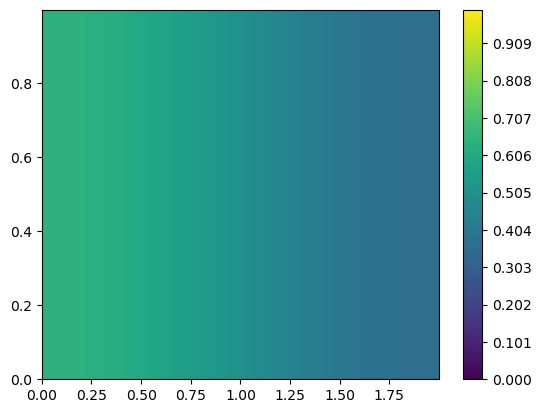

<Figure size 640x480 with 0 Axes>

In [10]:
# if you have a VRAM error, reduce the number of modes and the sampling
if torch.cuda.is_available():
        # you can run this code if you don't have cuda but it will be much slower
        fourier_solution = solution(order=18,u_zero=initial_condition,sampling=2000000,nb_evaluations=500,device=device,dtype=dtype)
        for timestep in np.linspace(0,600,5,endpoint=True):
                #starting at 1 because initial condition is not that well reconstructed (discountinuity)
                plot_timestep(fourier_solution,timestep,device=device,dtype=dtype)

We can test for other boundary conditions

In [11]:
def boundary_loss_circle(model,N,device=None,dtype=None):
   # State is composed of x,y and t 
   # Sampling randomly initial state, thus for t=0:   
   values_init = torch.rand(N,3)*np.array([2.,1.,0.])
   label_init = torch.zeros(N,1)
   label_init[((values_init[:,[0]]-1.)**2 +(values_init[:,[1]]-0.5)**2)<0.25]=1. # temperature=1 in a disk of radius 0.5 centered in (1,0.5)
       
   #setting to device and dtype
   values_init=values_init.to(device=device,dtype=dtype)
   label_init = label_init.to(device=device,dtype=dtype)
   
   #Error initial condition
   loss_init = torch.mean((model(values_init)-label_init)**2)
   
   #Sampling final  thus for t=1
   values_end = torch.rand(N,3)*np.array([2.,1.,0.,])
   values_end[:,2]=torch.ones_like(values_end[:,2]) # setting t=1
   label_end = torch.ones(N,1)*math.pi*0.25/2 #uniform temperature at the end equal to \piR^2/ (2*1)
  
   #setting to device and dtype
   values_end=values_end.to(device=device,dtype=dtype)
   label_end = label_end.to(device=device,dtype=dtype)

   #Error end condition
   loss_end = torch.mean((model(values_end)-label_end)**2)
   
   #Sampling the border of the rectangle (perimeter 2+1+2+1=6)
   values_limit=torch.rand(N)*6
    
   #Initializing the border at random positions and time
   values_border = torch.rand(N,3)
   
   #first edge: x=random(0,2), y=0
   values_border[:,0][values_limit<2]=values_limit[values_limit<2]
   values_border[:,1][values_limit<2]=0.
   #second edge: x=2, y=random(0,1) 
   values_border[:,1][(2<values_limit)*(values_limit<3)]=values_limit[(2<values_limit)*(values_limit<3)] - 2.
   values_border[:,0][(2<values_limit)*(values_limit<3)]=2.
   #third edge: x=random(0,2), y=1
   values_border[:,0][(3<values_limit)*(values_limit<5)]=values_limit[(3<values_limit)*(values_limit<5)]-3.
   values_border[:,1][(3<values_limit)*(values_limit<5)]=1.
   
   #fourth edge: x=0, y=random(0,1)
   values_border[:,1][5<values_limit]=values_limit[5<values_limit]-5.
   values_border[:,0][5<values_limit]=0.
   
   # Setting random times
   values_border[:,2]=torch.rand(N)
   #setting to device and dtype
   values_border=values_border.to(device=device,dtype=dtype)
   values_border.requires_grad=True

   # Computing grads with autodifferentiation
   u = model(values_border)
   ux = autograd.grad(u,values_border,create_graph=True,grad_outputs=torch.ones_like(u),allow_unused = True,retain_graph=True)[0]
   
   #first edge: u_y = 0
   grads_border= torch.sum(ux[:,1][values_limit<2]**2)
   #first edge: u_x = 0
   grads_border += torch.sum(ux[:,0][(2<values_limit)*(values_limit<3)]**2)
   #first edge: u_y = 0
   grads_border+= torch.sum(ux[:,1][(3<values_limit)*(values_limit<5)]**2)
   #first edge: u_x = 0
   grads_border+= torch.sum(ux[:,0][5<values_limit]**2)
   #averaging
   grads_border/=N

   # Aggregating losses
   loss_boundary_condition=loss_end + loss_init + grads_border
   return loss_boundary_condition

In [12]:
# you have cuda it trains, otherwise it loads
if torch.cuda.is_available():
    device = torch.device("cuda")
    dtype = torch.float
    # Model and optimization 
    model2 = PINN(3)
    model2.to(device=device,dtype=dtype)
    model2.train()
    model2.load_state_dict(torch.load("model_circle_initial_condition.pt",map_location=device))
    model2 = train(model2,boundary_loss_circle,physical_loss,epochs=1000,lr=0.00001)
    torch.save(model2.state_dict(),"model_circle_initial_condition_finetuned.pt")
else:
    model2 = PINN(3)
    model2.load_state_dict(torch.load("model_circle_initial_condition.pt",map_location=torch.device('cpu')))

Epoch 499, Loss:  0.0300964129678905
Epoch 999, Loss:  0.030143264174461365


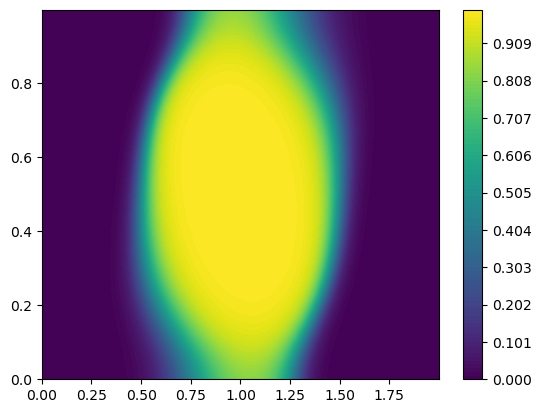

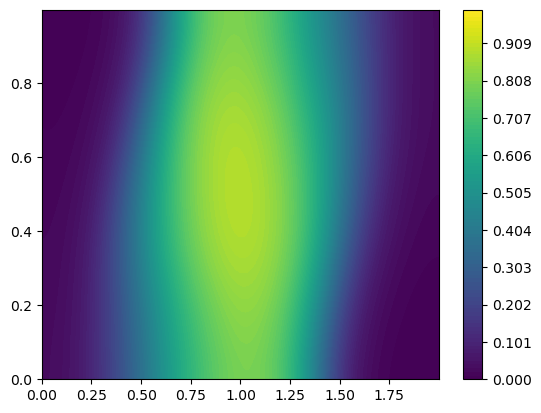

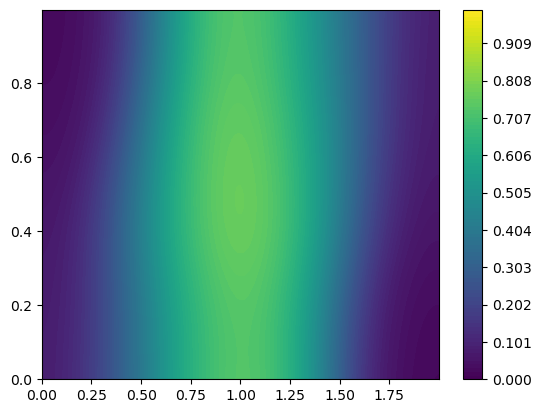

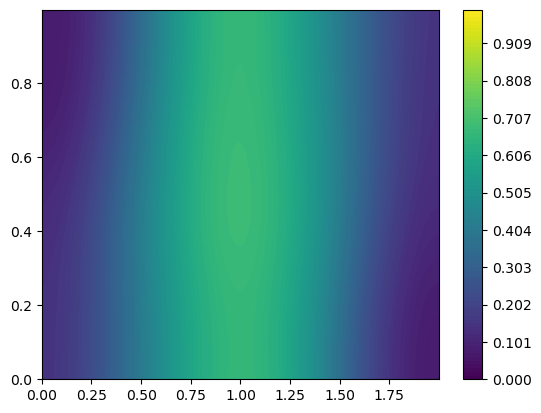

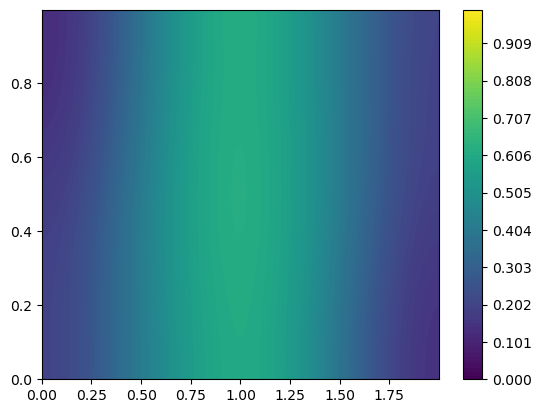

<Figure size 640x480 with 0 Axes>

In [13]:
for timestep in np.linspace(0,100,5,endpoint=True):
        #rescaling time for NN
        plot_timestep(model2,timestep/600,device=device,dtype=dtype)

We note that the prediction appears to be asymmetrical, this pattern is reproduced every time we perform the experiment. Something that is not expected on the real solution presented below on the same timesteps

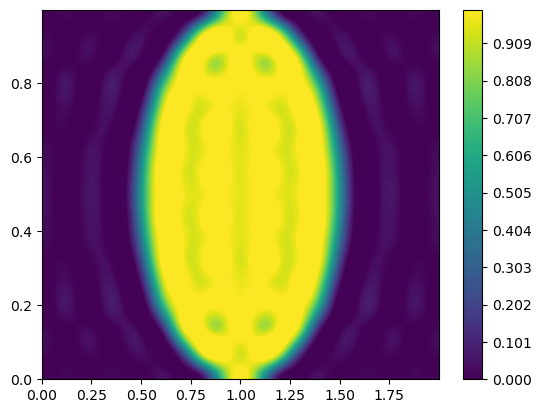

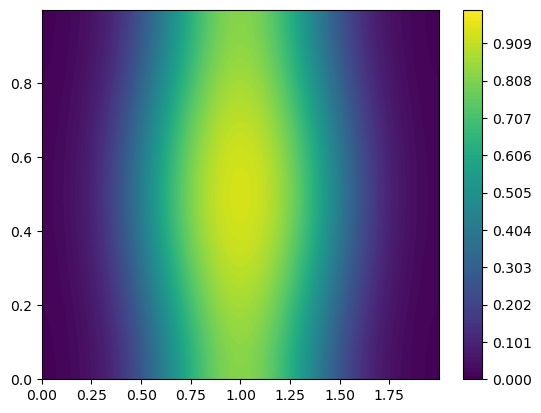

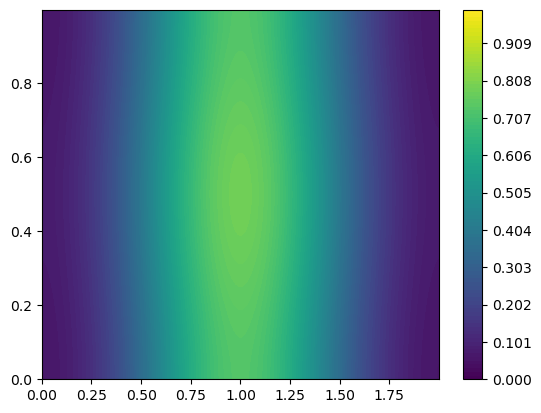

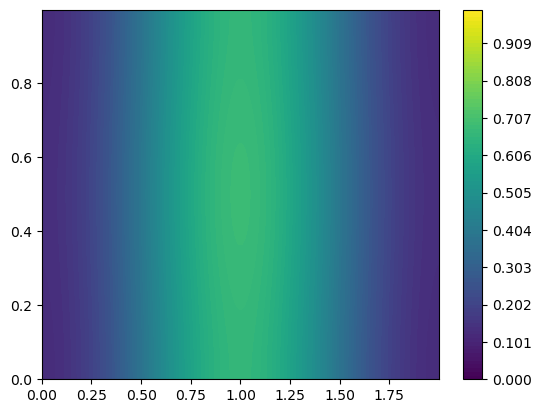

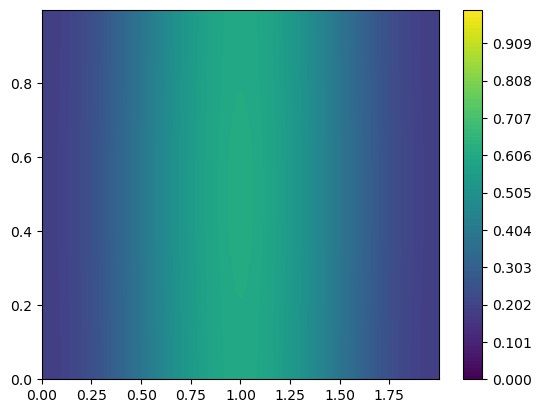

<Figure size 640x480 with 0 Axes>

In [14]:
def initial_condition_circle(x):
    distances = (x[...,0]-1.)**2 + (x[...,1]-0.5)**2
    results = torch.zeros_like(distances)
    results[distances<0.25]=1.0
    return results
# this runs if you have a lot of VRAM or on CPU (with consequent RAM) but it runs for long
if torch.cuda.is_available():
    fourier_solution2 = solution(order=18,u_zero=initial_condition_circle,sampling=2000000,nb_evaluations=500, device=device,dtype=dtype)
    for timestep in np.linspace(0,100,5,endpoint=True):
            plot_timestep(fourier_solution2,timestep,device=device,dtype=dtype)

The results are still remarkable indeed the neural network does not have data in between $t=0$ and $t=1$ which means that is is learning completely in a unsupervised manner the dynamics of the system. However let us stress that the dynamics learnt are specific to the boundary conditions and the parametrization of the PDE that we have chosen ($D$ the diffusion coefficient) thus making it unfit to extrapolate to other configurations.

In [15]:
def loss_circle_informed(model,N,oracle,device=None,dtype=None):
   # State is composed of x,y and t 
   # Sampling randomly initial state, thus for t=0:   
   values_init = torch.rand(N,3)*np.array([2.,1.,0.])
   label_init = torch.zeros(N,1)
   label_init[((values_init[:,[0]]-1.)**2 +(values_init[:,[1]]-0.5)**2)<0.25]=1. # temperature=1 in a disk of radius 0.5 centered in (1,0.5)
       
   #setting to device and dtype
   values_init=values_init.to(device=device,dtype=dtype)
   label_init = label_init.to(device=device,dtype=dtype)
   
   #Error initial condition
   loss_init = torch.mean((model(values_init)-label_init)**2)
   
   
   values_running = (torch.rand(N,3)*torch.tensor([2.,1.,100.])).to(device=device,dtype=dtype)
   label_running = oracle(values_running)
   values_running[...,2]=values_running[...,2]/600
   

   
   #Error initial condition
   loss_running = torch.mean((model(values_running)-label_running)**2)
   
   
   #Sampling final  thus for t=1
   values_end = torch.rand(N,3)*torch.tensor([2.,1.,0.,])
   values_end[:,2]=torch.ones_like(values_end[:,2]) # setting t=1
   label_end = torch.ones(N,1)*math.pi*0.25/2 #uniform temperature at the end equal to \piR^2/ (2*1)
  
   #setting to device and dtype
   values_end=values_end.to(device=device,dtype=dtype)
   label_end = label_end.to(device=device,dtype=dtype)

   #Error end condition
   loss_end = torch.mean((model(values_end)-label_end)**2)
   
   #Sampling the border of the rectangle (perimeter 2+1+2+1=6)
   values_limit=torch.rand(N)*6
    
   #Initializing the border at random positions and time
   values_border = torch.rand(N,3)
   
   #first edge: x=random(0,2), y=0
   values_border[:,0][values_limit<2]=values_limit[values_limit<2]
   values_border[:,1][values_limit<2]=0.
   #second edge: x=2, y=random(0,1) 
   values_border[:,1][(2<values_limit)*(values_limit<3)]=values_limit[(2<values_limit)*(values_limit<3)] - 2.
   values_border[:,0][(2<values_limit)*(values_limit<3)]=2.
   #third edge: x=random(0,2), y=1
   values_border[:,0][(3<values_limit)*(values_limit<5)]=values_limit[(3<values_limit)*(values_limit<5)]-3.
   values_border[:,1][(3<values_limit)*(values_limit<5)]=1.
   
   #fourth edge: x=0, y=random(0,1)
   values_border[:,1][5<values_limit]=values_limit[5<values_limit]-5.
   values_border[:,0][5<values_limit]=0.
   
   # Setting random times
   values_border[:,2]=torch.rand(N)
   #setting to device and dtype
   values_border=values_border.to(device=device,dtype=dtype)
   values_border.requires_grad=True

   # Computing grads with autodifferentiation
   u = model(values_border)
   ux = autograd.grad(u,values_border,create_graph=True,grad_outputs=torch.ones_like(u),allow_unused = True,retain_graph=True)[0]
   
   #first edge: u_y = 0
   grads_border= torch.sum(ux[:,1][values_limit<2]**2)
   #first edge: u_x = 0
   grads_border += torch.sum(ux[:,0][(2<values_limit)*(values_limit<3)]**2)
   #first edge: u_y = 0
   grads_border+= torch.sum(ux[:,1][(3<values_limit)*(values_limit<5)]**2)
   #first edge: u_x = 0
   grads_border+= torch.sum(ux[:,0][5<values_limit]**2)
   #averaging
   grads_border/=N

   # Aggregating losses
   loss_boundary_condition=loss_end + loss_init + grads_border +loss_running
   return loss_boundary_condition


def boundary_loss_proxy(model,N,device=None,dtype=None):
   return loss_circle_informed(model,N,fourier_solution2,device=device,dtype=dtype)

Epoch 499, Loss:  0.14302650126814842
Epoch 999, Loss:  0.1429240472316742


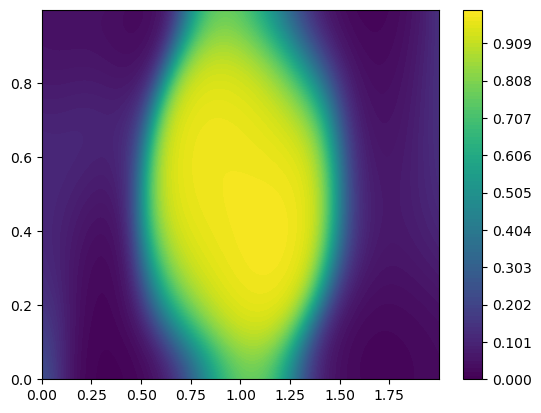

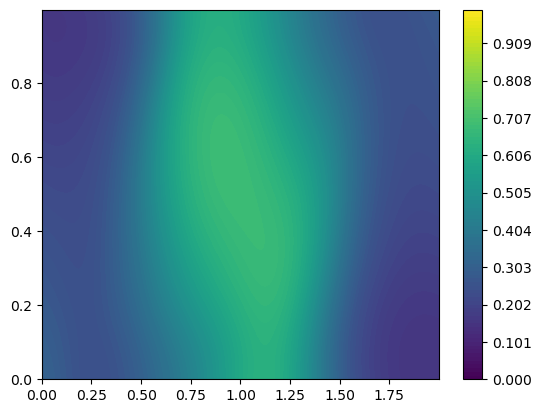

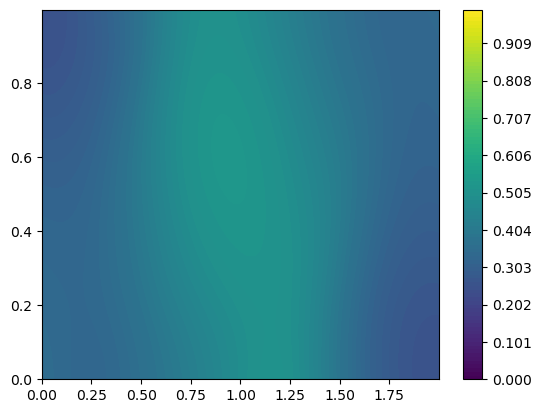

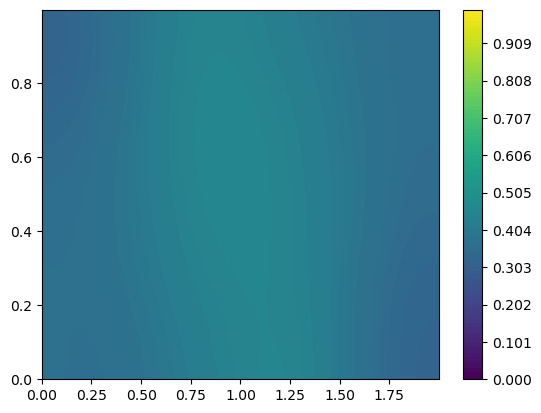

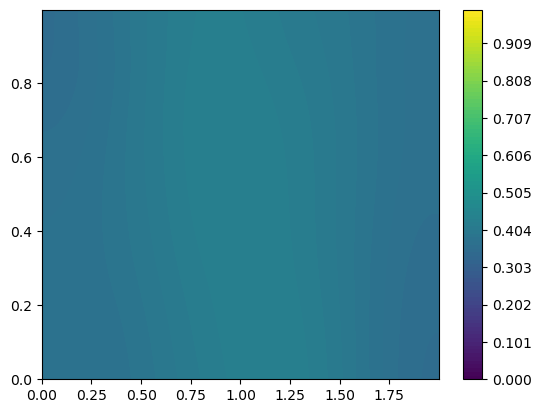

<Figure size 640x480 with 0 Axes>

In [16]:
# you have cuda it trains, otherwise it loads
if torch.cuda.is_available():
    device = torch.device("cuda")
    dtype = torch.float
    # Model and optimization 
    model3 = PINN(3)
    model3.to(device=device,dtype=dtype)
    model3.train()
    model3.load_state_dict(torch.load("model_circle_fourier.pt",map_location=device))
    model3 = train(model3,boundary_loss_proxy,physical_loss,epochs=1000,lr=0.00001)
    torch.save(model3.state_dict(),"model_circle_fourier_finetuned.pt")
else:
    model3 = PINN(3)
    model3.load_state_dict(torch.load("model_circle_fourier.pt",map_location=torch.device('cpu')))

for timestep in np.linspace(0,100,5,endpoint=True):
        #rescaling time for NN
        plot_timestep(model3,timestep/600,device=device,dtype=dtype)

## FEM Method 
Using FEM to generate data to use with the PINN

In [17]:
from Muscat.FE.Integration import IntegrateGeneral
from Muscat.Containers.ConstantRectilinearMeshTools import CreateConstantRectilinearMesh
from Muscat.Containers.MeshCreationTools import MeshToSimplex
from Muscat.ImplicitGeometry.ImplicitGeometryFactory import ImplicitGeometryFactory,InitAllImplicitGeometry
InitAllImplicitGeometry()
from Muscat.ImplicitGeometry.ImplicitGeometryTools import CutMeshIsoZero
from Muscat.FE.Spaces.FESpaces import LagrangeSpaceGeo
from Muscat.FE.DofNumbering import ComputeDofNumbering
from Muscat.FE.SymWeakForm import GetField, GetTestField, Gradient
from Muscat.FE.Fields.FEField import FEField
from Muscat.Containers.Filters.FilterObjects import ElementFilter
import numpy as np
from tqdm import tqdm
import pickle
from scipy.sparse.linalg import spsolve


def implicit_euler(C,K,u_o,dt,epochs):
    """Implicit euler solver on cpu therefore no constraints on the timestep
    """
    results=[u_o]
    u=u_o
    for _ in tqdm(range(epochs)):
        u = spsolve(C+dt*K,C@u)
        results.append(u)
    return results
    
    

def integrate_weight_and_stiffness(btmesh):
    """
    Function that builds stiffness and weight matrix using L1 elements and MuscatIntegrator
        Arguments: MuscatMesh that is composed of triangles and points
    
    """
    d=0.001
    space = LagrangeSpaceGeo
    numbering = ComputeDofNumbering(btmesh,space,fromConnectivity=True)
    # numbering.GetDofOfPoint(point index) -> dof index
    sdim=1
    dofs= ["T"]
    spaces = [space]
    numberings = [numbering]

    # Creating weak formulation for the stiffness matrix
    T = GetField("T",sdim)
    Tt = GetTestField("T",sdim)
    wform_stiff = Gradient(T).T@ Gradient(Tt)

    # Creating weak form for the weight matrix

    wform= T.T*Tt
    elemfilt = ElementFilter(dimensionality=2)
    # integrating mass matrix
    unknownFields = [FEField(dofs[n],mesh=btmesh,space=spaces[n],numbering=numberings[n]) for n in range(len(dofs)) ]
    mass_matrix,_ = IntegrateGeneral(mesh=btmesh,wform=wform, constants={}, fields=[],unknownFields = unknownFields,
                        elementFilter=elemfilt )
    # Integrating stiffness matrix
    stiffness_matrix, _ = IntegrateGeneral(mesh=btmesh,wform=wform_stiff, constants={}, fields=[],unknownFields = unknownFields,
                        elementFilter=elemfilt )
    return mass_matrix, d*stiffness_matrix

def running_simulation(dt,epochs):
    # building mesh
    size=87
    btmesh = CreateConstantRectilinearMesh([size*2+1,size+1], [0,0], [1/size, 1/size])
    # casting to simplex
    MeshToSimplex(btmesh,inPlace=True)
    # building internal sphere
    ig_sphere = ImplicitGeometryFactory.Create("Sphere",ops={"radius":0.5,"center":[1.,0.5,0.]})
    # computing remeshing with sphere
    btmesh = CutMeshIsoZero(btmesh,ig_sphere)[0]
    


    # building weight matrix and stiffness_matrix
    weight_matrix, stiffness_matrix = integrate_weight_and_stiffness(btmesh)
    
    # building initial conditions
    u_o = np.zeros(weight_matrix.shape[0])
    u_o[ig_sphere(btmesh.nodes)<0] =1.
    
    #running simulation
    results = implicit_euler(weight_matrix,stiffness_matrix,u_o,dt=dt,epochs=epochs)
    
    
    with open('simulation.pk', 'wb') as file:
        # saving simulation 
        pickle.dump(results, file)
        # and node location
        pickle.dump(btmesh.nodes, file)
    
    return results,btmesh

dt= 0.05
epochs=9000
# runs quite fast on a CPU
results,btmesh = running_simulation(dt,epochs)
results = np.stack(results,axis=0)
nb_nodes = btmesh.GetNumberOfNodes()  


100%|██████████| 9000/9000 [14:11<00:00, 10.57it/s]


In [18]:

def loss_circle_fem(model,N,results,device=None,dtype=None):
   # State is composed of x,y and t 
   # Sampling randomly initial state, thus for t=0:   
   values_init = torch.rand(N,3)*np.array([2.,1.,0.])
   label_init = torch.zeros(N,1)
   label_init[((values_init[:,[0]]-1.)**2 +(values_init[:,[1]]-0.5)**2)<0.25]=1. # temperature=1 in a disk of radius 0.5 centered in (1,0.5)
       
   #setting to device and dtype
   values_init=values_init.to(device=device,dtype=dtype)
   label_init = label_init.to(device=device,dtype=dtype)
   
   #Error initial condition
   loss_init = torch.mean((model(values_init)-label_init)**2)
   
   
   running_time_index = np.random.randint(0,epochs,N)
   running_node_index = np.random.randint(0,nb_nodes,N)
   positions = btmesh.nodes[running_node_index]
   time = running_time_index*dt
   values_running = np.concatenate((positions,time[...,np.newaxis]),axis=1)
   label_running = results[running_time_index,running_node_index]
   values_running[...,2]=values_running[...,2]/600
   #setting to device and dtype
   values_running = torch.tensor(values_running, device=device, dtype=dtype)
   label_running = torch.tensor(label_running, device=device, dtype=dtype)

   
   #Error initial condition
   loss_running = torch.mean((model(values_running)-label_running)**2)
   
   
   #Sampling final  thus for t=1
   values_end = torch.rand(N,3)*np.array([2.,1.,0.,])
   values_end[:,2]=torch.ones_like(values_end[:,2]) # setting t=1
   label_end = torch.ones(N,1)*math.pi*0.25/2 #uniform temperature at the end equal to \piR^2/ (2*1)
  
   #setting to device and dtype
   values_end=values_end.to(device=device,dtype=dtype)
   label_end = label_end.to(device=device,dtype=dtype)

   #Error end condition
   loss_end = torch.mean((model(values_end)-label_end)**2)
   
   #Sampling the border of the rectangle (perimeter 2+1+2+1=6)
   values_limit=torch.rand(N)*6
    
   #Initializing the border at random positions and time
   values_border = torch.rand(N,3)
   
   #first edge: x=random(0,2), y=0
   values_border[:,0][values_limit<2]=values_limit[values_limit<2]
   values_border[:,1][values_limit<2]=0.
   #second edge: x=2, y=random(0,1) 
   values_border[:,1][(2<values_limit)*(values_limit<3)]=values_limit[(2<values_limit)*(values_limit<3)] - 2.
   values_border[:,0][(2<values_limit)*(values_limit<3)]=2.
   #third edge: x=random(0,2), y=1
   values_border[:,0][(3<values_limit)*(values_limit<5)]=values_limit[(3<values_limit)*(values_limit<5)]-3.
   values_border[:,1][(3<values_limit)*(values_limit<5)]=1.
   
   #fourth edge: x=0, y=random(0,1)
   values_border[:,1][5<values_limit]=values_limit[5<values_limit]-5.
   values_border[:,0][5<values_limit]=0.
   
   # Setting random times
   values_border[:,2]=torch.rand(N)
   #setting to device and dtype
   values_border=values_border.to(device=device,dtype=dtype)
   values_border.requires_grad=True

   # Computing grads with autodifferentiation
   u = model(values_border)
   ux = autograd.grad(u,values_border,create_graph=True,grad_outputs=torch.ones_like(u),allow_unused = True,retain_graph=True)[0]
   
   #first edge: u_y = 0
   grads_border= torch.sum(ux[:,1][values_limit<2]**2)
   #first edge: u_x = 0
   grads_border += torch.sum(ux[:,0][(2<values_limit)*(values_limit<3)]**2)
   #first edge: u_y = 0
   grads_border+= torch.sum(ux[:,1][(3<values_limit)*(values_limit<5)]**2)
   #first edge: u_x = 0
   grads_border+= torch.sum(ux[:,0][5<values_limit]**2)
   #averaging
   grads_border/=N

   # Aggregating losses
   loss_boundary_condition=loss_end + loss_init + grads_border +loss_running
   return loss_boundary_condition

def boundary_loss_fem(model,N,device=None,dtype=None):
   return loss_circle_fem(model,N,results,device=device,dtype=dtype)


Epoch 499, Loss:  0.09372610004246235
Epoch 999, Loss:  0.08841975635290146


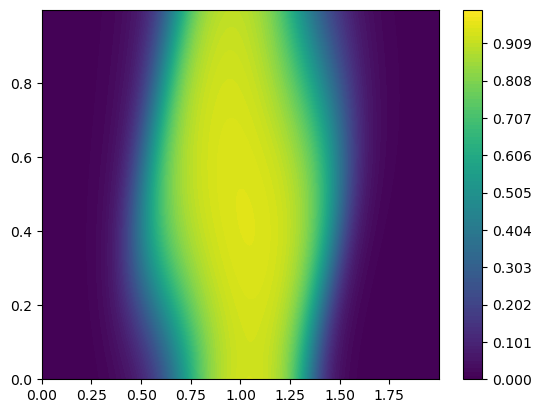

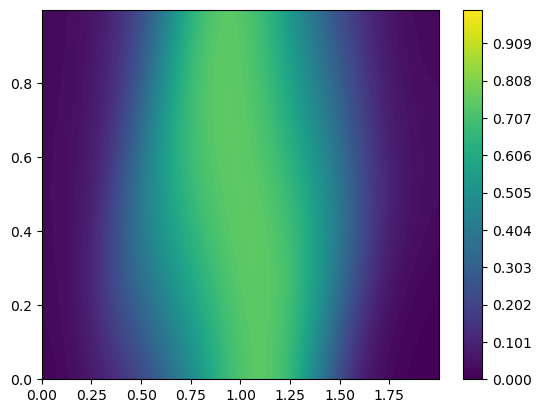

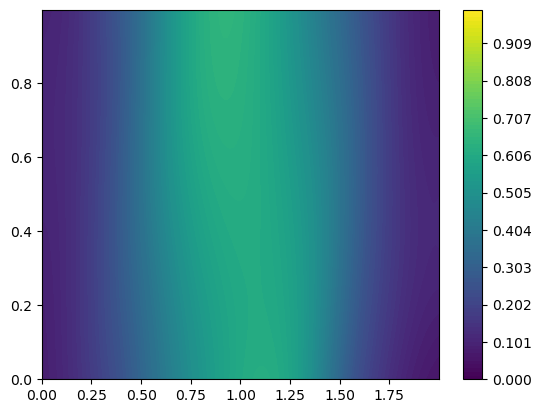

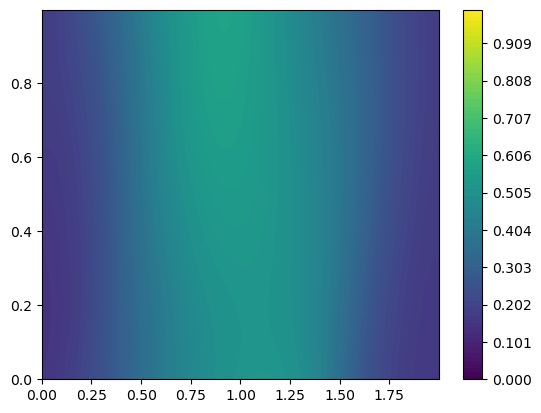

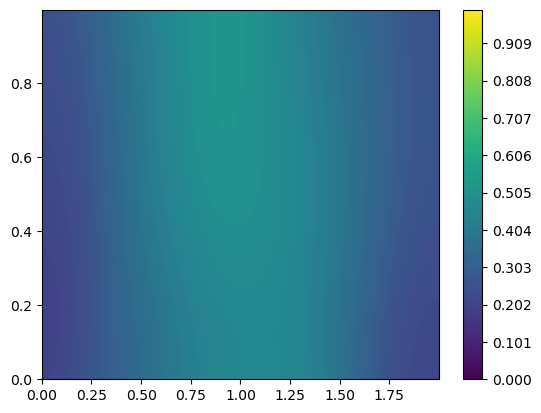

<Figure size 640x480 with 0 Axes>

In [19]:
# you have cuda it trains, otherwise it loads
if torch.cuda.is_available():
    device = torch.device("cuda")
    dtype = torch.float
    # Model and optimization 
    model4 = PINN(3)
    model4.to(device=device,dtype=dtype)
    model4.train()
    model4.load_state_dict(torch.load("model_circle_fem.pt",map_location=device))
    model4 = train(model4,boundary_loss_fem,physical_loss,epochs=1000,lr=0.00001)
    torch.save(model4.state_dict(),"model_circle_fem_finetuned.pt")
else:
    model4 = PINN(3)
    model4.load_state_dict(torch.load("model_circle_fem.pt",map_location=torch.device('cpu')))

for timestep in np.linspace(0,100,5,endpoint=True):
        #rescaling time for NN
        plot_timestep(model4,timestep/600,device=device,dtype=dtype)

## Using FNOs on thermal diffusion problem
* Step 1: making a dataset with multiple initial condition with Neuman boundary conditions
* Step 2: Training the model
* Step 3 testing on a training set and a brand new sample

In [20]:
import torch
from torch.func import grad
from modulus.models.fno import FNO
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from Muscat.FE.Integration import IntegrateGeneral
from Muscat.Containers.ConstantRectilinearMeshTools import CreateConstantRectilinearMesh
from Muscat.Containers.MeshCreationTools import MeshToSimplex
from Muscat.FE.Spaces.FESpaces import LagrangeSpaceGeo
from Muscat.FE.DofNumbering import ComputeDofNumbering
from Muscat.FE.SymWeakForm import GetField, GetTestField, Gradient
from Muscat.FE.Fields.FEField import FEField
from Muscat.Containers.Filters.FilterObjects import ElementFilter
import numpy as np
from tqdm import tqdm
import pickle



def vectorize_kernel(kernel):
    """
    Kernel Decorator that vectorises the computation of the kernel: \mathbb{R}^n \times \mathbb{R}^m \mapsto \R
    It can be used on any kernel, ie even the kernel on which we applied an operator
    """
    def decorated(x1,x2,**kwargs):
        # flattening any extra dimension
        X1 = x1.view(-1,x1.shape[-1])
        X2 = x2.view(-1,x2.shape[-1])
        # broadcasting for computing gram matrix and flattenning for using vectorization
        X1_broad = torch.broadcast_to(X1.unsqueeze(1),(X1.shape[0],X2.shape[0],X1.shape[1])).reshape(-1,x1.shape[-1])
        X2_broad = torch.broadcast_to(X2.unsqueeze(0),(X1.shape[0],X2.shape[0],X2.shape[1])).reshape(-1,x2.shape[-1])
        # vectorization and compuation of gram matrix
        result = torch.vmap(lambda x,y: kernel(x,y,**kwargs),in_dims=(0,0))(X1_broad,X2_broad)
        return result.view(*(x1.shape[:-1]),*(x2.shape[:-1]))
    return decorated

def rationnal_quadratic_kernel(x,y,lengthscale=None,alpha=None):
    d2 = torch.sum((x/lengthscale-y/lengthscale)**2)
    return (1+ d2/(2*alpha))**(-alpha)


# Neuman boundary conditions left operator for kernels
def left_boundary(func,x,y,normals_x,**kwargs):
    """
    Arguments: x (torch.tensor) first position tensor where we want to compute the kernel (the operator is applied on this coordinate)
               y (torch.tensor) second position tensor where we want to compute the kernel
               normals_x (torch.tensor) normals of the positions x (necessary for computing the operator)
    """
    grads =  grad(lambda h,l: func(h,l,**kwargs),argnums=0)(x,y) # size output x output x input
    return torch.sum(grads*normals_x,dim=-1)

# Neuman boundary conditions right operator for kernels
def right_boundary(func,x,y,normals_y,**kwargs):
    """
    Arguments: x (torch.tensor) first position tensor where we want to compute the kernel 
               y (torch.tensor) second position tensor where we want to compute the kernel (the operator is applied on this coordinate)
               normals_y (torch.tensor) normals of the positions x (necessary for computing the operator)
               lbd,mu (floats) Lame coefficients for elasticity
    """
    grads =  grad(lambda h,l: func(h,l,**kwargs),argnums=1)(x,y) # size output x output x input
    return torch.sum(grads*normals_y,dim=-1)
    
# Neuman boundary condition for kernels applied either on the right and/or left of the kernel
# Small specificity: the decorator assumes that the normals are stored along side the dimensions on which you want to apply the operator
# For instance if you want to apply the operator on the left x needs to be of shape [N,4] and y [M,2] with the 2 last dimension of x
# containing the normals. If you want to apply it on both right and left then x needs to be of shape [N,4] and y [M,4]
def boundary_operator(left=True,right=True):
    def decorator(kernel):
        def decorated(x,y,**kwargs):
            if left and right:
                y,normals_y = y[:-2],y[-2:]
                x,normals_x = x[:-2],x[-2:]
                output = right_boundary(lambda h,l: left_boundary(kernel,h,l,normals_x,**kwargs),x,y,normals_y)
                return output
            elif left:
                x,normals_x = x[:-2],x[-2:]
                output = left_boundary(kernel,x,y,normals_x,**kwargs)
                return output
            elif right:
                y,normals_y = y[:-2],y[-2:]
                output = right_boundary(kernel,x,y,normals_y,**kwargs)
                return output
            else:
                return kernel(x,y,**kwargs)
        return decorated
    return decorator  

def get_sampler(device):
    N_neuman=80
    perimeter = torch.linspace(0,6,N_neuman,device=device)
    points_neuman = torch.zeros(N_neuman,2,device=device)
    second_member_neuman = torch.zeros(N_neuman,device=device)
    normals = torch.zeros(N_neuman,2,device=device)

    # y=0, x \in [0,2] 
    local_values = perimeter[perimeter<2]
    points_neuman[perimeter<2]=torch.stack((local_values,torch.zeros_like(local_values)),dim=1)
    normals[perimeter<2]= torch.tensor([0.,-1.],device=device).repeat(local_values.shape[0],1)
    # y \in [0,1], x=2 
    local_values = perimeter[(perimeter<3)*(perimeter>2)]-2
    points_neuman[(perimeter<3)*(perimeter>2)]=torch.stack((torch.ones_like(local_values)*2,local_values),dim=1)
    normals[(perimeter<3)*(perimeter>2)]= torch.tensor([1.,0.],device=device).repeat(local_values.shape[0],1)

    # y=1, x \in [0,2] 
    local_values = perimeter[(perimeter>3)*(perimeter<5)] -3
    points_neuman[(perimeter>3)*(perimeter<5)]=torch.stack((local_values,torch.ones_like(local_values)),dim=1)
    normals[(perimeter>3)*(perimeter<5)]= torch.tensor([0.,1.],device=device).repeat(local_values.shape[0],1)

    # y\in [0,1], x=0 
    local_values = perimeter[perimeter>5] -5
    points_neuman[perimeter>5]=torch.stack((torch.zeros_like(local_values),local_values),dim=1)
    normals[perimeter>5]= torch.tensor([-1.,0.],device=device).repeat(local_values.shape[0],1)
    
    lengthscale=torch.ones(2,device=device)*0.17
    alpha=0.8
    krnl_kwargs = {
        "lengthscale":lengthscale,
        "alpha":alpha
        
    }
    krnl = lambda x,z: rationnal_quadratic_kernel(x,z,**krnl_kwargs)


    LLK = vectorize_kernel(boundary_operator(left=True,right=True)(krnl))(torch.cat((points_neuman,normals),dim=-1),torch.cat((points_neuman,normals),dim=-1))
    u = torch.linalg.solve(LLK,second_member_neuman)
    sampling=87
    x,y = torch.meshgrid(torch.linspace(0,2,2*sampling+1),torch.linspace(0,1,sampling+1),indexing="ij")

    grid = torch.stack((x,y),dim=-1).view(-1,2)
    grid = grid.to(device=device)
    L_K = vectorize_kernel(boundary_operator(left=False,right=True)(krnl))(grid,torch.cat((points_neuman,normals),dim=-1))
    LK = vectorize_kernel(boundary_operator(left=True,right=False)(krnl))(torch.cat((points_neuman,normals),dim=-1),grid)
    sigma = vectorize_kernel(krnl)(grid,grid)- L_K@torch.linalg.solve(LLK,LK)
    m = torch.distributions.MultivariateNormal(L_K@u, sigma+0.00004*torch.eye(sigma.shape[0],device=device))
    return m


 

def integrate_weight_and_stiffness(btmesh):
    """
    Function that builds stiffness and weight matrix using L1 elements and MuscatIntegrator
        Arguments: MuscatMesh that is composed of triangles and points
    
    """
    d=0.001
    space = LagrangeSpaceGeo
    numbering = ComputeDofNumbering(btmesh,space,fromConnectivity=True)
    # numbering.GetDofOfPoint(point index) -> dof index
    sdim=1
    dofs= ["T"]
    spaces = [space]
    numberings = [numbering]

    # Creating weak formulation for the stiffness matrix
    T = GetField("T",sdim)
    Tt = GetTestField("T",sdim)
    wform_stiff = Gradient(T).T@ Gradient(Tt)

    # Creating weak form for the weight matrix

    wform= T.T*Tt
    elemfilt = ElementFilter(dimensionality=2)
    # integrating mass matrix
    unknownFields = [FEField(dofs[n],mesh=btmesh,space=spaces[n],numbering=numberings[n]) for n in range(len(dofs)) ]
    mass_matrix,_ = IntegrateGeneral(mesh=btmesh,wform=wform, constants={}, fields=[],unknownFields = unknownFields,
                        elementFilter=elemfilt )
    # Integrating stiffness matrix
    stiffness_matrix, _ = IntegrateGeneral(mesh=btmesh,wform=wform_stiff, constants={}, fields=[],unknownFields = unknownFields,
                        elementFilter=elemfilt )
    return mass_matrix, d*stiffness_matrix

def running_simulation():
    device = torch.device("cuda")
    # building mesh
    size=87
    btmesh = CreateConstantRectilinearMesh([size*2+1,size+1], [0,0], [1/size, 1/size])
    # casting to simplex
    MeshToSimplex(btmesh,inPlace=True)
    sampler = get_sampler(device)
    
    # displaying what the sampler does
    sample = sampler.sample()
    x,y = torch.meshgrid(torch.linspace(0,2,2*size+1),torch.linspace(0,1,size+1),indexing="ij")
    plt.figure(figsize=(24,17))
    plt.contourf(x.numpy(),y.numpy(),sample.cpu().numpy().reshape(87*2+1,87+1),levels=np.linspace(-3,3,20))
    plt.contour(x.numpy(),y.numpy(),sample.cpu().numpy().reshape(87*2+1,87+1),levels=np.linspace(-3,3,20),colors="k")
    plt.title("Initial condition")
    plt.show()
    
    # building weight matrix and stiffness_matrix
    weight_matrix, stiffness_matrix = integrate_weight_and_stiffness(btmesh)
    weight_matrix= torch.tensor(weight_matrix.todense(),device=device)
    stiffness_matrix= torch.tensor(stiffness_matrix.todense(),device=device)
    master_dataset = []
    for _ in range(10):
        # If we solve for a batch of 300 this causes numerical errors
        # Therefore we loop 10 times, 100 initial conditions
        u = sampler.sample([100]).to(dtype=torch.double)
        dt=1
        dataset=[u.cpu()]
        for i in tqdm(range(300)):
            u = torch.linalg.solve(weight_matrix+dt*stiffness_matrix,weight_matrix@u.T).T
            dataset.append(u.cpu())
        master_dataset.append(torch.stack(dataset,dim=0))
        
    with open('evolution_thermal.pk', 'wb') as file:
        
        # A new file will be created
        pickle.dump(torch.cat(master_dataset,dim=1), file)
        
        
        
# To generate a dataset execute the running simulation function
# running_simulation()


In [21]:
class ThermalDataset(Dataset):
    def __init__(self, datapath,shape=(87*2+1,87+1)):
        with open(datapath,"rb") as pk_file:
            self.data = pickle.load(pk_file)
        self.timesteps = self.data.shape[0]
        self.initial_conditions = self.data.shape[1]
        self.shape=shape
    def __len__(self):
        return (self.timesteps-1)*self.initial_conditions
    
    def __getitem__(self, idx):
        index_timestep =  idx//self.initial_conditions
        index_initial_condition = idx%self.initial_conditions
        return self.data[index_timestep,index_initial_condition].view(87*2+1,87+1).unsqueeze(0),self.data[index_timestep+1,index_initial_condition].view(87*2+1,87+1).unsqueeze(0)

def train(model,optimizer,dataloader,epochs,device,dtype):
    for epoch in tqdm(range(epochs)):
        for input_field,output_field in dataloader:
            input_field,output_field = input_field.to(device=device,dtype=dtype),output_field.to(device=device,dtype=dtype)
            loss = torch.mean(torch.sum((model(input_field)-output_field)**2,dim=(1,2,3)))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            

def main(save_file,learning_rate,batch_size,number_workers,epochs):

    #The device depends on which cuda device we are
    device = torch.device("cuda")
    dtype = torch.double
    # you can load your own dataset made at the previous step
    dataset = ThermalDataset("evolution_thermal_1.pk")

    model = FNO(
        in_channels=1,
        out_channels=1,
        decoder_layers=1,
        decoder_layer_size=32,
        dimension=2,
        latent_channels=32,
        num_fno_layers=4,
        num_fno_modes=12,
        padding=9,
    )
    model.to(device=device,dtype=dtype)
    optimizer = optim.Adam(model.parameters(),lr=learning_rate)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=number_workers)
    
    train(model,optimizer,dataloader,epochs=epochs,device=device,dtype=dtype)
    torch.save(model.state_dict(),save_file)

# This can run for a long time you don't have a GPU
# main("save_state_dict.pt",learning_rate=0.001,batch_size=32,number_workers=8,epochs=10)

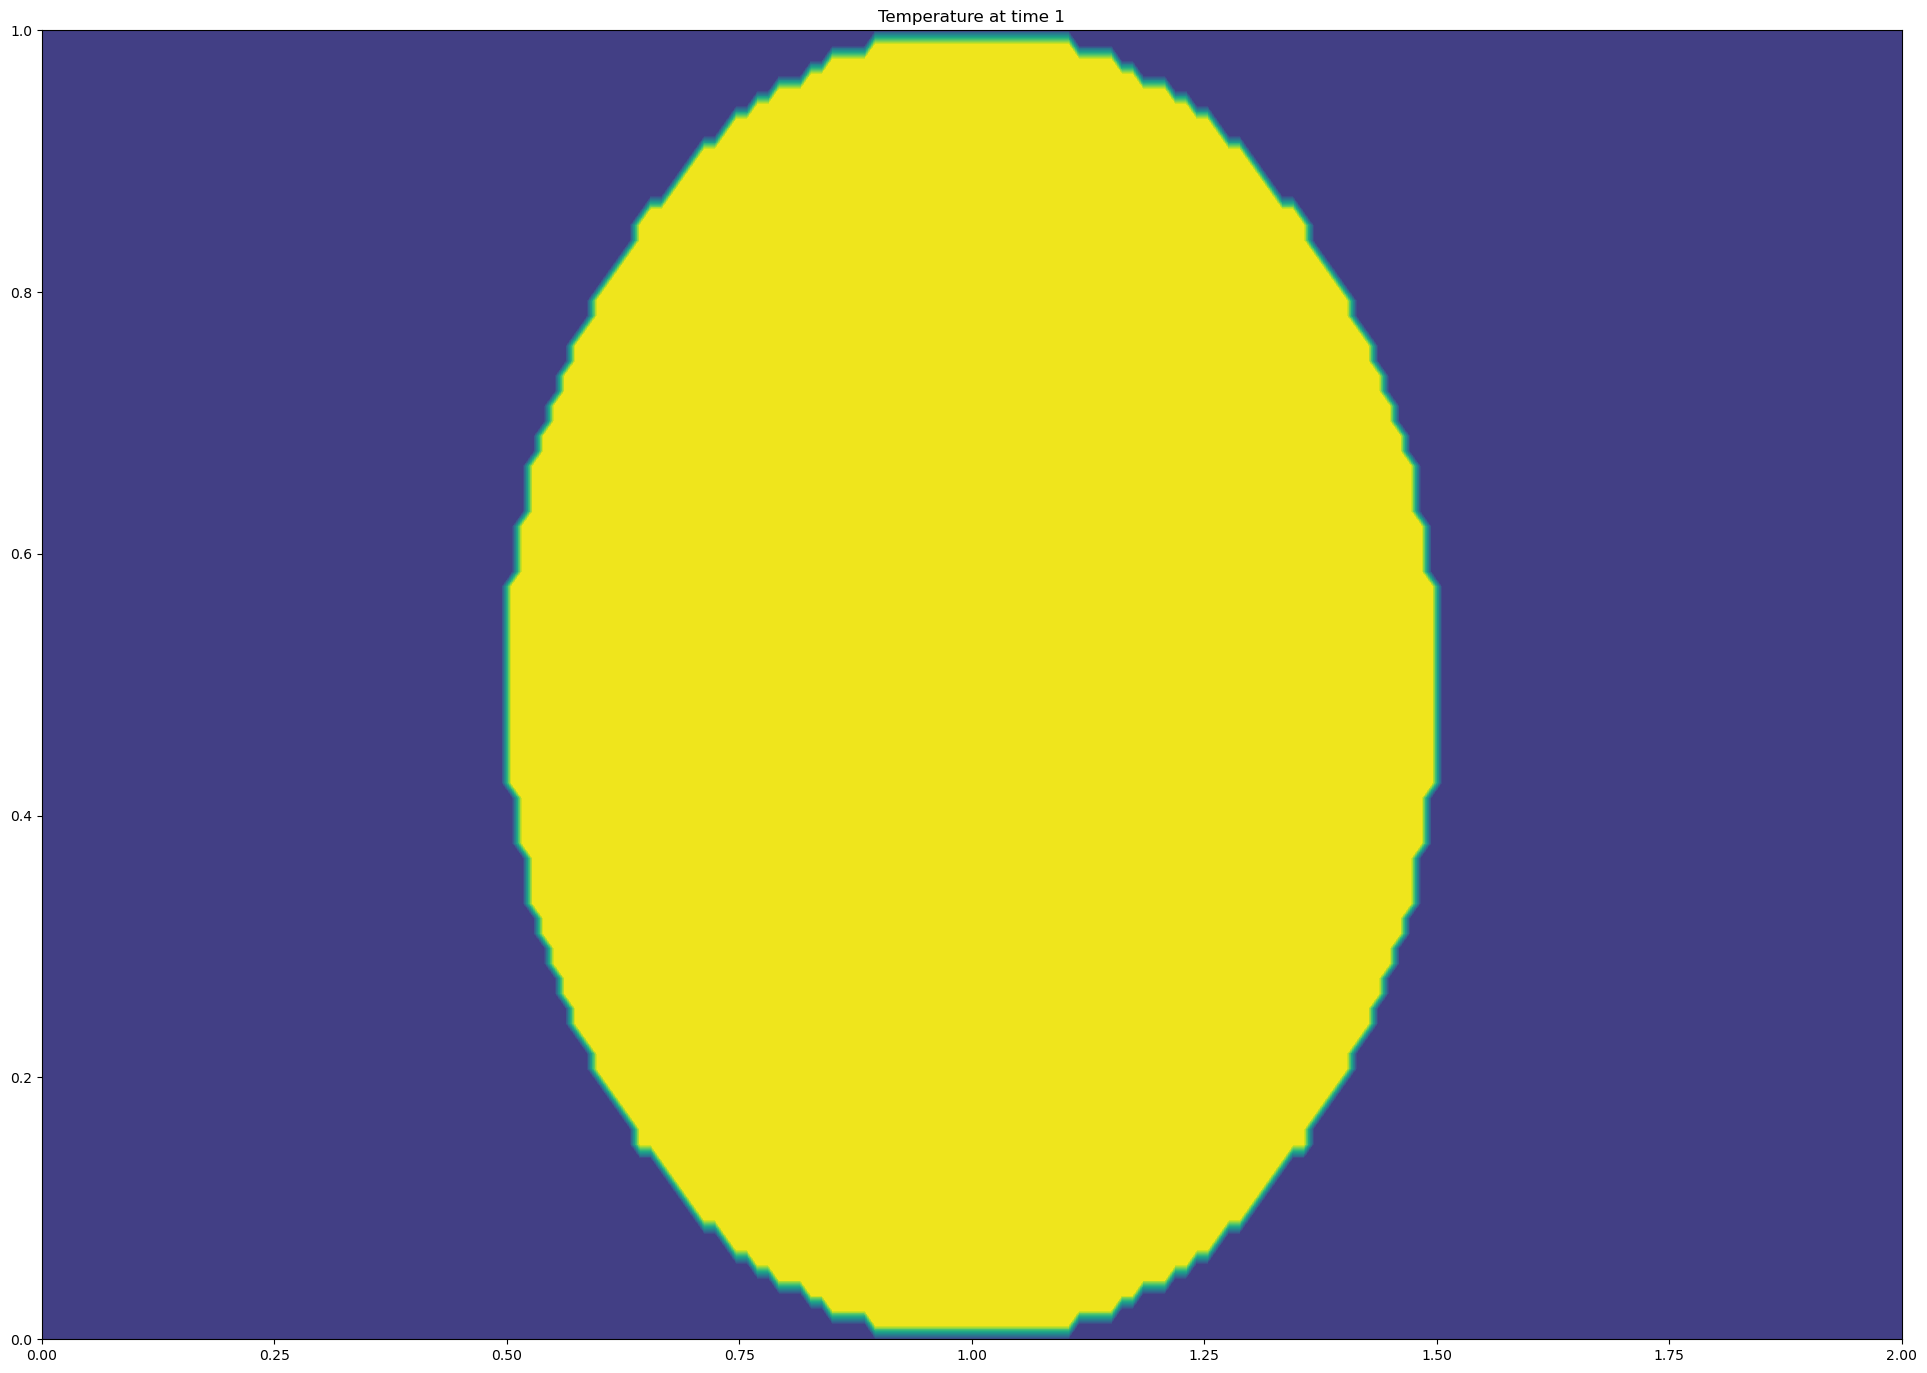

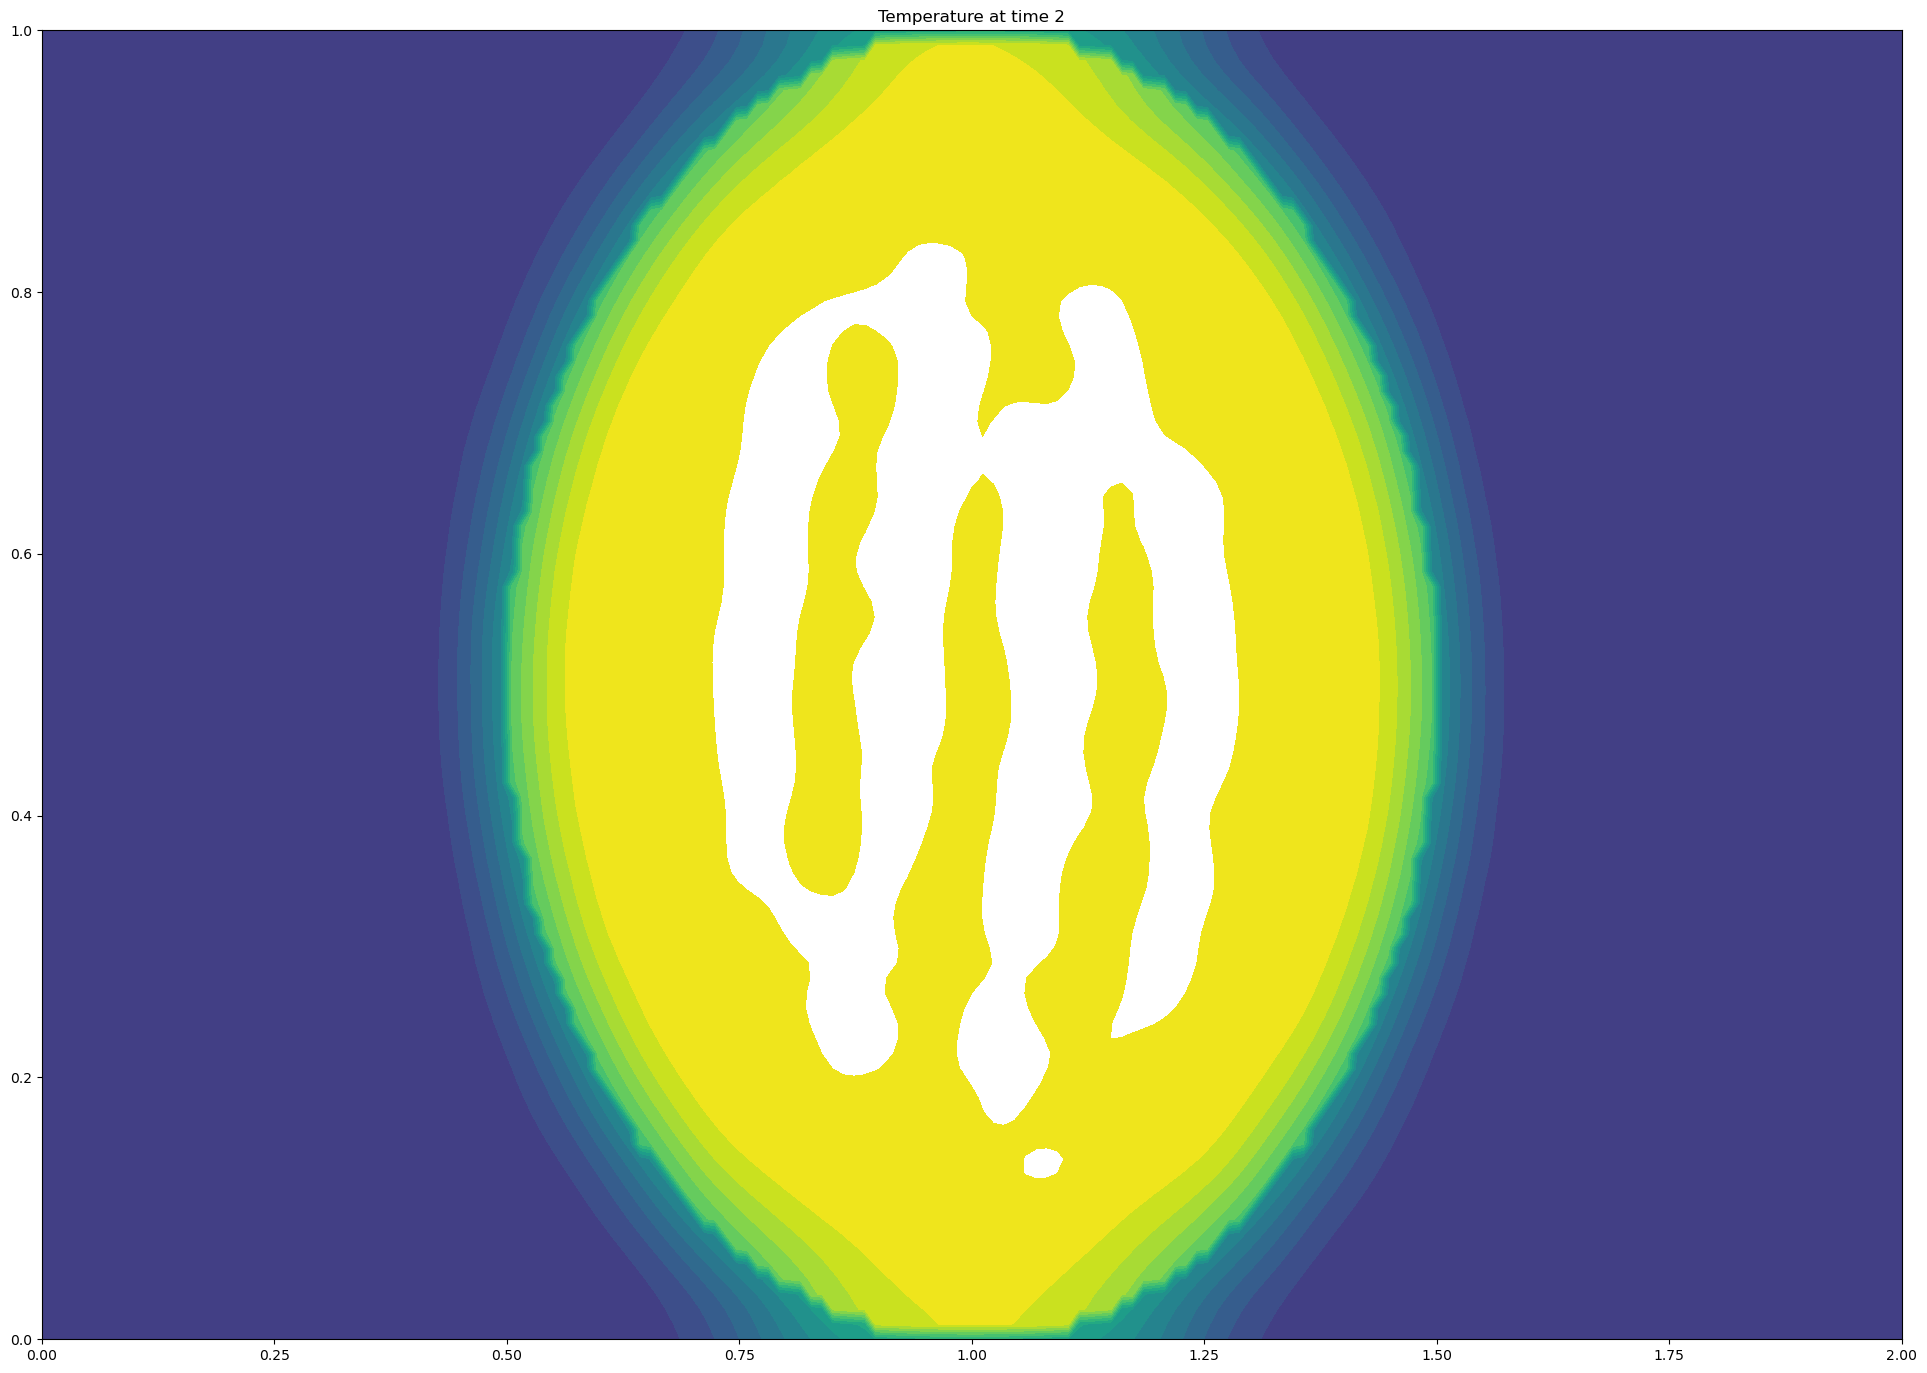

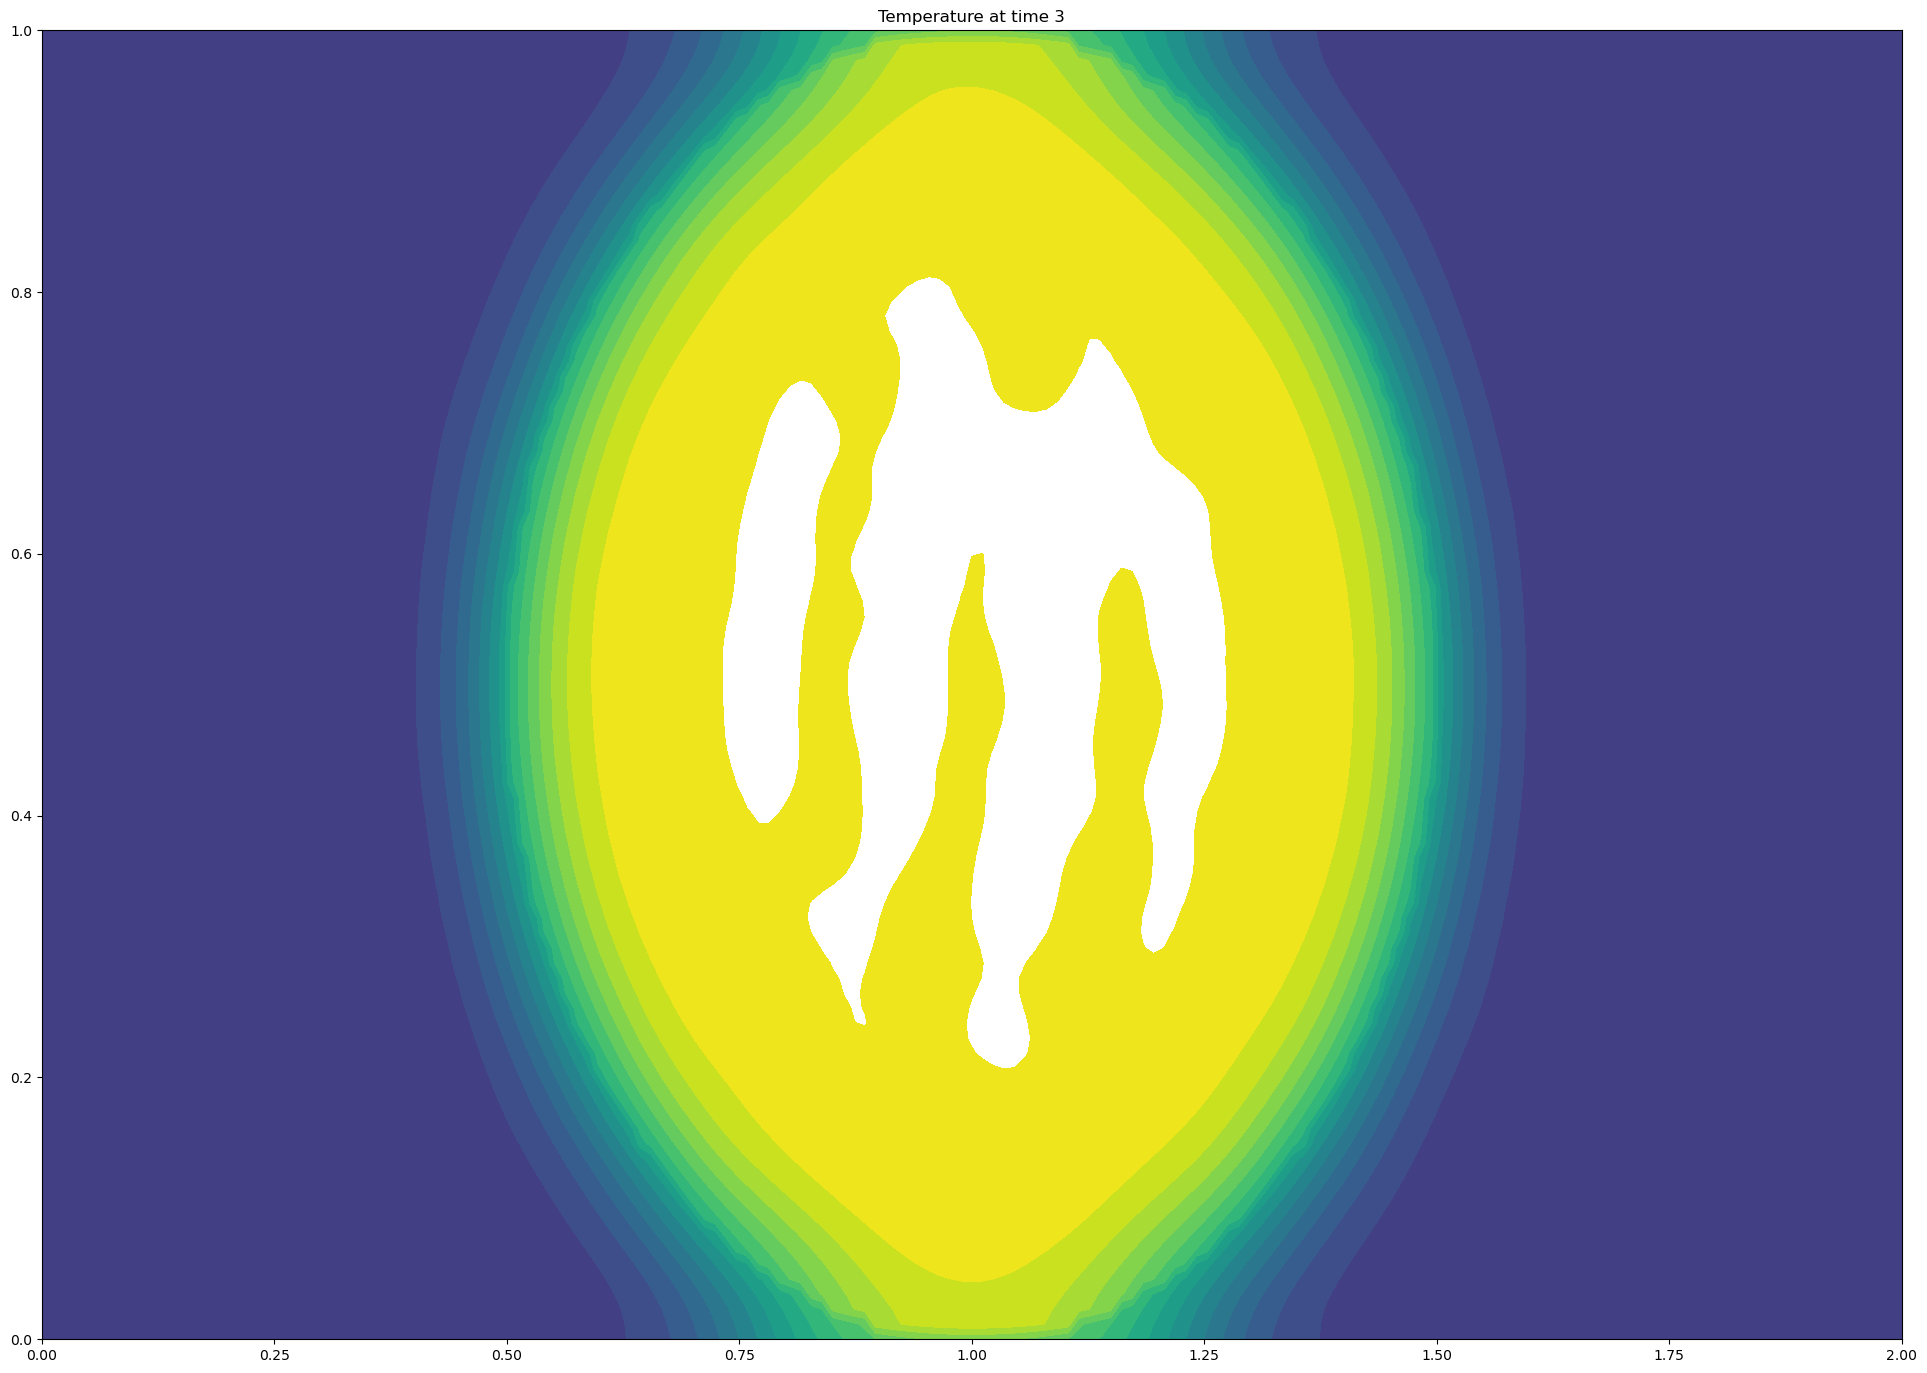

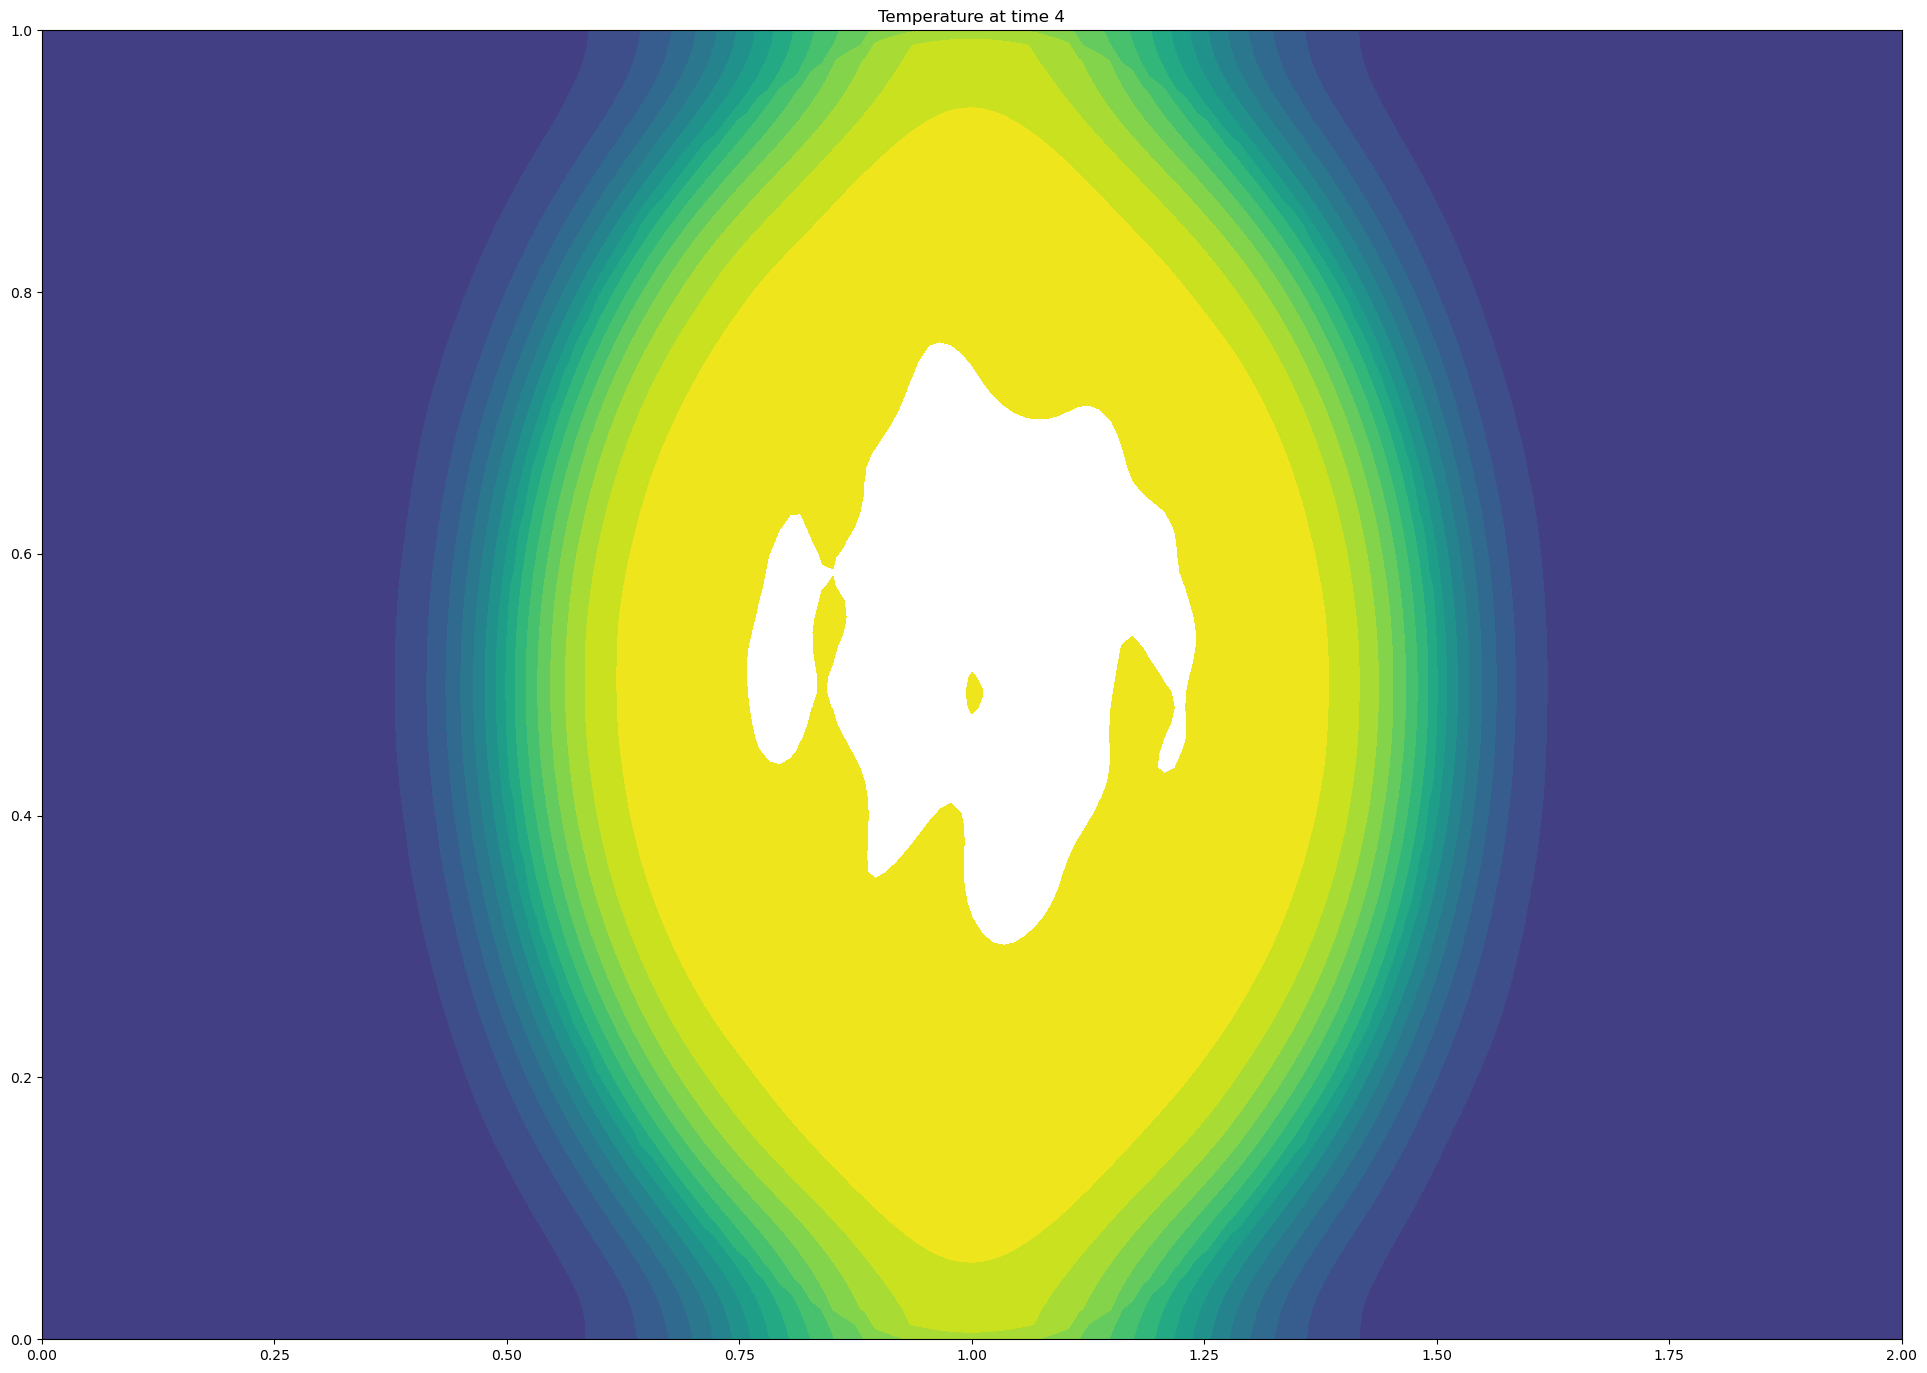

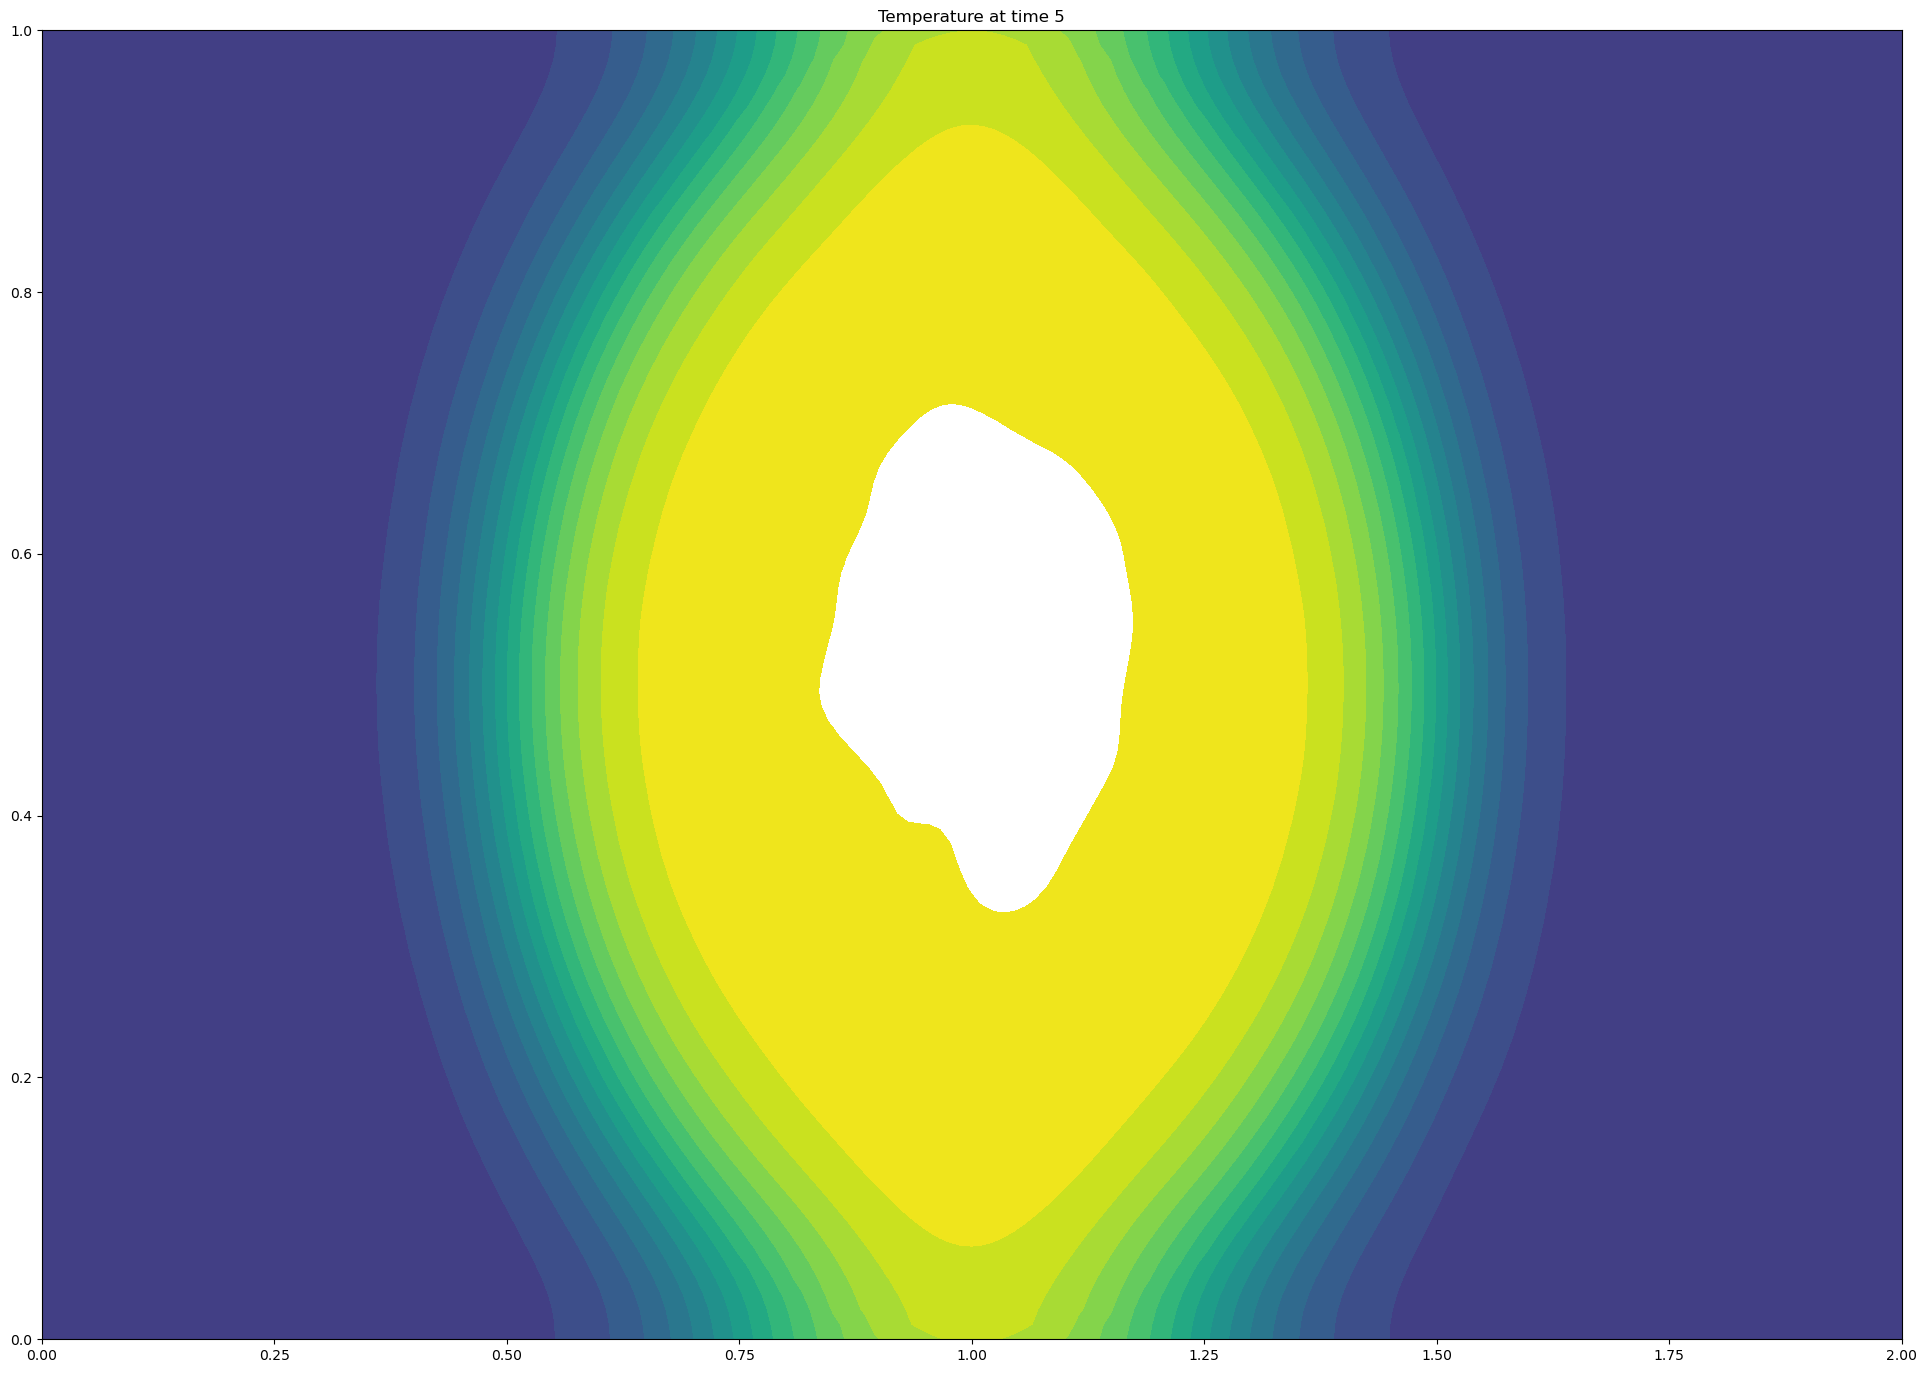

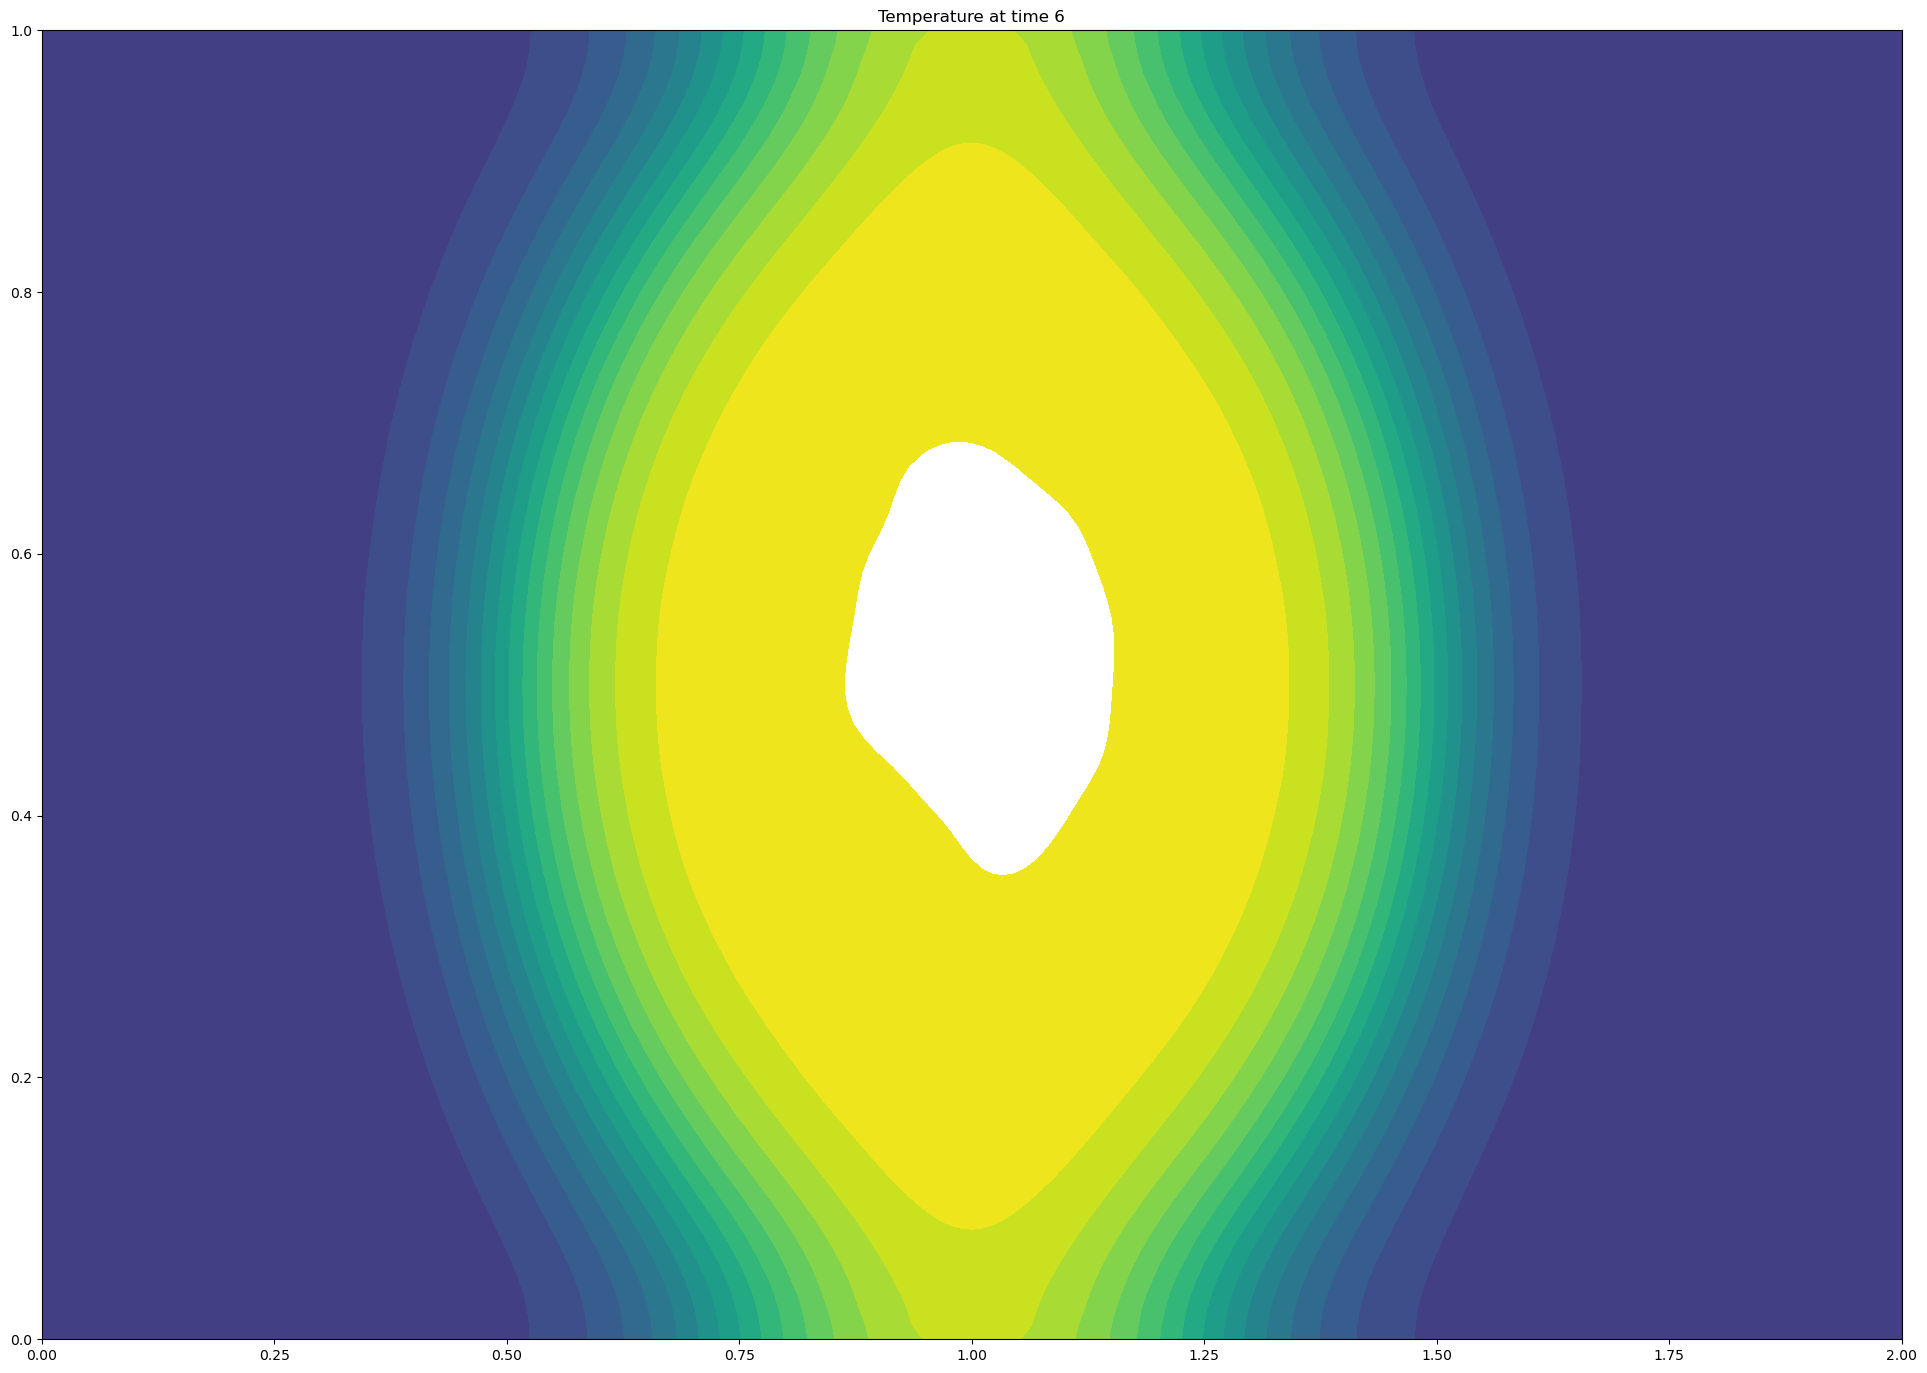

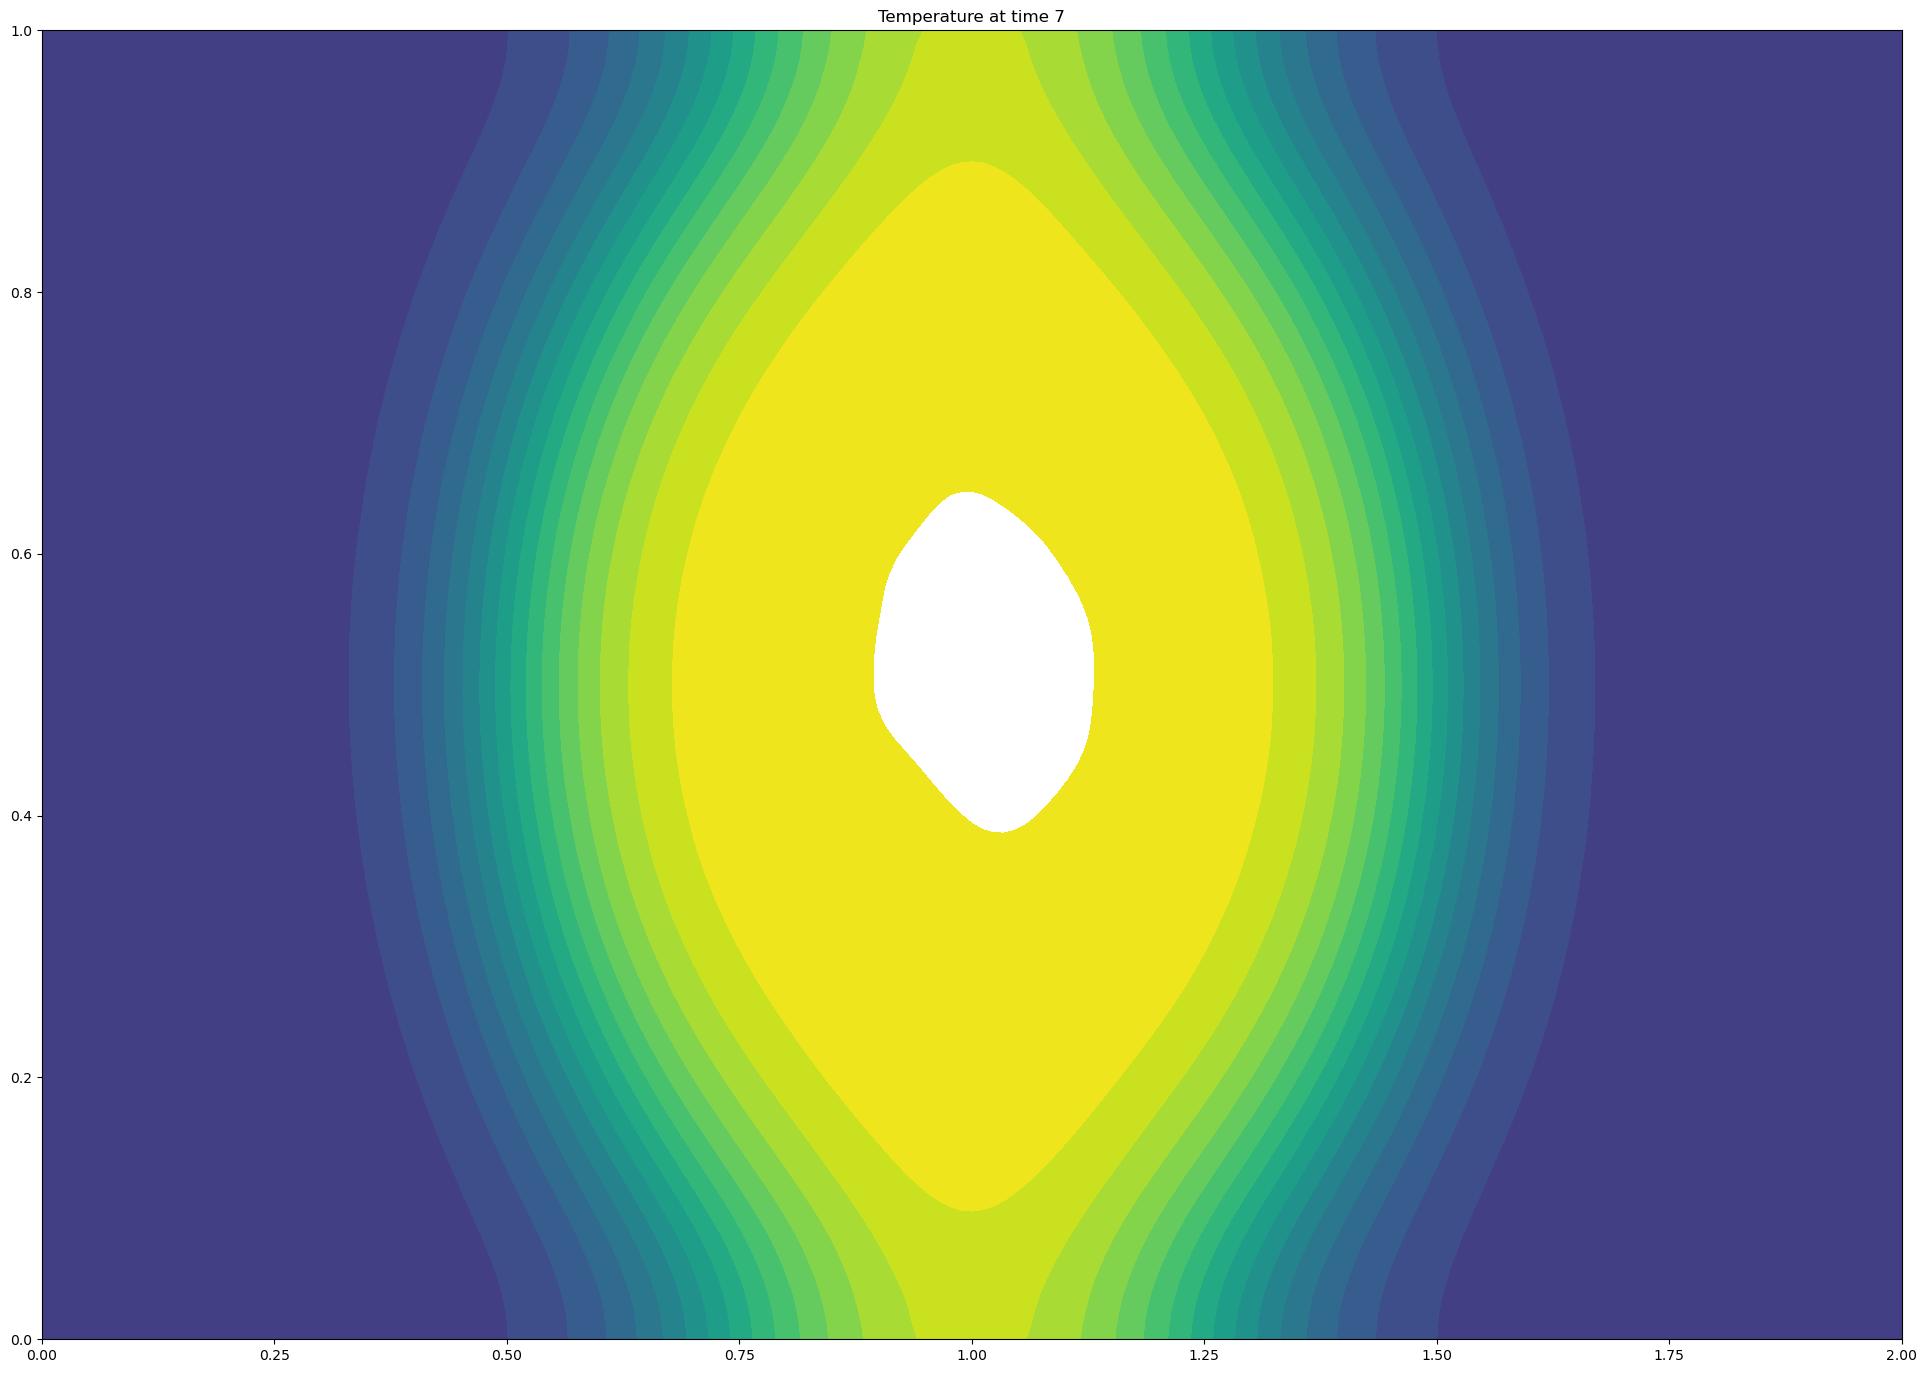

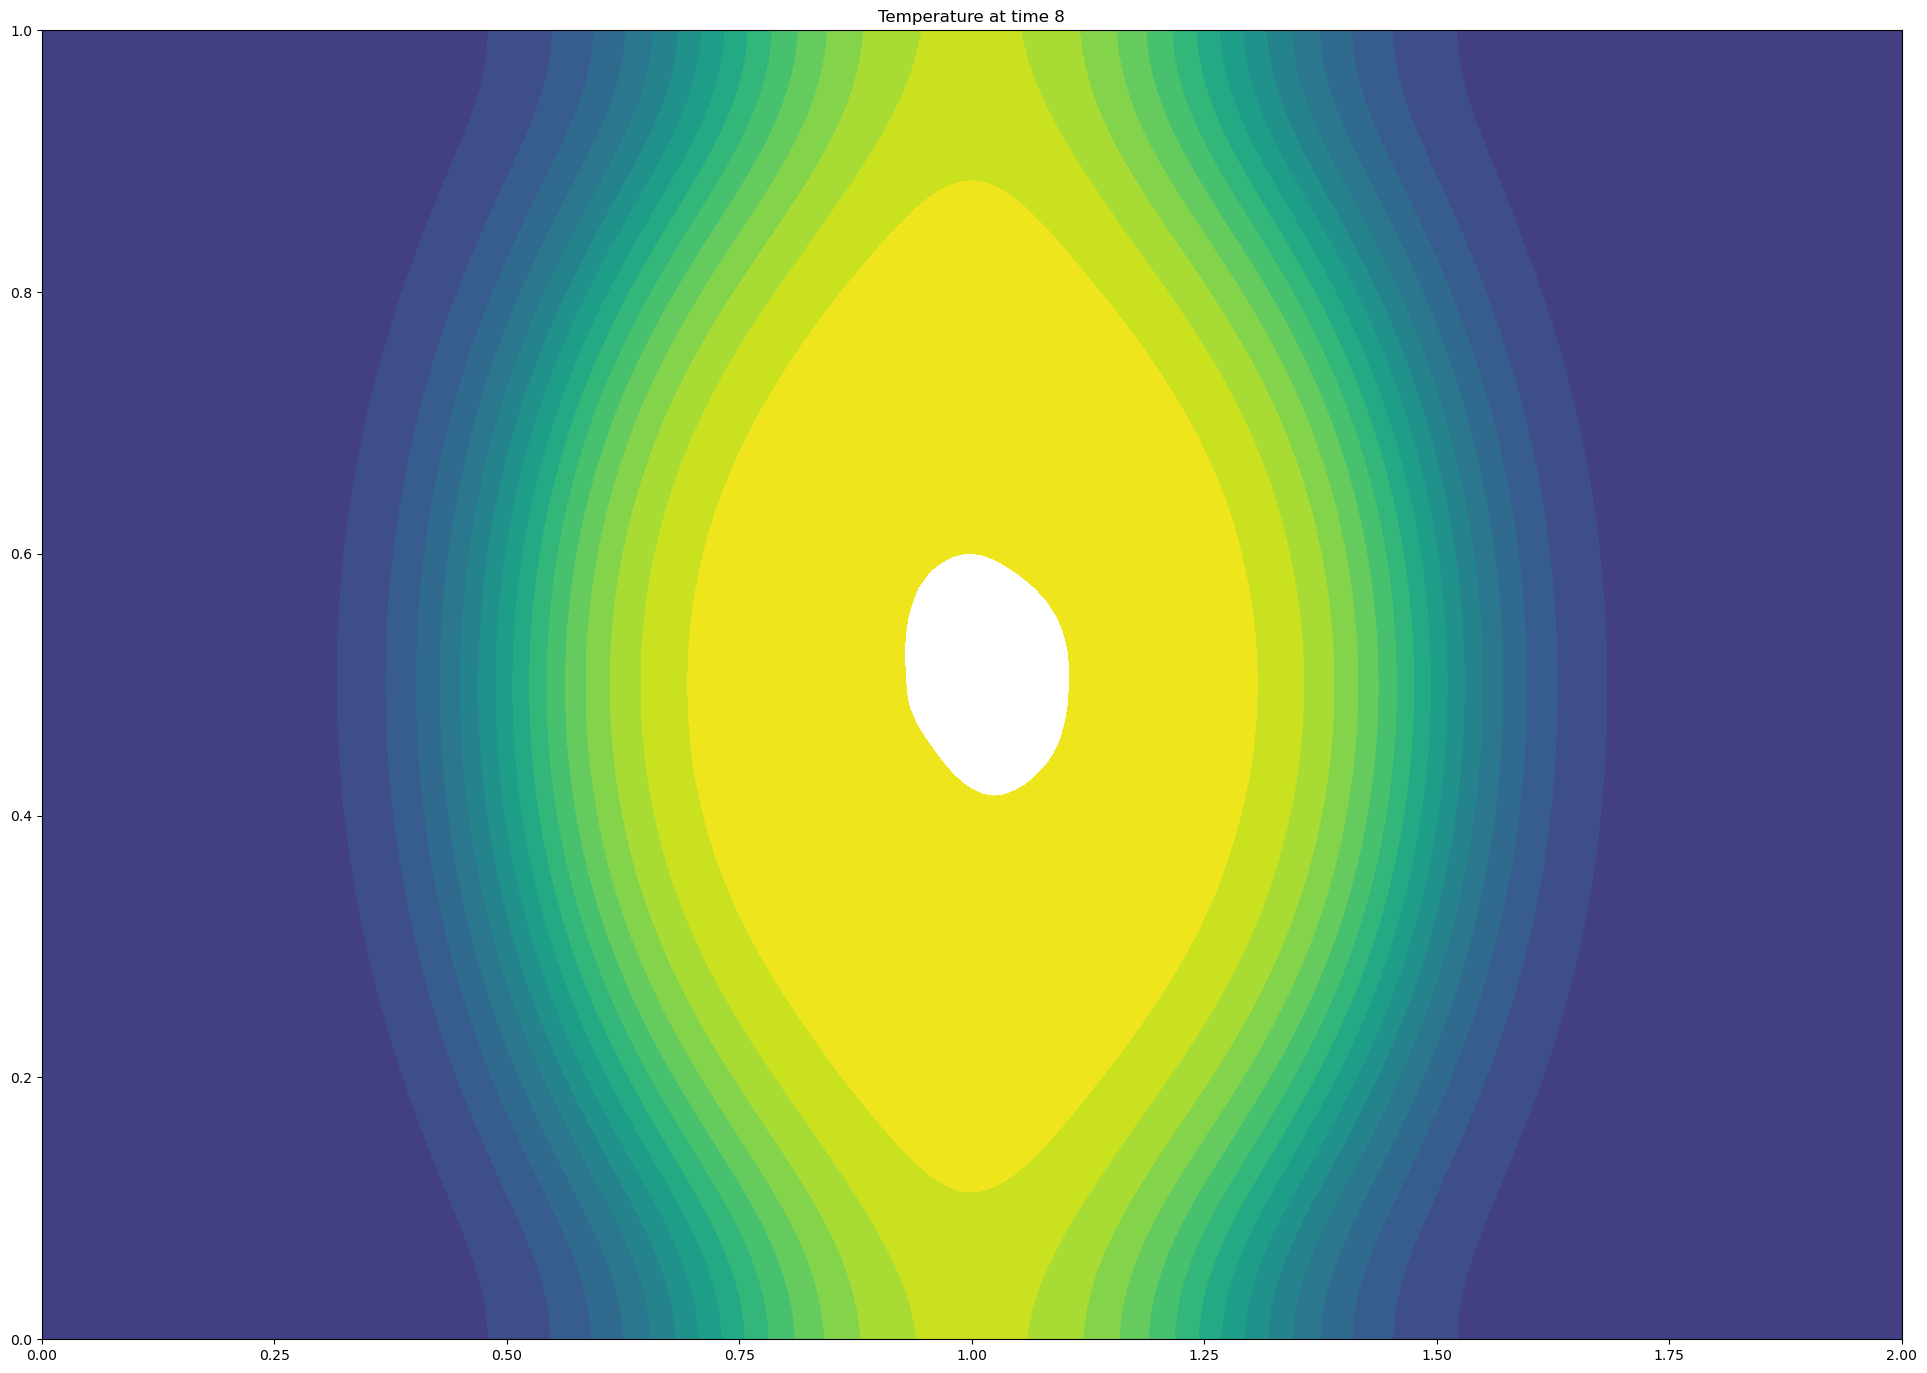

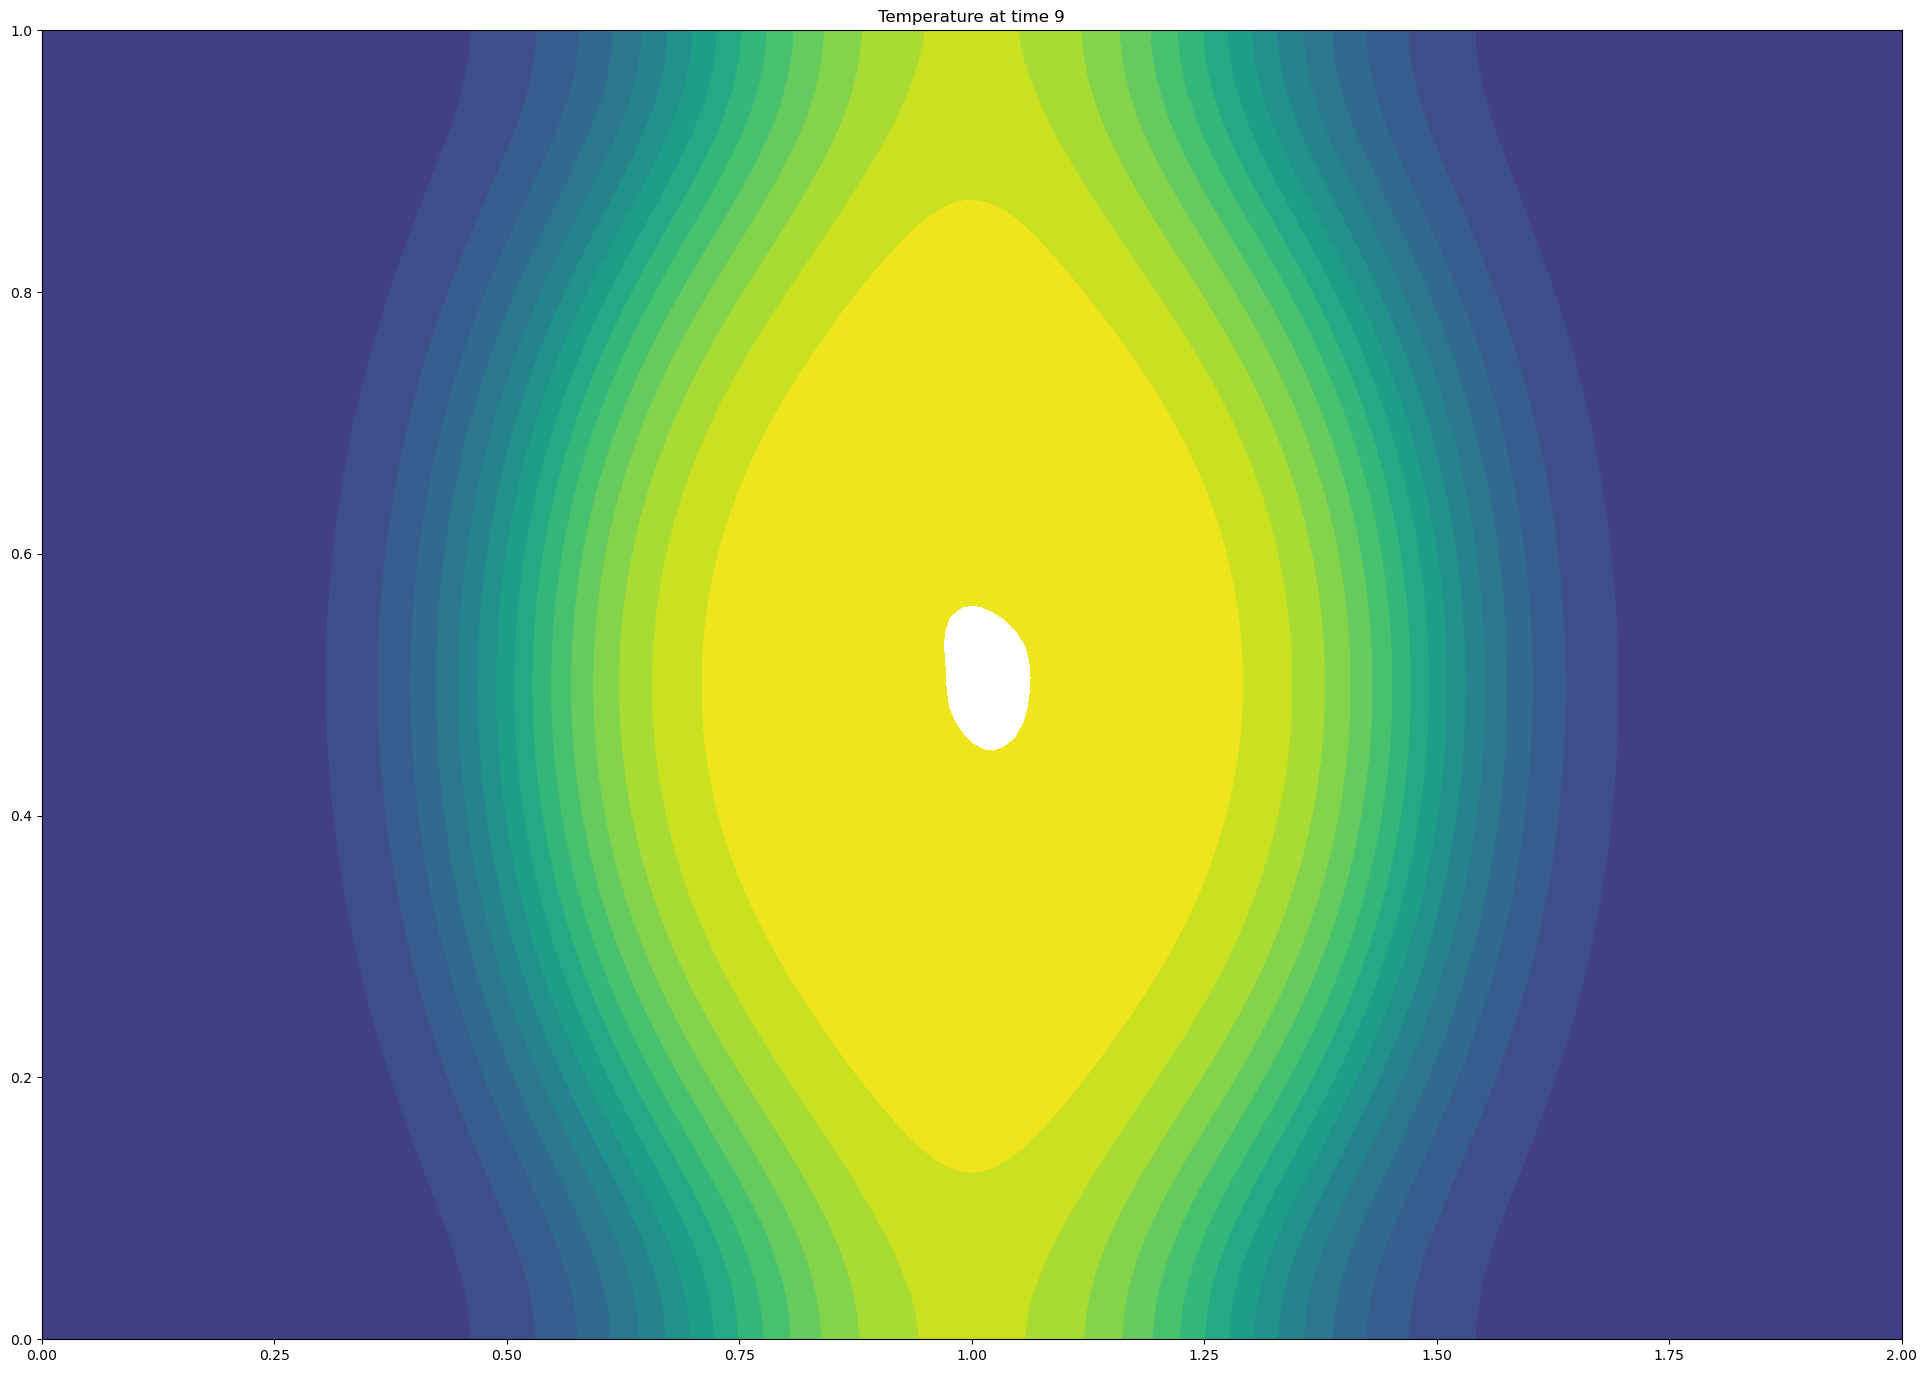

In [22]:
import matplotlib.pyplot as plt
def test_fn(save_file):
    #The device depends on which cuda device we are
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
    dtype = torch.double
    size=87
    btmesh = CreateConstantRectilinearMesh([size*2+1,size+1], [0,0], [1/size, 1/size])

    initial_state = np.zeros(btmesh.GetNumberOfNodes())
    initial_state[((btmesh.nodes[:,0]-1)**2+(btmesh.nodes[:,1]-0.5)**2)<0.25]=1
    initial_state = initial_state.reshape(87*2+1,87+1)
    model = FNO(
        in_channels=1,
        out_channels=1,
        decoder_layers=1,
        decoder_layer_size=32,
        dimension=2,
        latent_channels=32,
        num_fno_layers=4,
        num_fno_modes=12,
        padding=9,
    )
    model.to(device=device,dtype=dtype)
    size=87
    x,y = torch.meshgrid(torch.linspace(0,2,2*size+1),torch.linspace(0,1,size+1),indexing="ij")
    model.load_state_dict(torch.load(save_file,map_location=device))
    s = torch.tensor(initial_state)
    s_pred = s.clone().to(device=device,dtype=dtype).unsqueeze(0).unsqueeze(0)
    for i in range(1,10):

        plt.figure(figsize=(24,17))
        plt.contourf(x.numpy(),y.numpy(),s_pred.squeeze().cpu().numpy().reshape(87*2+1,87+1),levels=np.linspace(-0.2,1.,20))
        plt.title("Temperature at time {}".format(i))


        with torch.no_grad():
            s_pred = model(s_pred)



# Testing with pretrained model         
test_fn("save_state_dict_ddp_12000.pt")

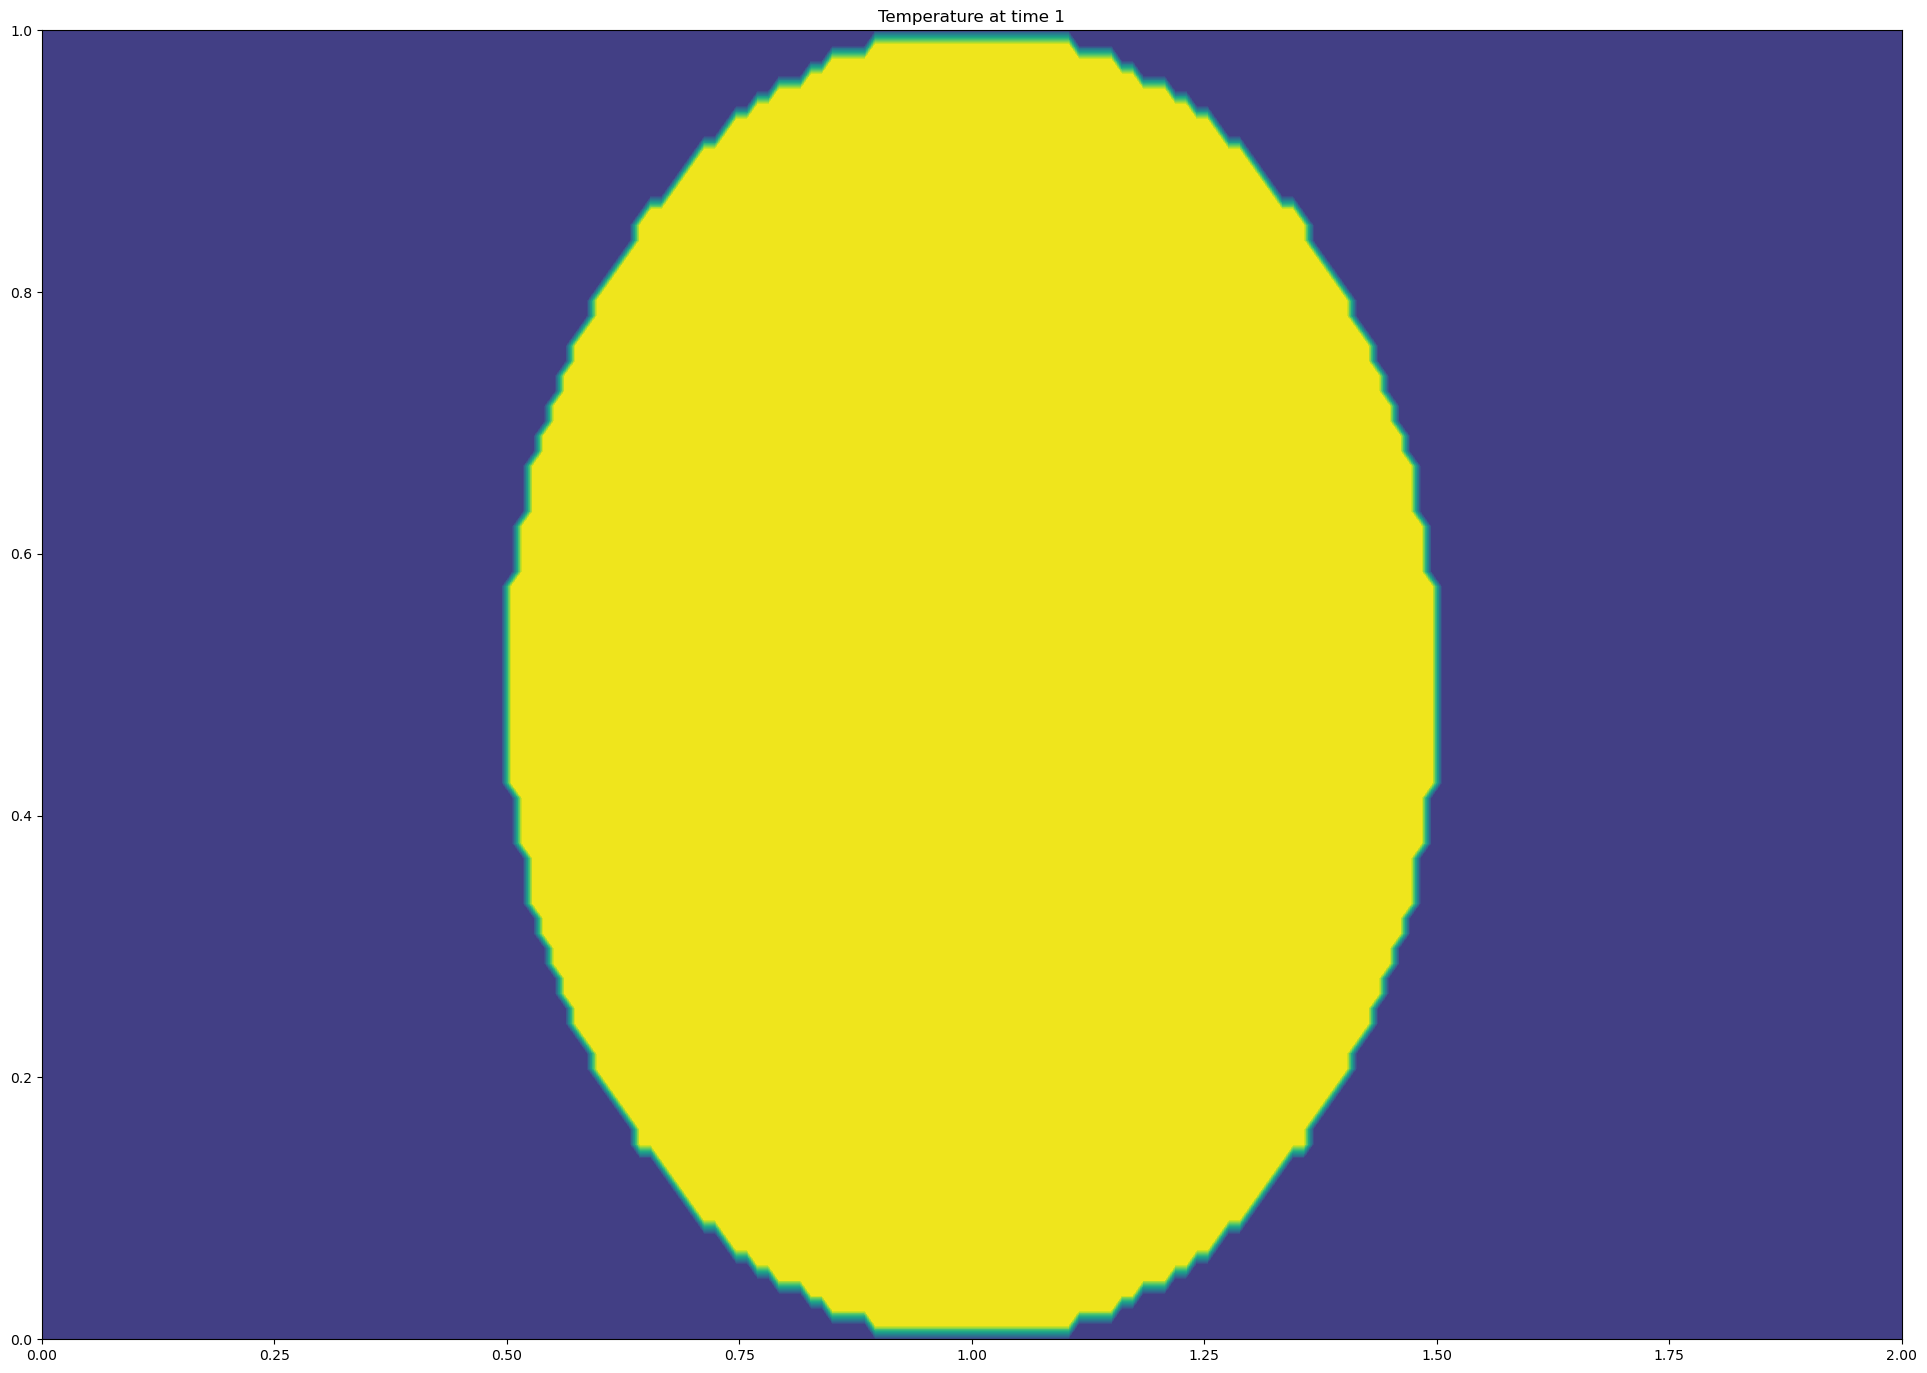

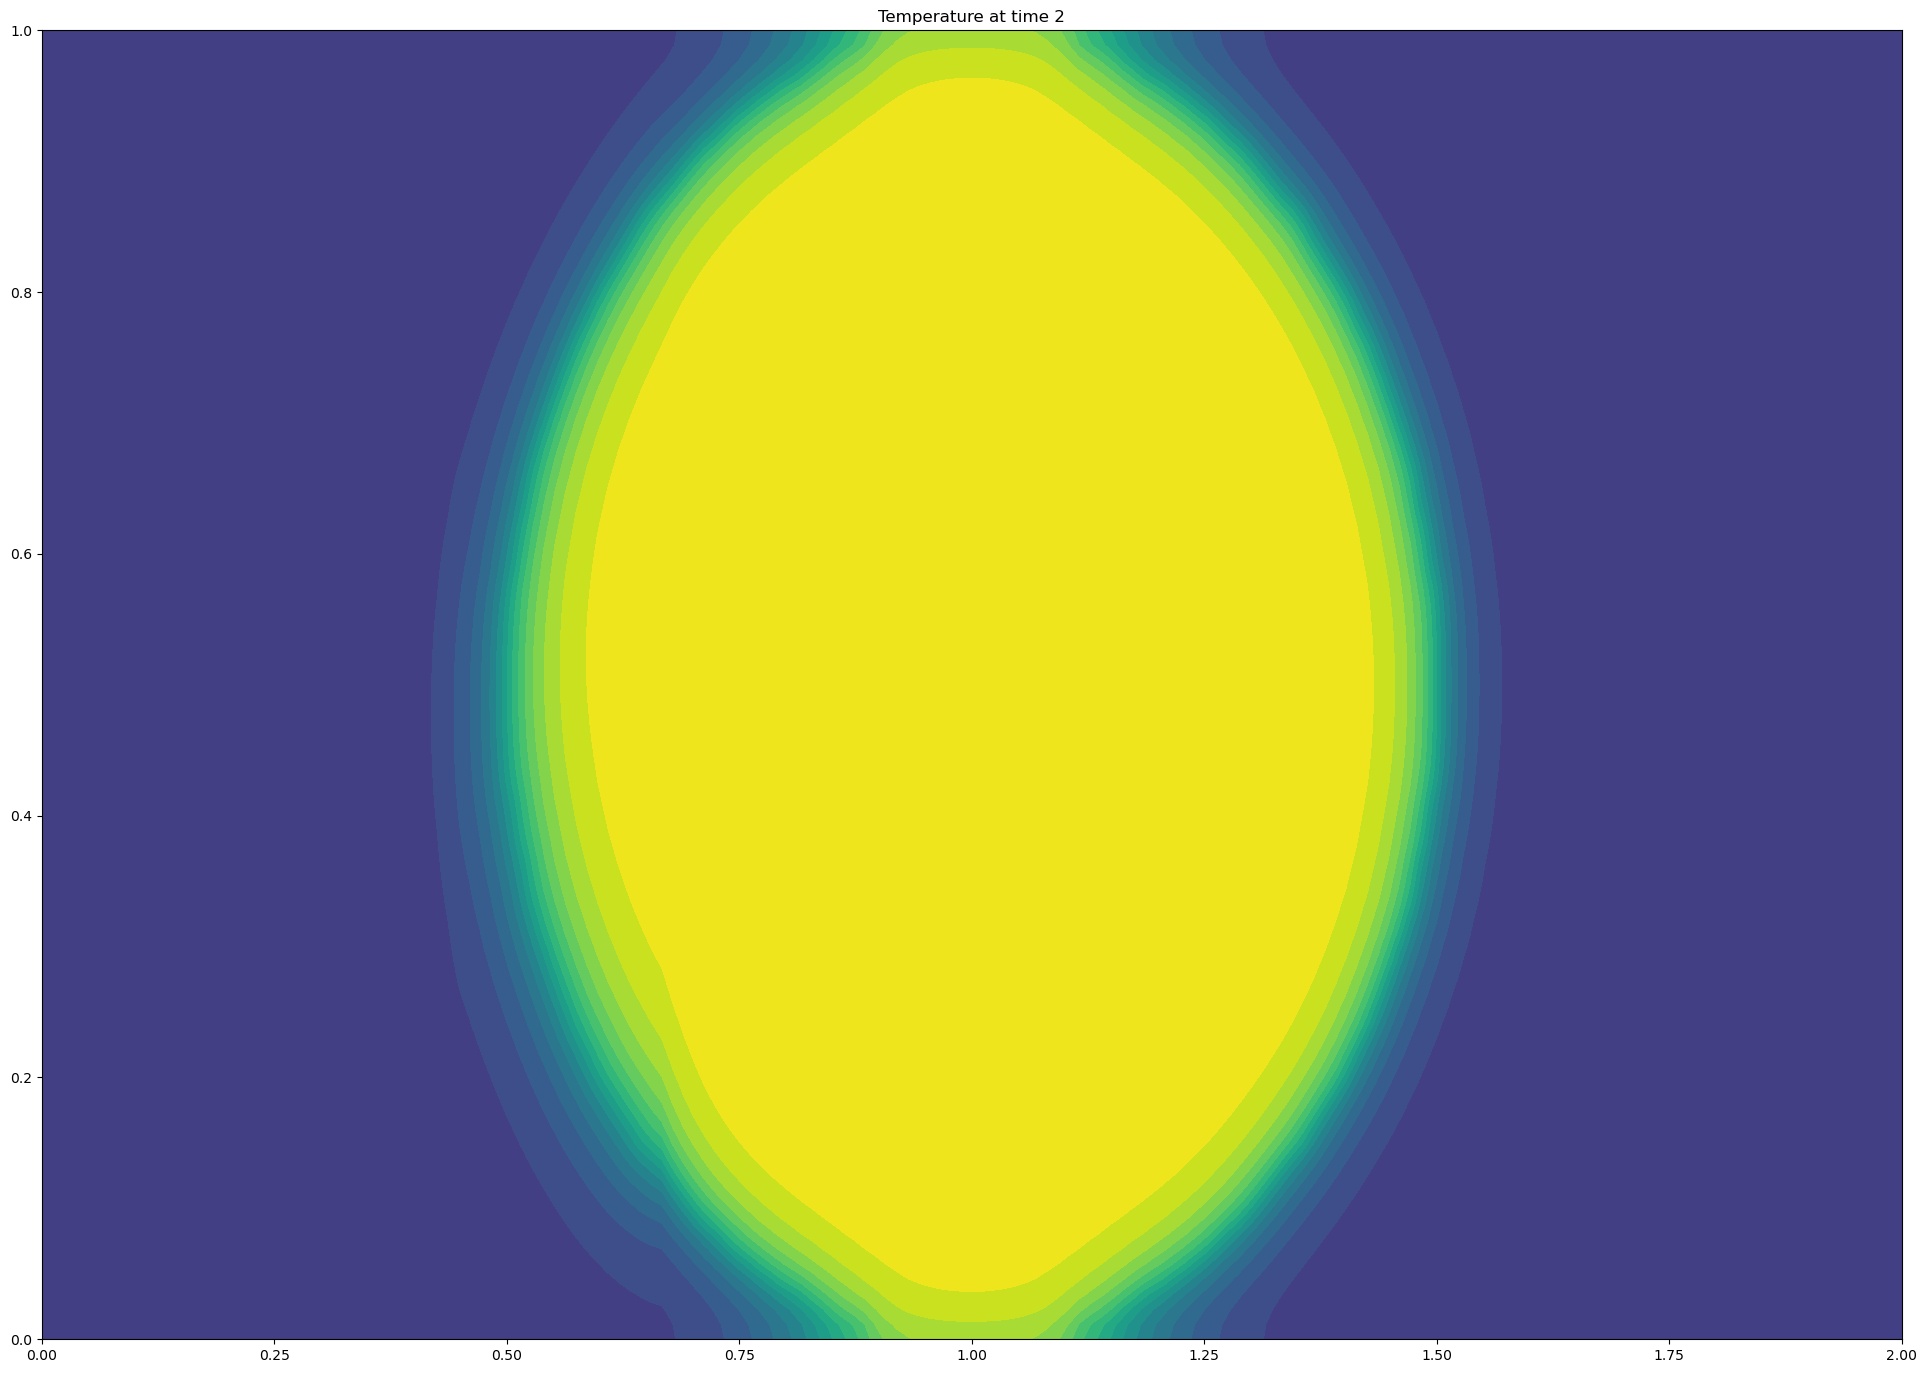

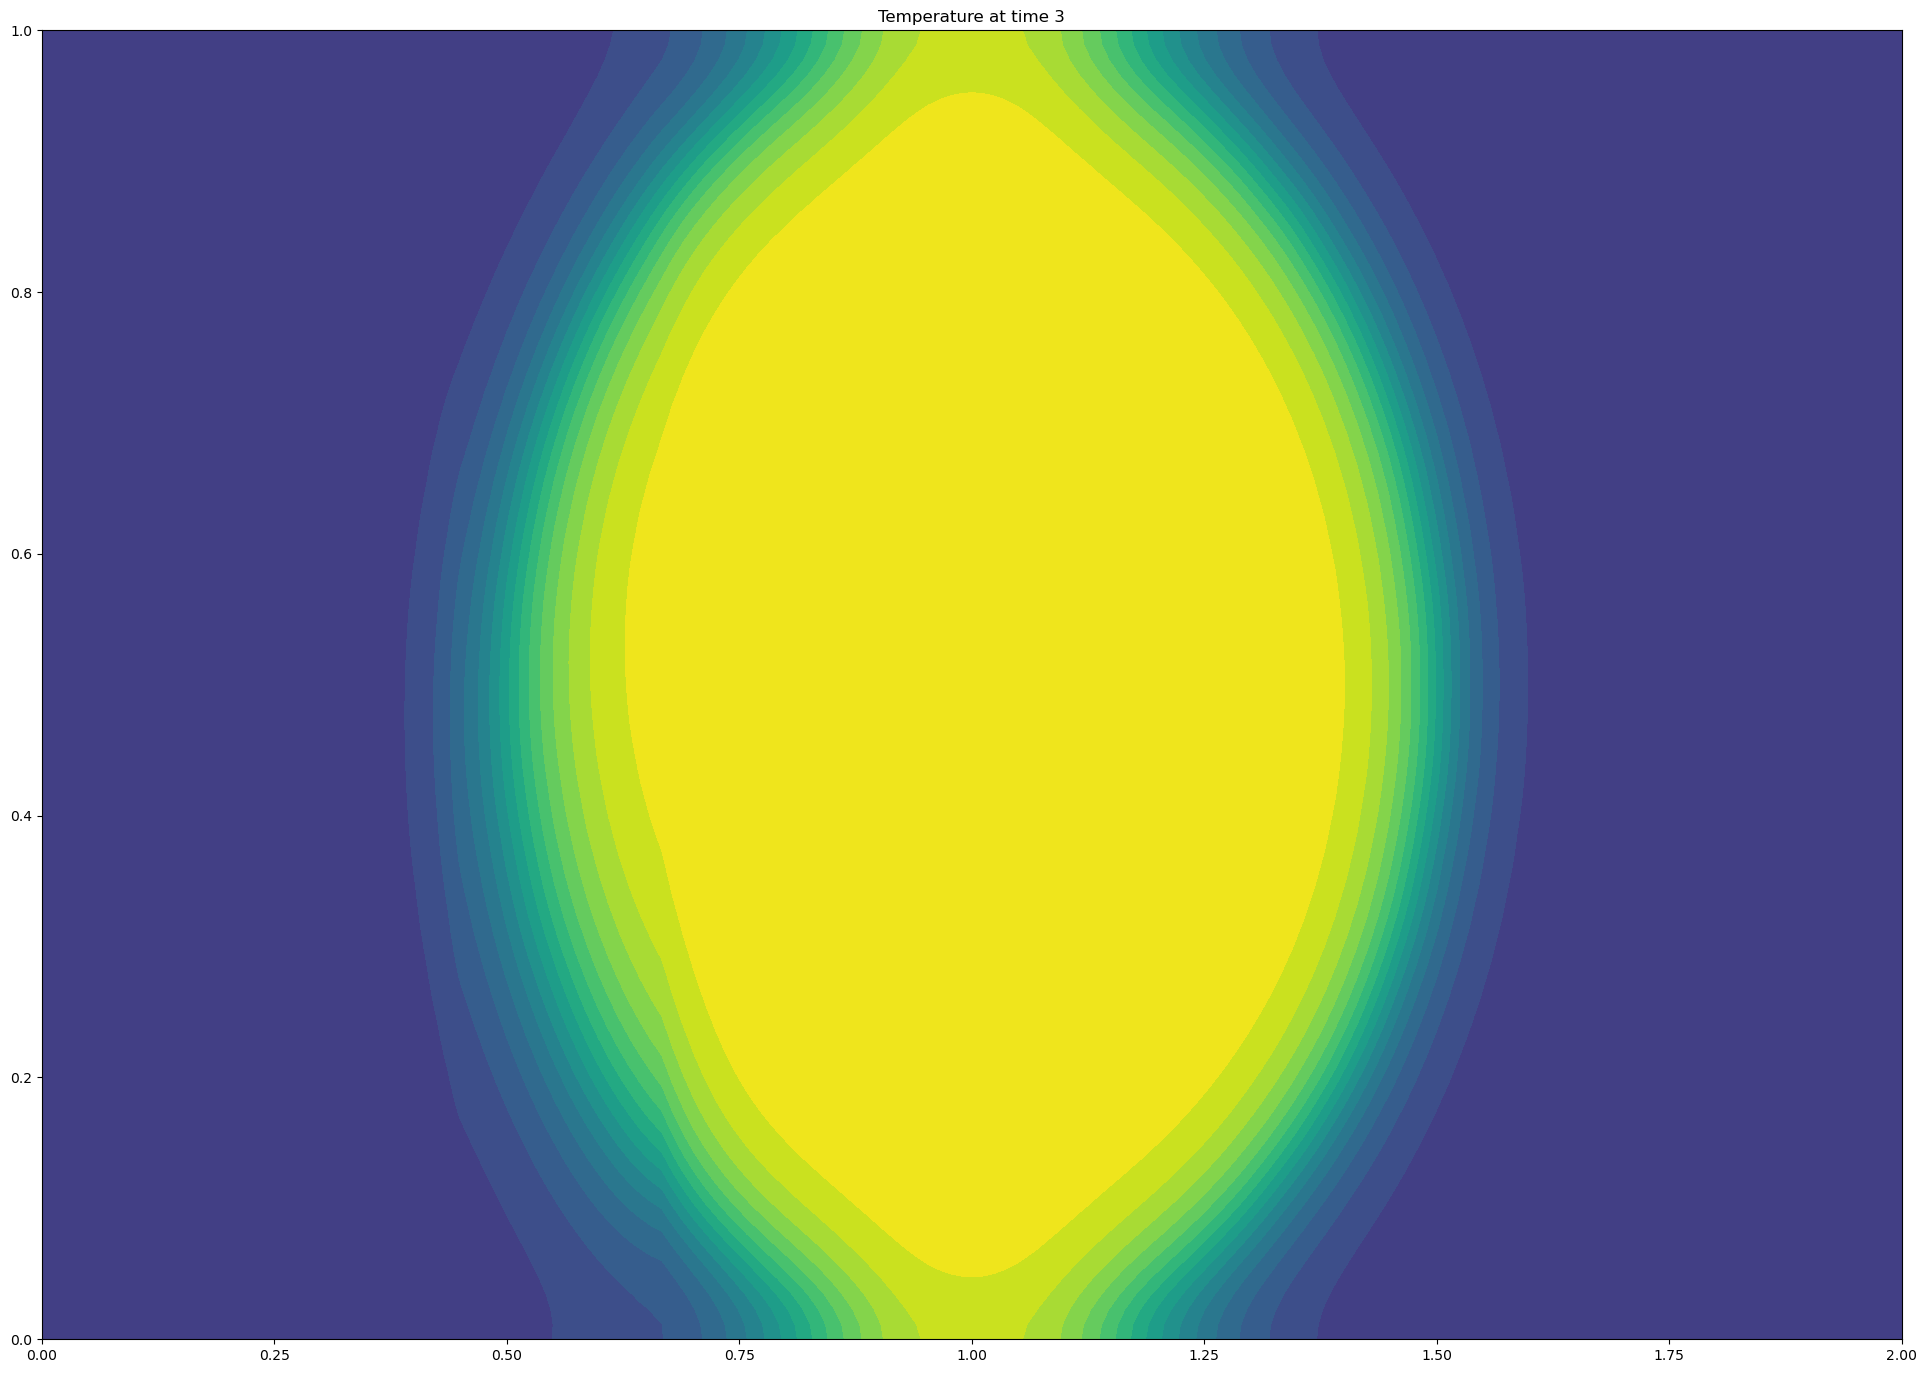

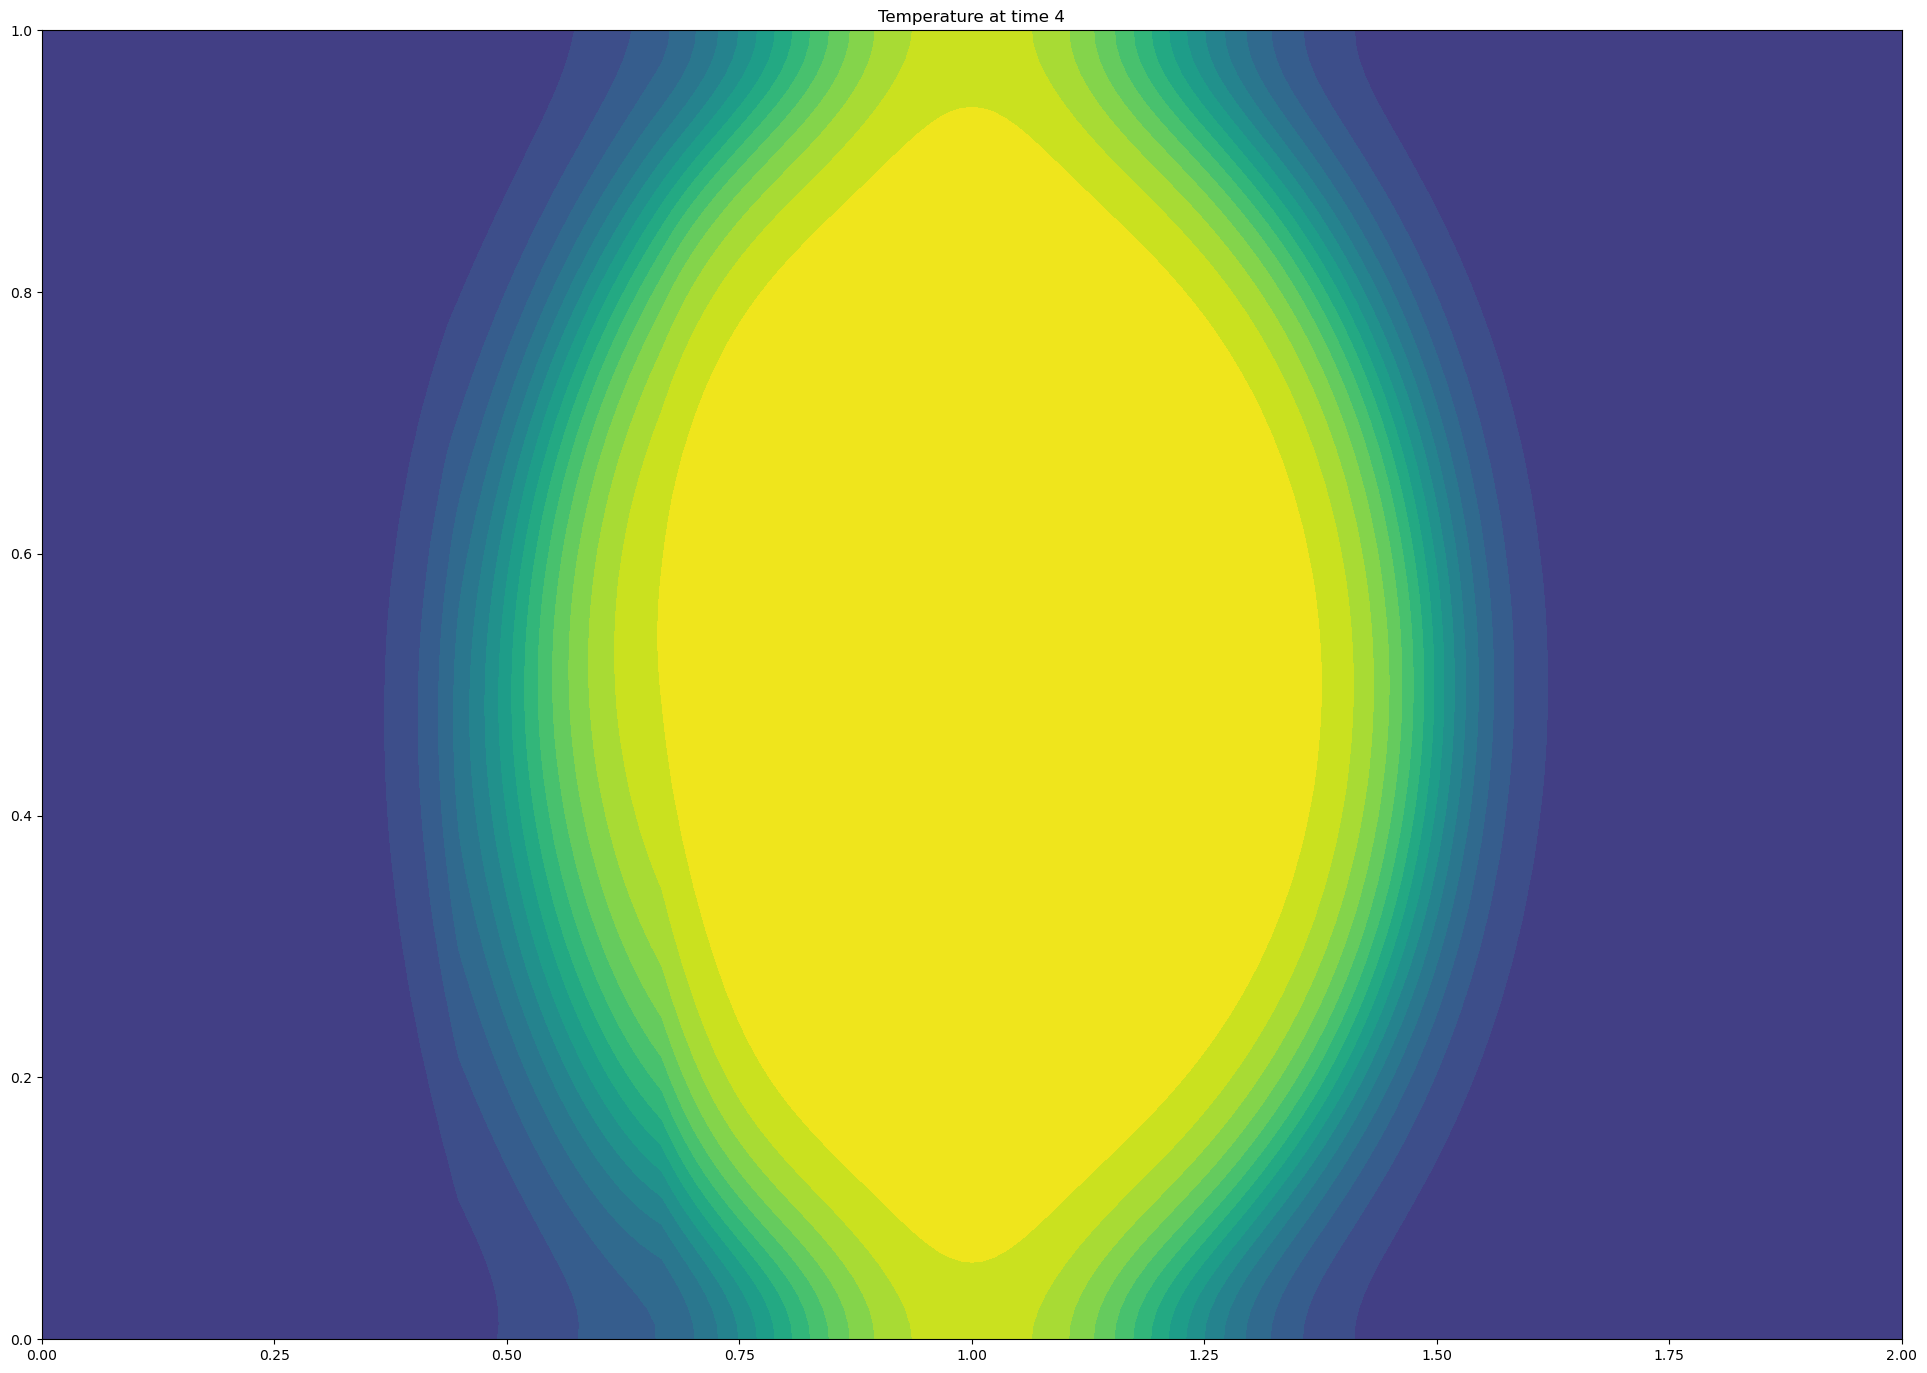

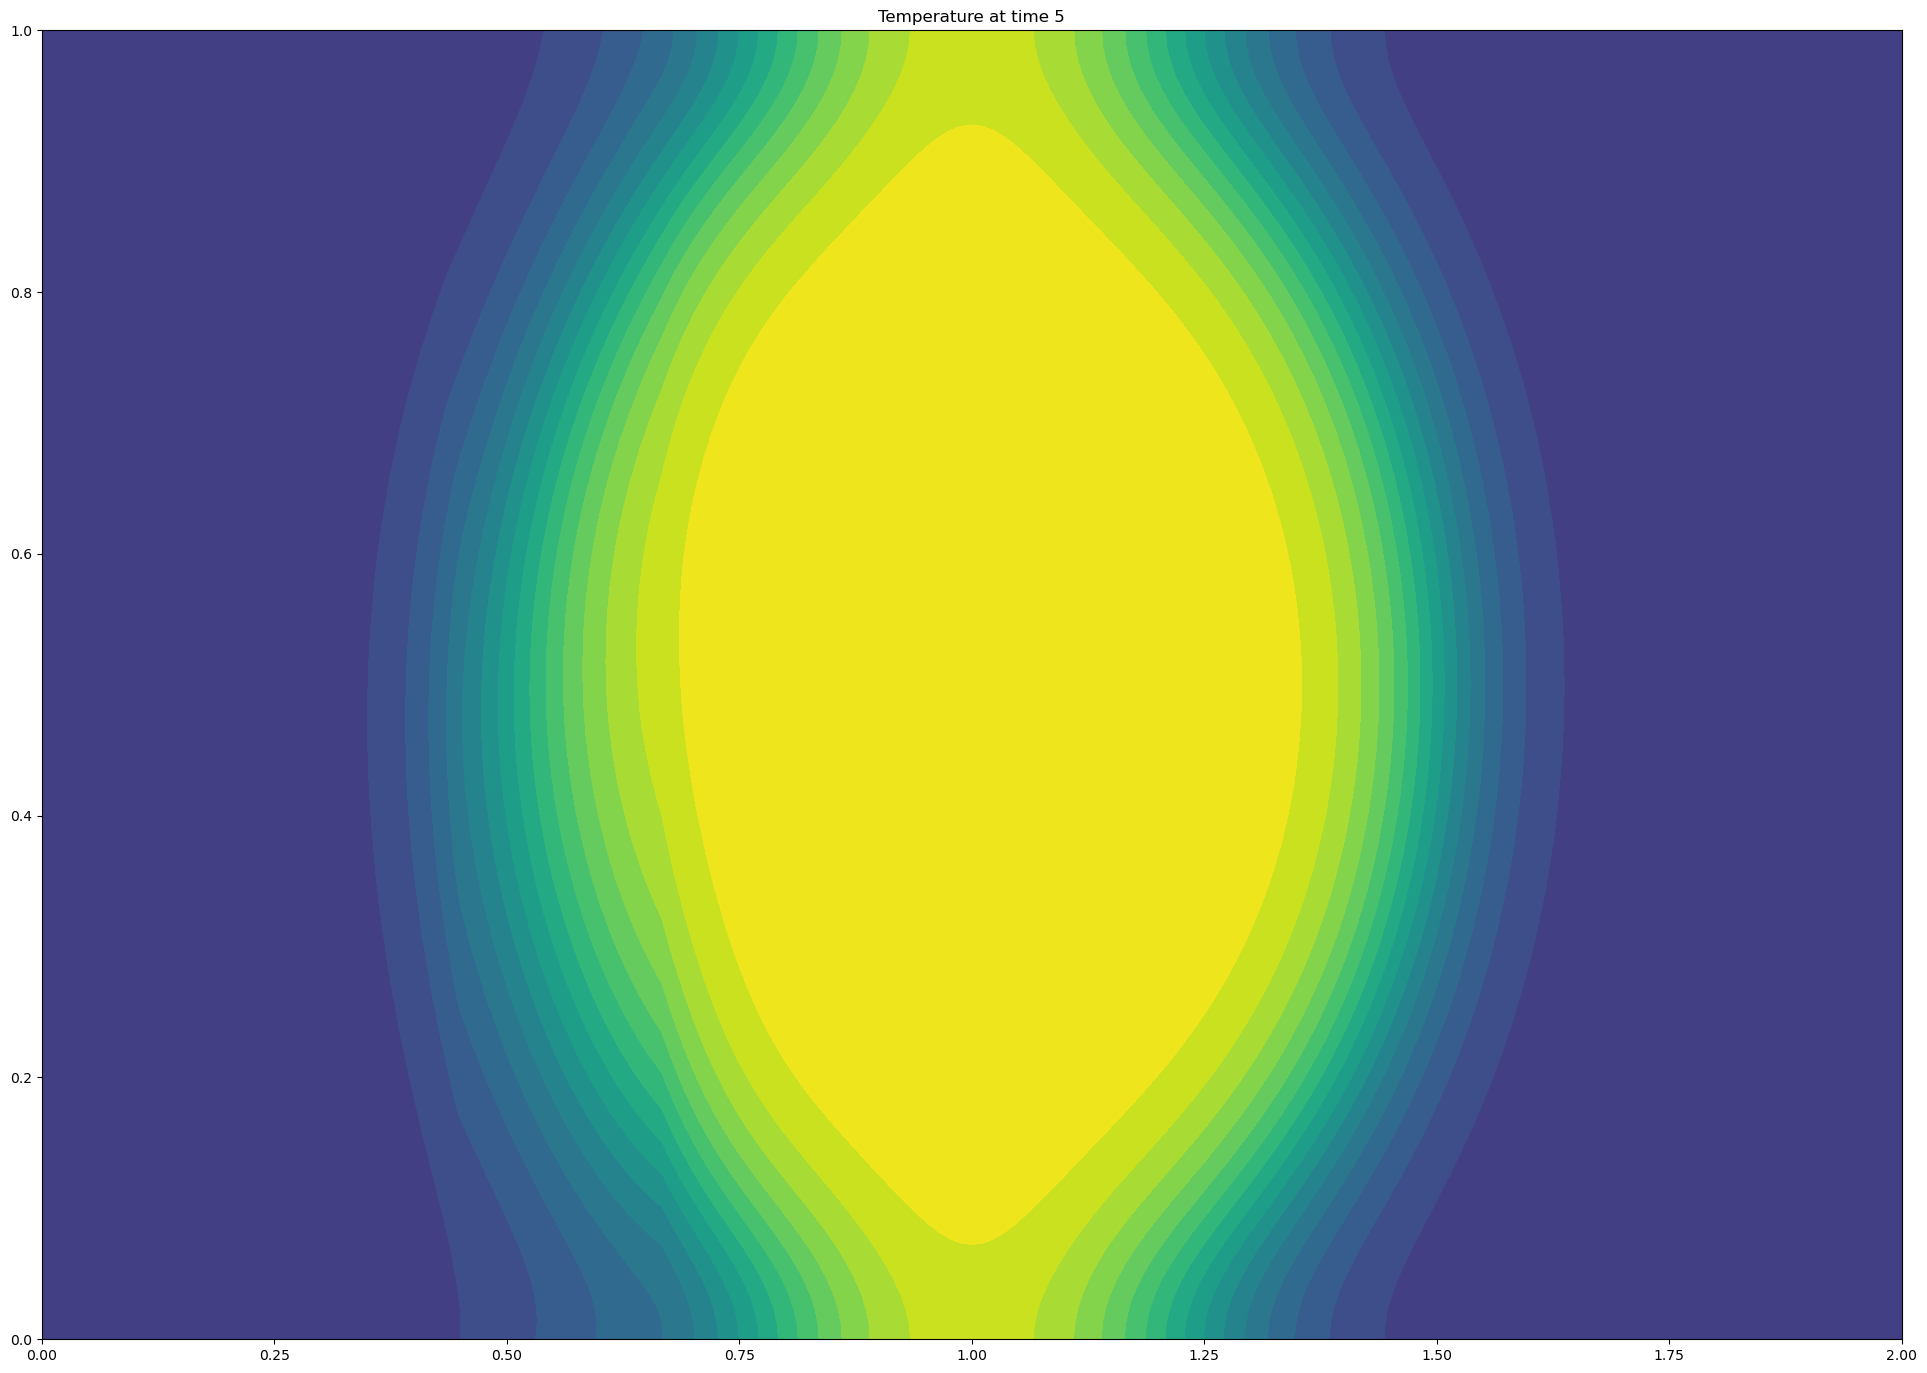

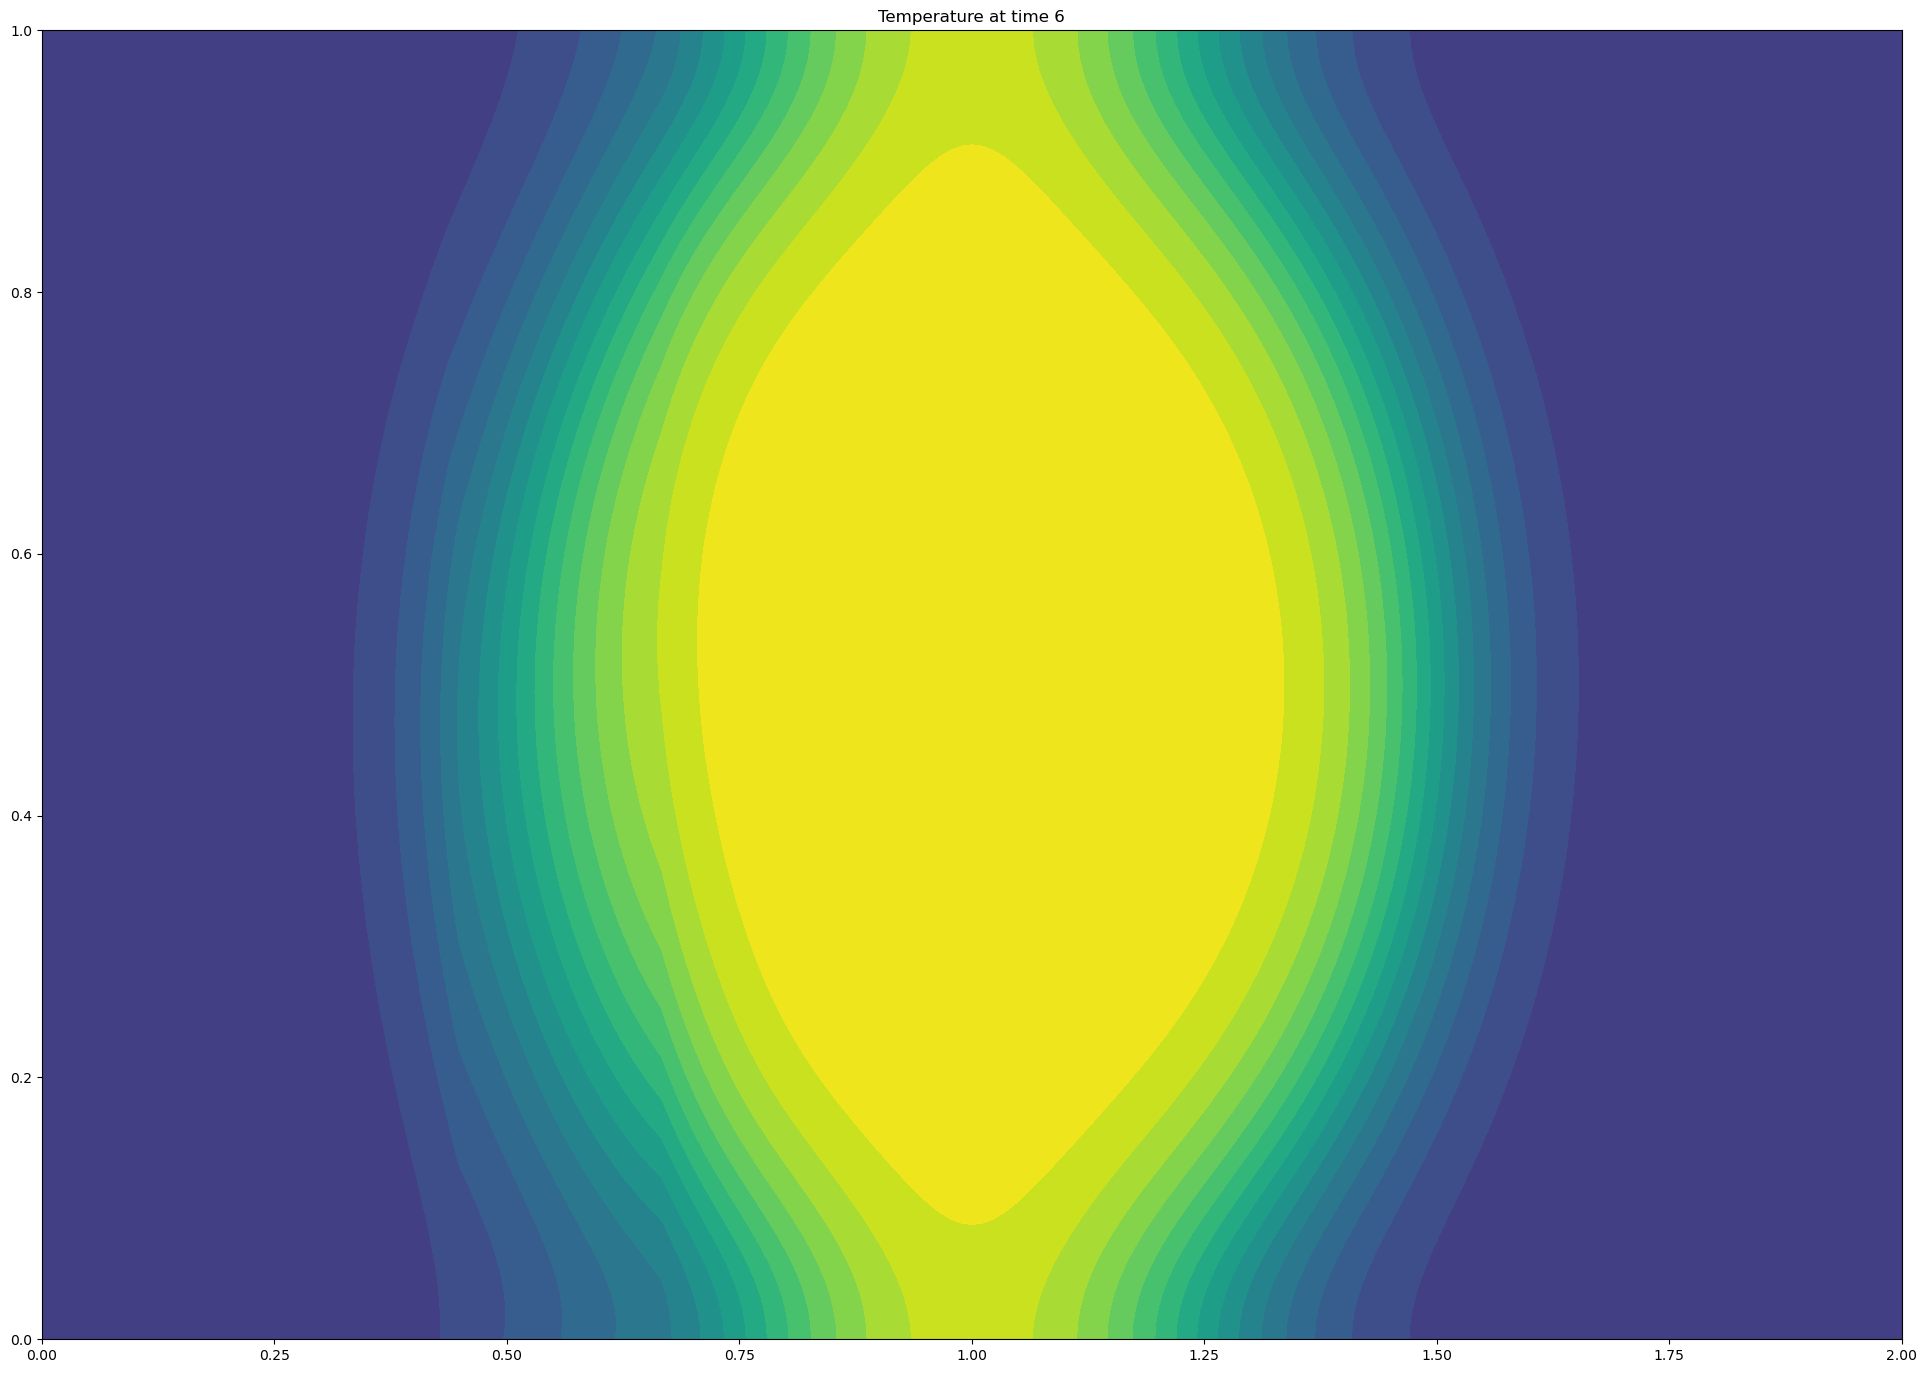

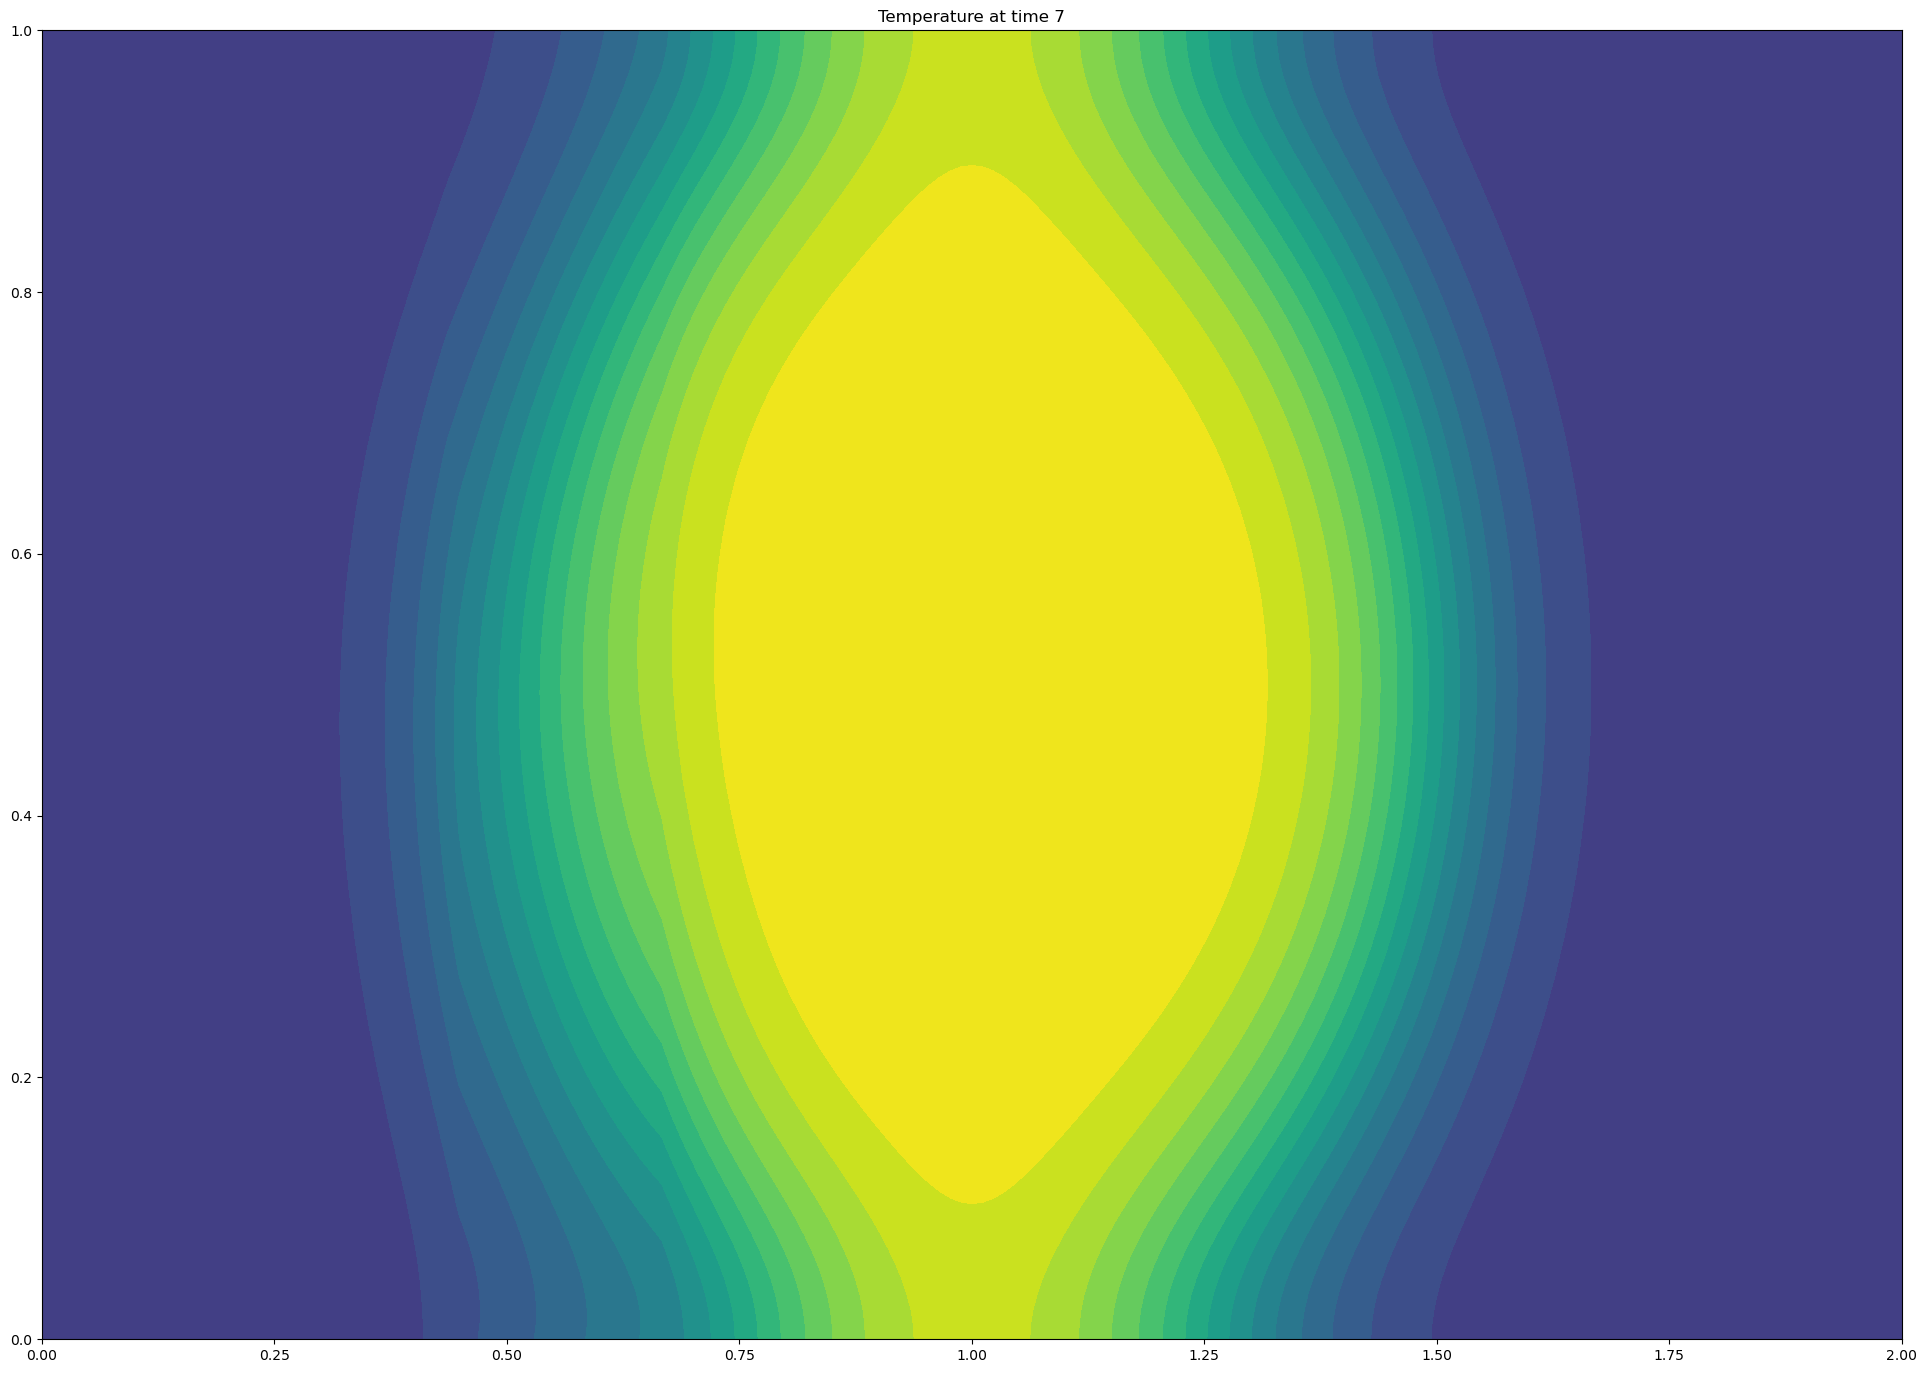

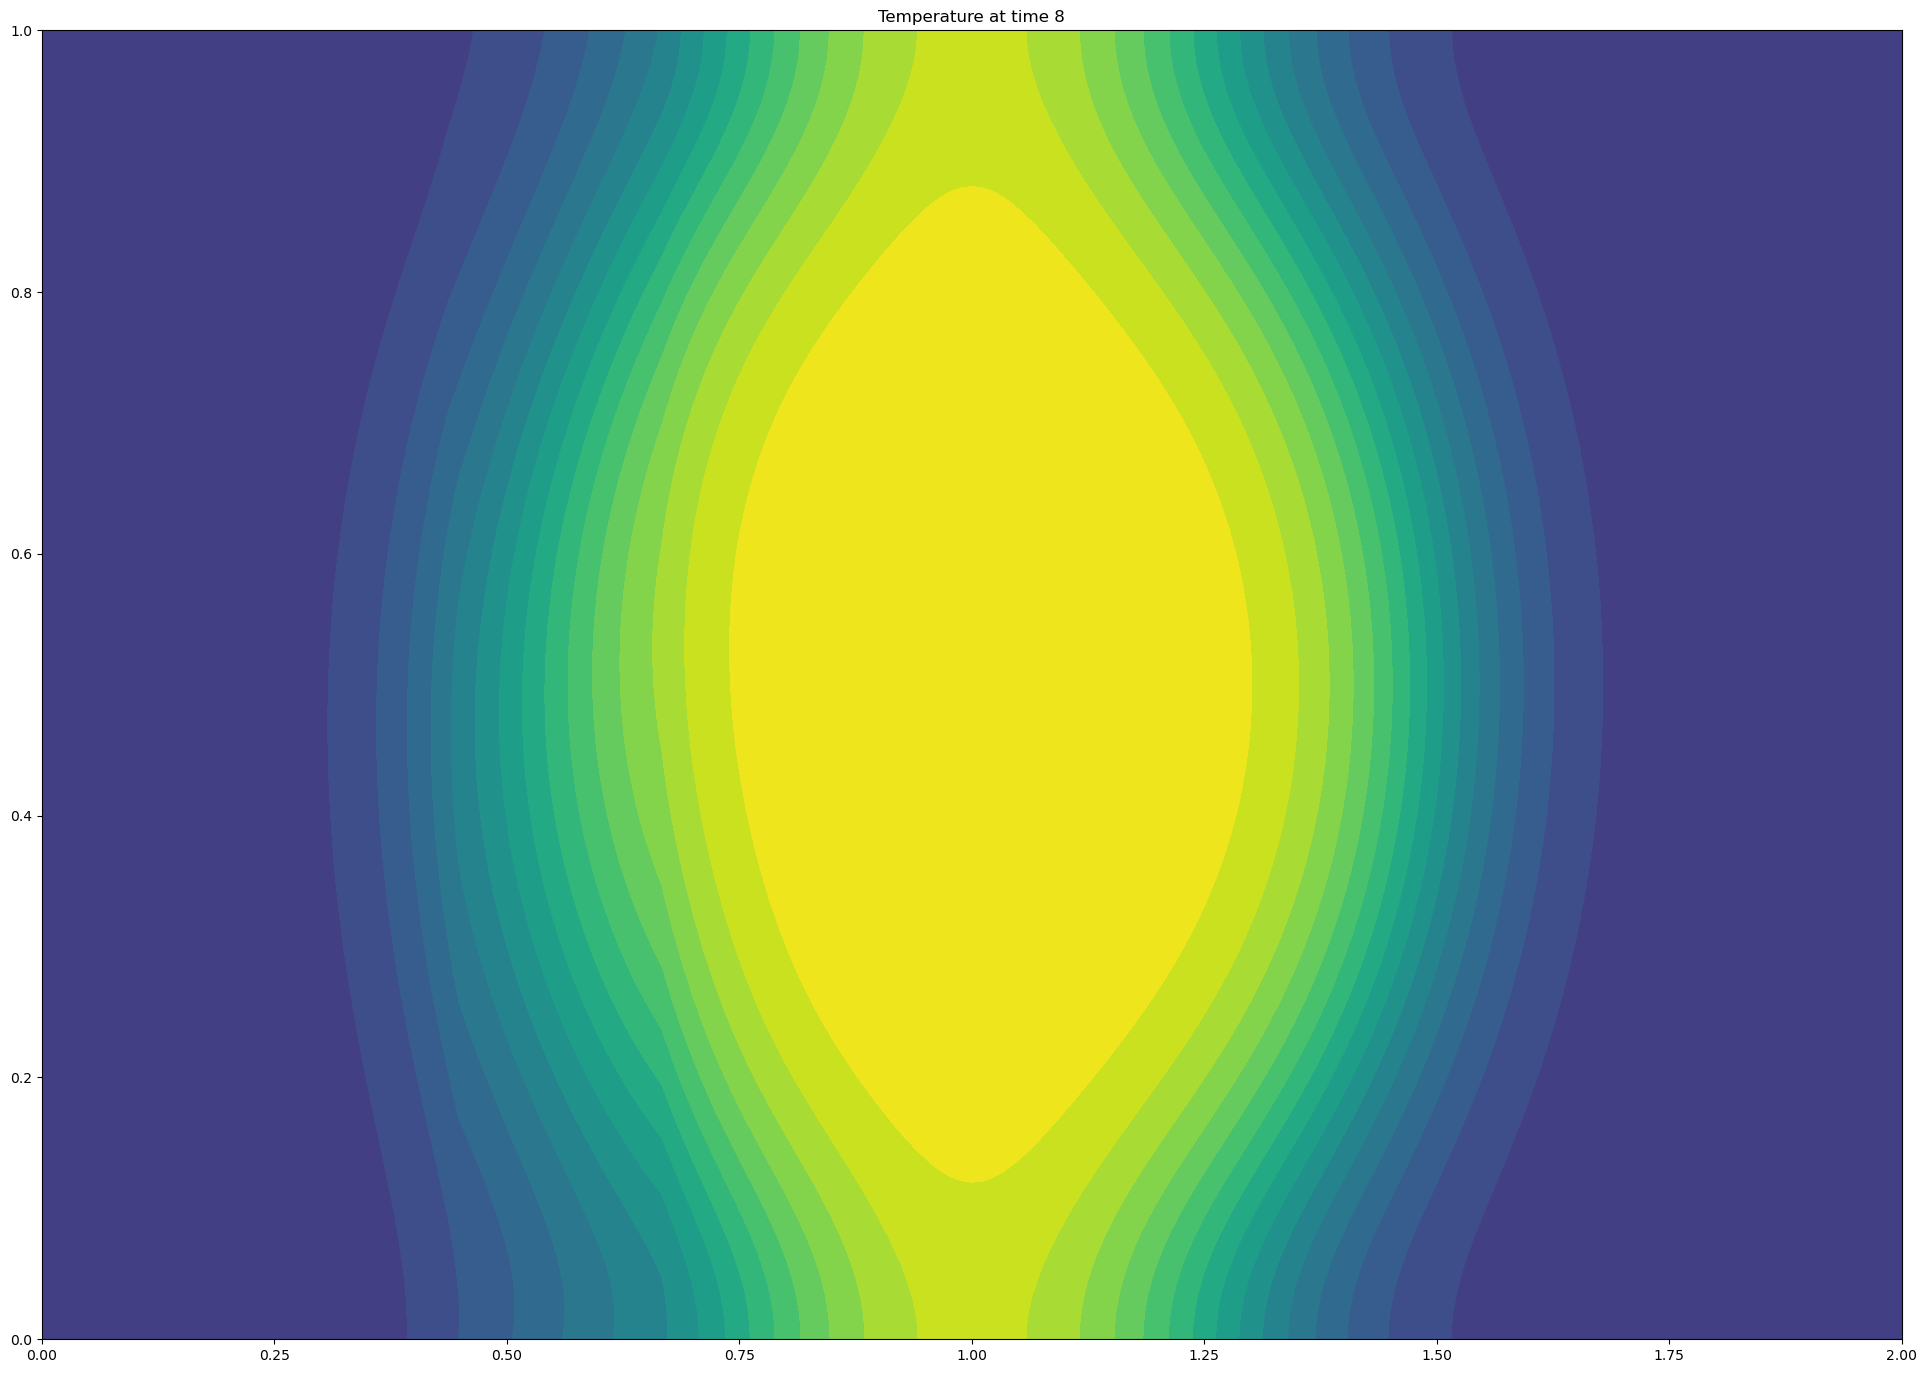

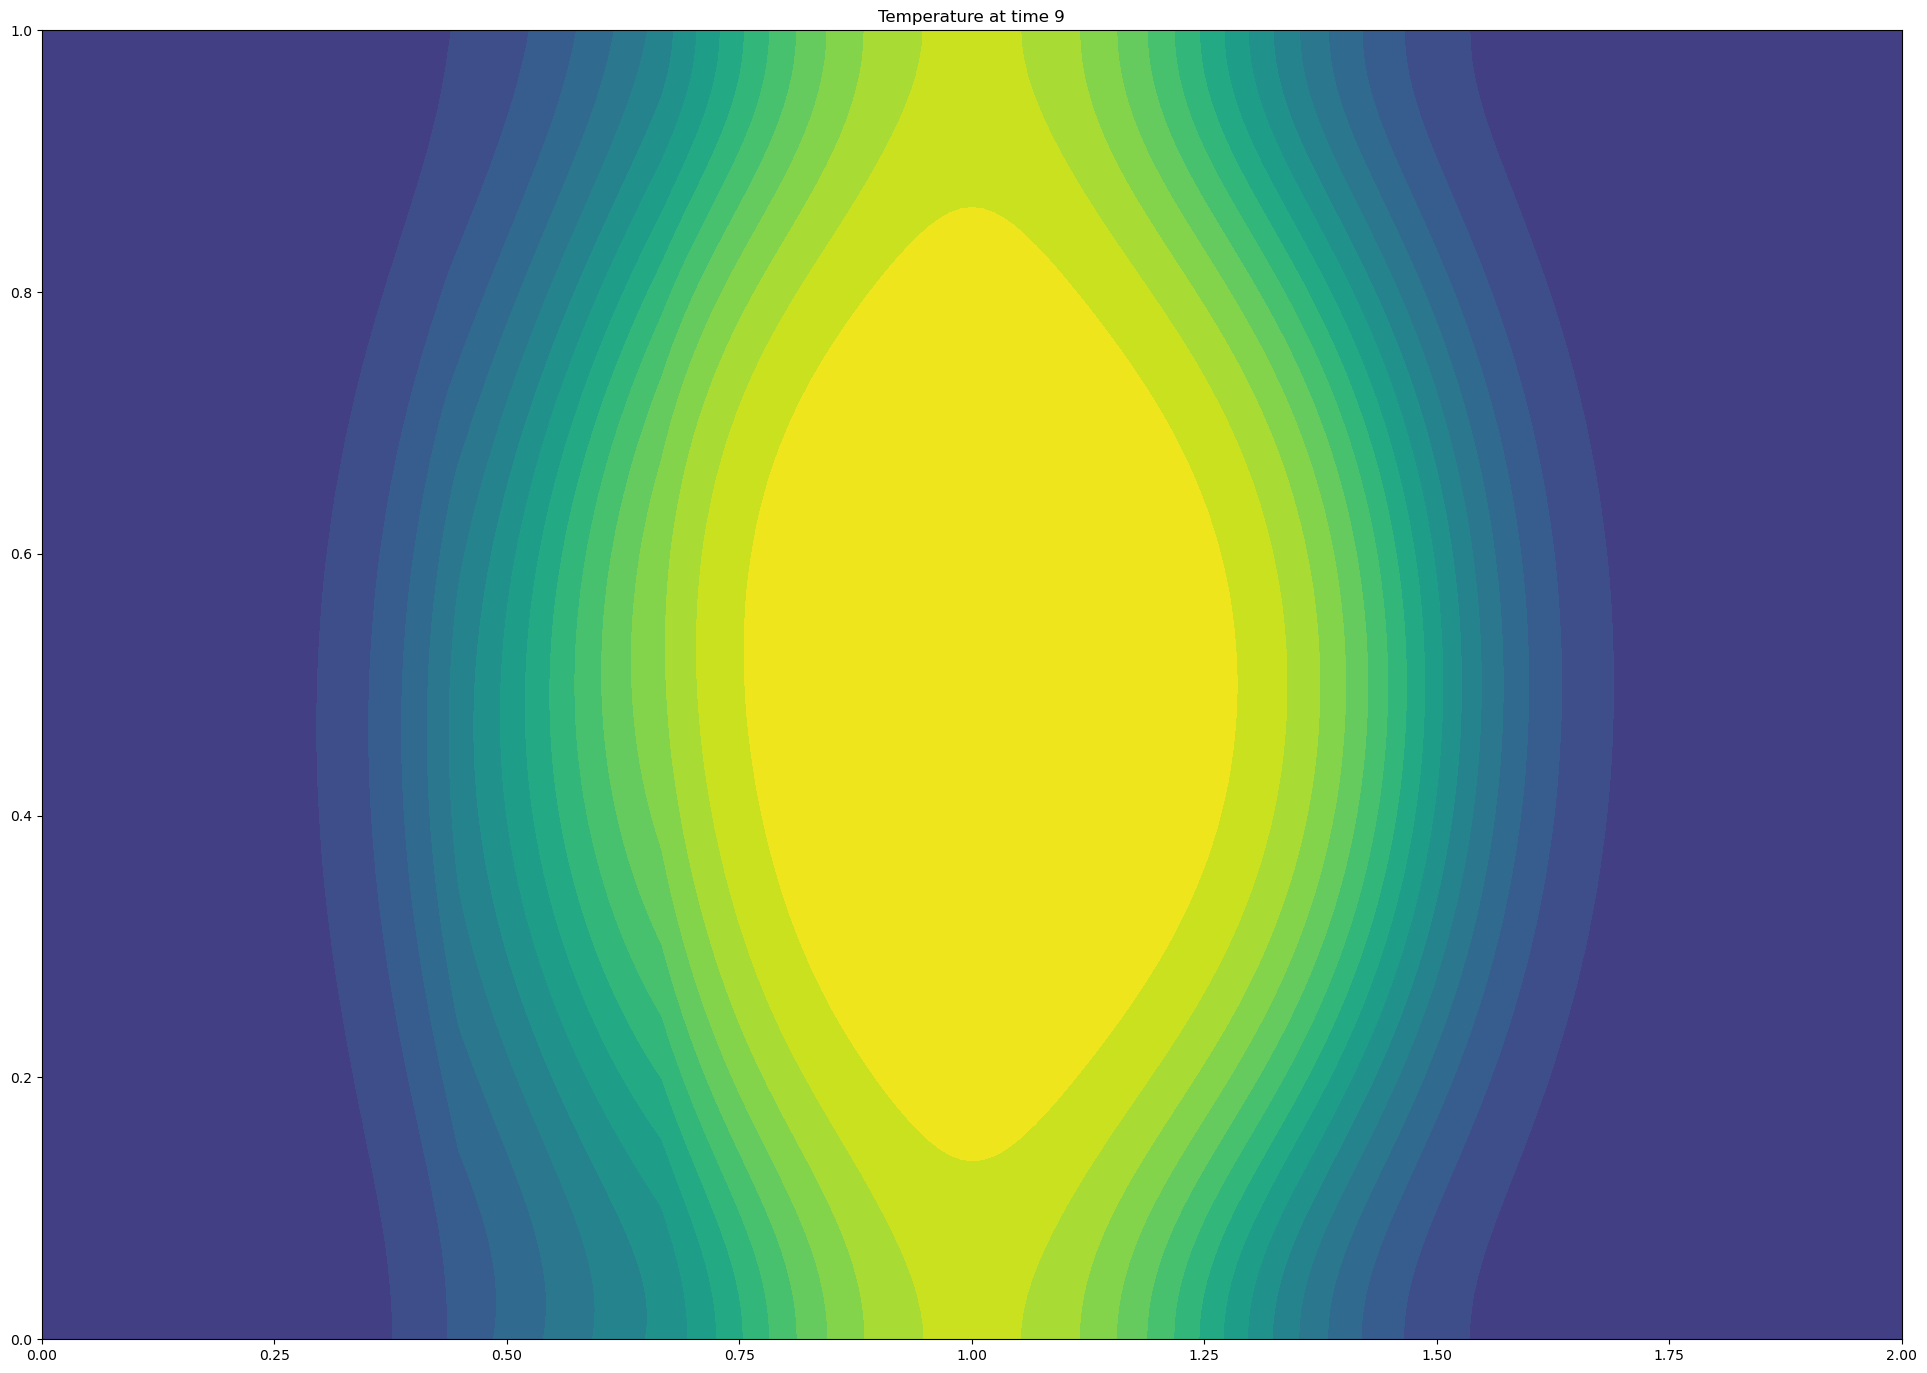

In [23]:
def test_fn_real_pt():

    size=87
    btmesh = CreateConstantRectilinearMesh([size*2+1,size+1], [0,0], [1/size, 1/size])
    # casting to simplex
    MeshToSimplex(btmesh,inPlace=True)
    weight_matrix, stiffness_matrix = integrate_weight_and_stiffness(btmesh)

    initial_state_flat = np.zeros(btmesh.GetNumberOfNodes())
    initial_state_flat[((btmesh.nodes[:,0]-1)**2+(btmesh.nodes[:,1]-0.5)**2)<0.25]=1
    size=87
    x,y = torch.meshgrid(torch.linspace(0,2,2*size+1),torch.linspace(0,1,size+1),indexing="ij")

    s = torch.tensor(initial_state_flat,device=device)

    
    weight_matrix= torch.tensor(weight_matrix.todense(),device=device)
    stiffness_matrix= torch.tensor(stiffness_matrix.todense(),device=device)
    dt=1
    for i in range(1,10):
        
        plt.figure(figsize=(24,17))
        plt.contourf(x.numpy(),y.numpy(),s.cpu().numpy().reshape(87*2+1,87+1),levels=np.linspace(-0.2,1,20))
        plt.title("Temperature at time {}".format(i))

        s = torch.linalg.solve(weight_matrix+dt*stiffness_matrix,weight_matrix@s)

test_fn_real_pt()